# Postprocessing a Feed-Forward NN Trained for the Perfectly Stirred Reactor Case

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from scipy.integrate import solve_ivp

In [2]:
### Input Data

ROMNetFldr    = WORKSPACE_PATH + '/ROMNet/romnet/'

OutputDir     = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases/'
TestDir       = WORKSPACE_PATH+'/ROMNet/Data/PSR_10Cases_Test/'

PathToRunFld  = WORKSPACE_PATH + '/ROMNet/PSR_10Cases/FNN-SourceTerms/Deterministic/Run_18/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN-SourceTerms/MCDropOut/Run_1/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN-SourceTerms/BayesByBackprop/Run_1/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/MSD_10Cases/FNN-SourceTerms/HamiltonianMC/Run_1/'

CasesVec      = [3]#[0,2,4,6,8]
DirDir        = OutputDir #OutputDir #TestDir

NSamples      = 1

NVarsRed      = 3
SOLVER        = 'BDF'  #'BDF'RK45
atol          = 1.e-8  #1.e-15
TestOutputVars= ['SPC_1','SPC_2','SPC_3']

In [3]:
print("\n[ROMNet]: Reading Input File from: ", PathToRunFld)
sys.path.insert(0, PathToRunFld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData                 = inputdata(WORKSPACE_PATH, ROMNetFldr)

InputData.PathToRunFld    = PathToRunFld

InputData.PathToFigFld    = InputData.PathToRunFld+'/Figures/'
print("\n[ROMNet]: Final Figures can be Found here: " + InputData.PathToFigFld)

InputData.PathToParamsFld = InputData.PathToRunFld+'/Params/'
print("\n[ROMNet]: Final Parameters can be Found here: " + InputData.PathToParamsFld)

InputData.TBCheckpointFldr = None


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE//ROMNet/PSR_10Cases/FNN-SourceTerms/Deterministic/Run_18/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...

[ROMNet]: Final Figures can be Found here: /Users/sventur/WORKSPACE//ROMNet/PSR_10Cases/FNN-SourceTerms/Deterministic/Run_18//Figures/

[ROMNet]: Final Parameters can be Found here: /Users/sventur/WORKSPACE//ROMNet/PSR_10Cases/FNN-SourceTerms/Deterministic/Run_18//Params/


In [4]:
### Loading Surrogate

SurrogateType = InputData.SurrogateType
if (SurrogateType == 'FNN-SourceTerms'):
    SurrogateType = 'FNN'

sys.path.insert(0, InputData.ROMNetFldr  + '/src/Model/' + SurrogateType + '/' + InputData.ProbApproach + '/')
from Model import model

InputData.TrainIntFlg = 0

NN = model(InputData, InputData.PathToRunFld, None, None)

NN.load_params(InputData) 



# ModelFile      = InputData.PathToRunFld    + '/NNModel'
# Model          = keras.models.load_model(ModelFile, custom_objects={InputData.LossFunction: None})
# Model.summary()

# MCFile         = InputData.PathToParamsFld + "/ModelCheckpoint/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(MCFile)
# latest         = train.latest_checkpoint(checkpoint_dir)
# Model.load_weights(latest)

[ROMNet]:   Defining ML Model from Scratch
[ROMNet]:   Compiling ML Model with Loss and Optimizer
[ROMNet]:   Saving ML Model in File: /Users/sventur/WORKSPACE//ROMNet/PSR_10Cases/FNN-SourceTerms/Deterministic/Run_18//NNModel
INFO:tensorflow:Assets written to: /Users/sventur/WORKSPACE//ROMNet/PSR_10Cases/FNN-SourceTerms/Deterministic/Run_18//NNModel/assets
[ROMNet]:   Summarizing ML Model Structure:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
NN_SPC_1_Scaled_HL1 (Dense)  (None, 64)                320       
_________________________________________________________________
dropout (Dropout)            (None, 64)               

In [5]:
### Evaluating on Training Data

FileName  = InputData.PathToTrainDataFld + '/' + InputData.InputFile
InputDF   = pd.read_csv(FileName, header=0)
Input     = InputDF[InputData.InputVars].to_numpy()
VarNames  = list(InputDF.columns)


FileName  = InputData.PathToTrainDataFld + '/' + InputData.OutputFile
OutputDF  = pd.read_csv(FileName, header=0)
Output    = OutputDF[InputData.OutputVars].to_numpy()


FileName  = InputData.PathToTrainDataFld + '/MinMax.csv'
MinMaxDF  = pd.read_csv(FileName)
MinVals   = MinMaxDF['Min'].to_numpy()
MaxVals   = MinMaxDF['Max'].to_numpy()

Text(0.5, 0, 'SPC_3_Scaled')

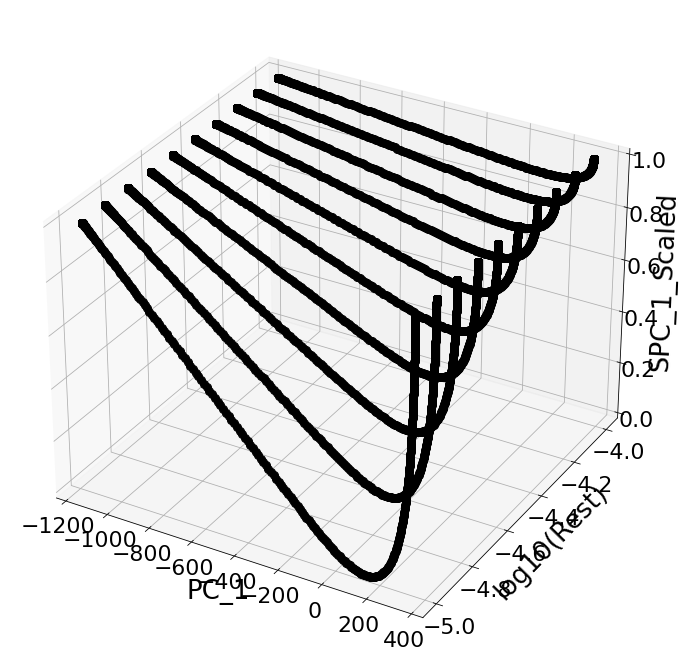

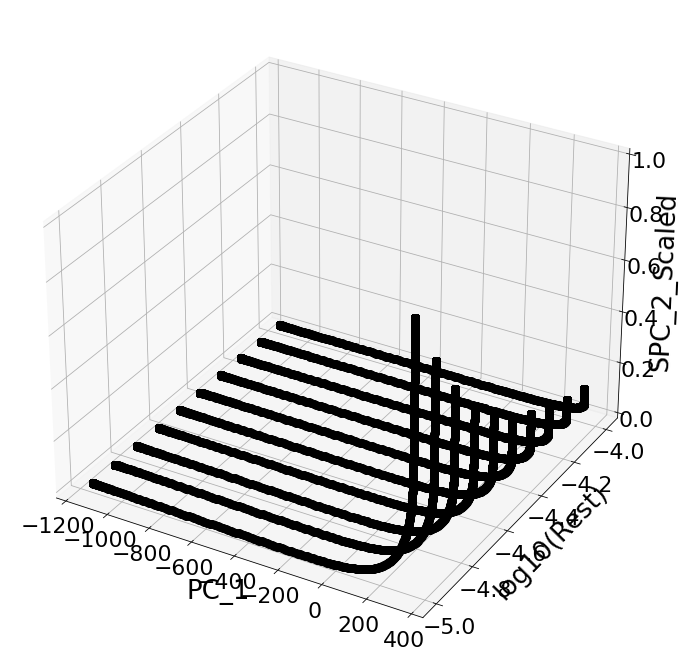

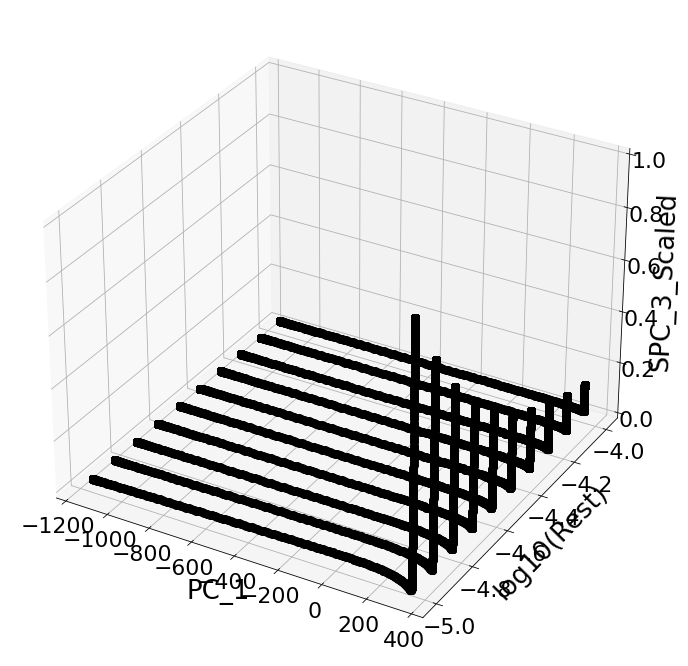

In [6]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(InputDF[InputData.InputVars[1]], InputDF[InputData.InputVars[0]], OutputDF[InputData.OutputVars[0]], 'ok',  linewidth=2)
ax.set_xlabel(InputData.InputVars[1])
ax.set_ylabel(InputData.InputVars[0])
ax.set_zlabel(InputData.OutputVars[0])

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(InputDF[InputData.InputVars[1]], InputDF[InputData.InputVars[0]], OutputDF[InputData.OutputVars[1]], 'ok',  linewidth=2)
ax.set_xlabel(InputData.InputVars[1])
ax.set_ylabel(InputData.InputVars[0])
ax.set_zlabel(InputData.OutputVars[1])

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(InputDF[InputData.InputVars[1]], InputDF[InputData.InputVars[0]], OutputDF[InputData.OutputVars[2]], 'ok',  linewidth=2)
ax.set_xlabel(InputData.InputVars[1])
ax.set_ylabel(InputData.InputVars[0])
ax.set_zlabel(InputData.OutputVars[2])

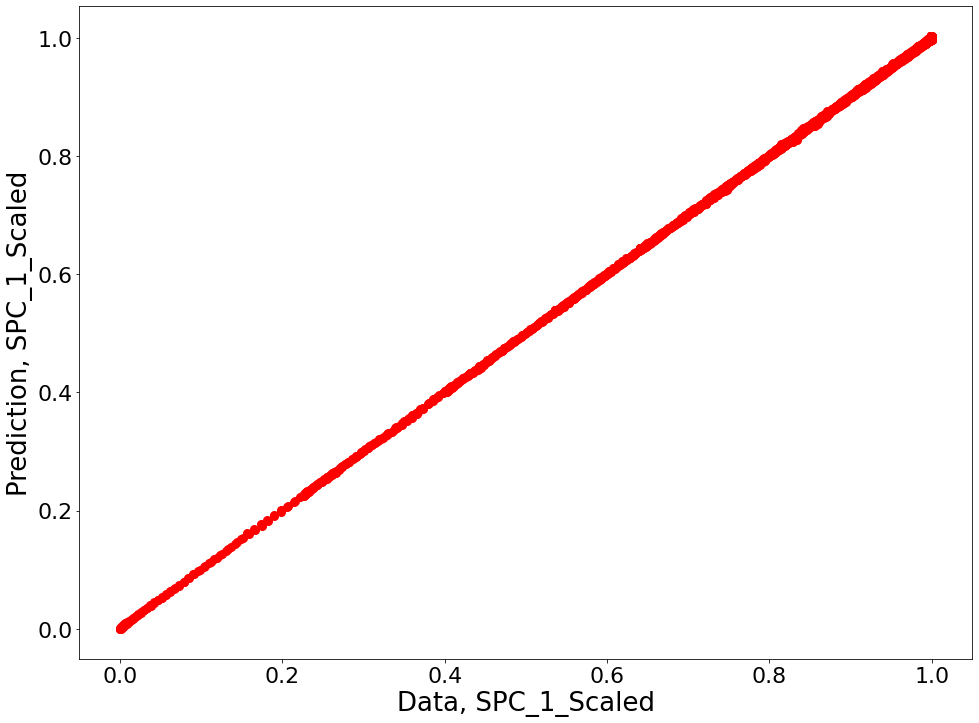

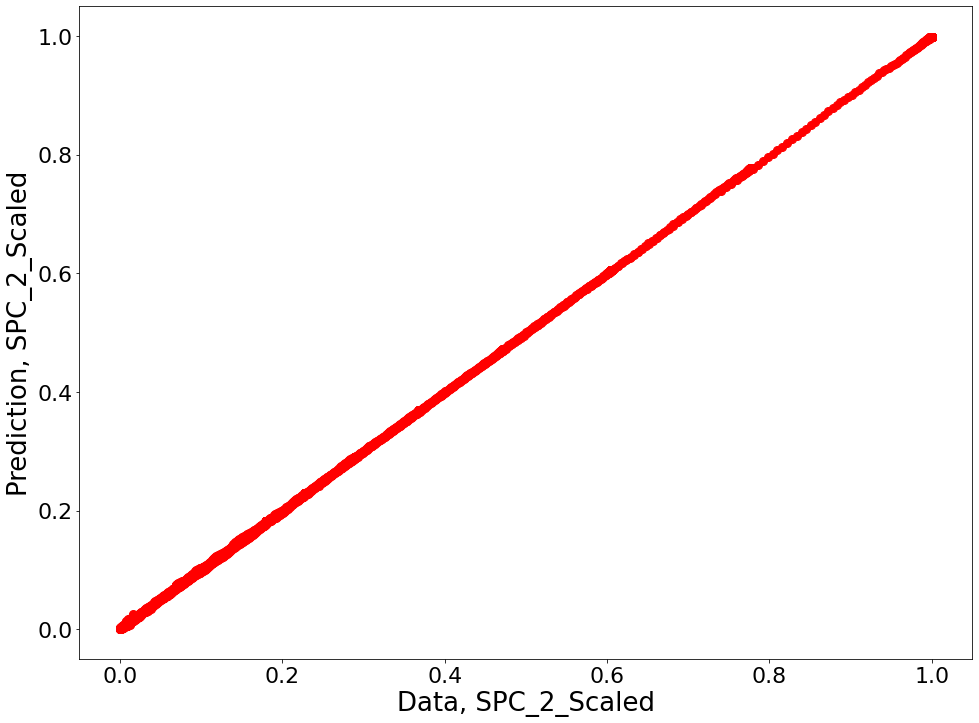

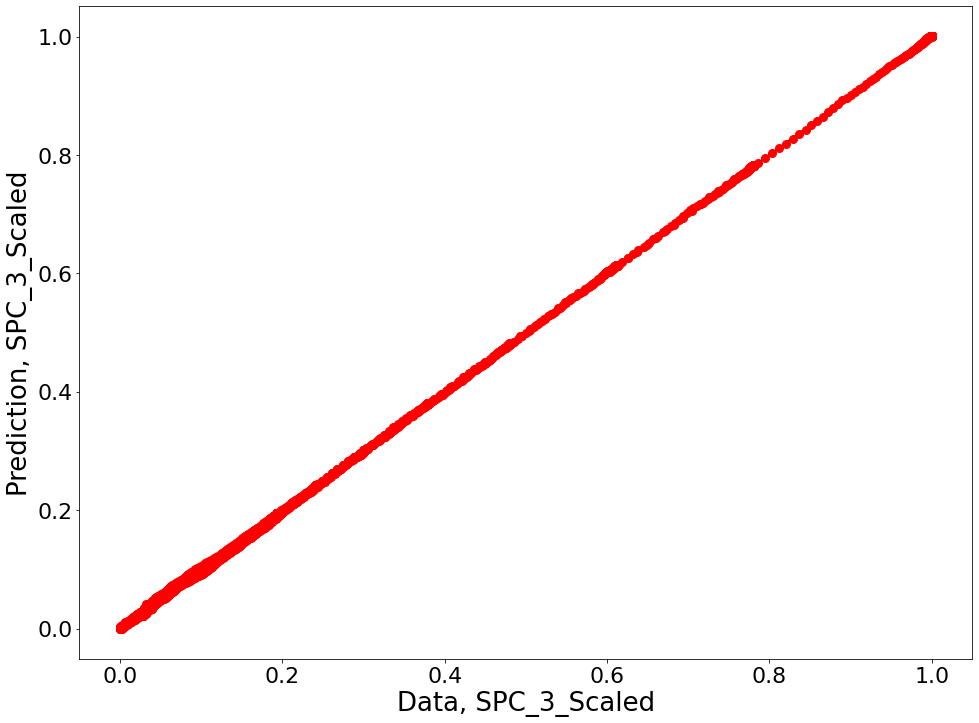

In [7]:
Ny   = len(InputData.OutputVars)
ax   = []
for iy in range(Ny):
    fig    = plt.figure(figsize=(16,12))
    ax.append(plt.axes())
    xMin_  = np.amin(Output[:,iy])
    xMax_  = np.amax(Output[:,iy])
    ax[iy].plot([xMin_,xMax_],[xMin_,xMax_],'k-')
    ax[iy].set_xlabel('Data, '+InputData.OutputVars[iy])
    ax[iy].set_ylabel('Prediction, '+InputData.OutputVars[iy])
    
for iSample in range(NSamples):
    yMat = NN.predict(InputDF[InputData.InputVars])
    for iy in range(Ny):
        ax[iy].plot(Output[:,iy], yMat[:,iy], 'ro')

Text(0.5, 0, 'SPC_3_Scaled')

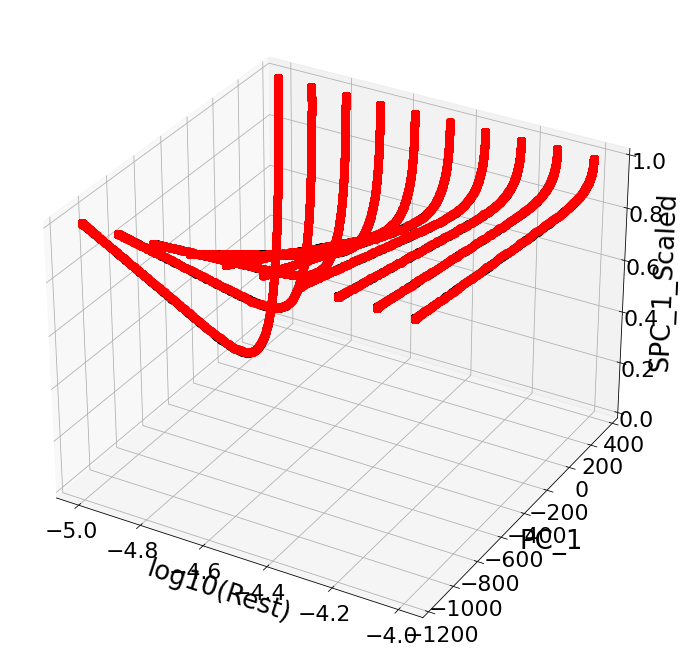

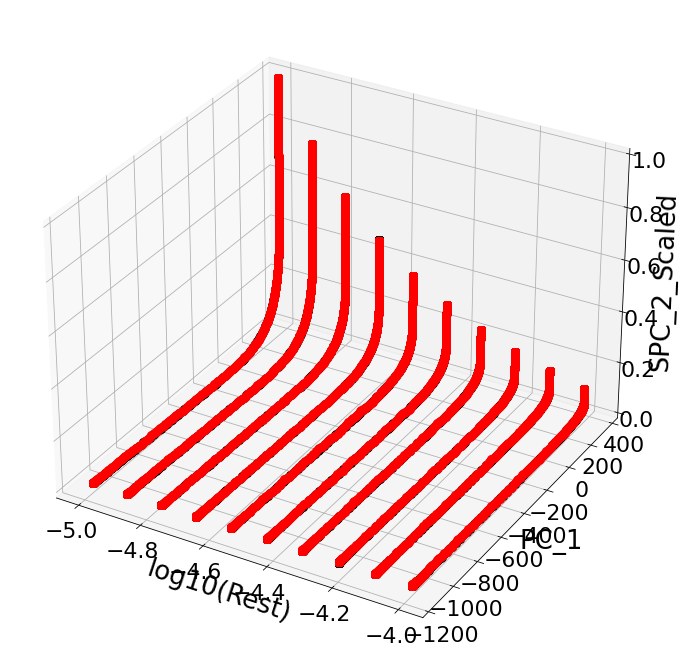

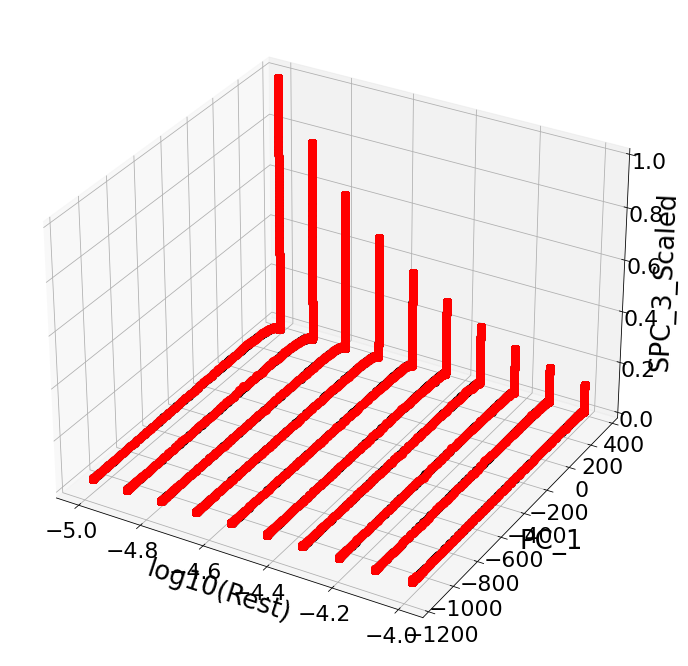

In [8]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax1  = plt.axes(projection='3d')
fig  = plt.figure(figsize=(16,12))
ax2   = plt.axes(projection='3d')
fig  = plt.figure(figsize=(16,12))
ax3   = plt.axes(projection='3d')

ax1.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[InputData.OutputVars[0]], 'ok',  linewidth=2)
ax2.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[InputData.OutputVars[1]], 'ok',  linewidth=2)
ax3.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[InputData.OutputVars[2]], 'ok',  linewidth=2)

for iSample in range(NSamples):
    yMat = NN.predict(InputDF[InputData.InputVars])
    ax1.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,0], 'or',  linewidth=2)
    ax2.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,1], 'or',  linewidth=2)
    ax3.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,2], 'or',  linewidth=2)

ax1.set_xlabel(InputData.InputVars[0])
ax1.set_ylabel(InputData.InputVars[1])
ax1.set_zlabel(InputData.OutputVars[0])

ax2.set_xlabel(InputData.InputVars[0])
ax2.set_ylabel(InputData.InputVars[1])
ax2.set_zlabel(InputData.OutputVars[1])

ax3.set_xlabel(InputData.InputVars[0])
ax3.set_ylabel(InputData.InputVars[1])
ax3.set_zlabel(InputData.OutputVars[2])

In [9]:
### Evaluating on Test Data

FileName  = DirDir + '/pc_data_'+str(NVarsRed) + '/' + InputData.InputFile
InputDF   = pd.read_csv(FileName, header=0)
Input     = InputDF[InputData.InputVars].to_numpy()
VarNames  = list(InputDF.columns)


FileName  = DirDir + '/pc_data_'+str(NVarsRed) + '/' + InputData.OutputFile
OutputDF  = pd.read_csv(FileName, header=0)
Output    = OutputDF[TestOutputVars].to_numpy()

In [10]:
def PredictFun(x, MinVals, MaxVals):
    Range   = MaxVals - MinVals
    yScaled = NN.predict(x)
    return yScaled*Range + MinVals

Text(0.5, 0, 'SPC_3')

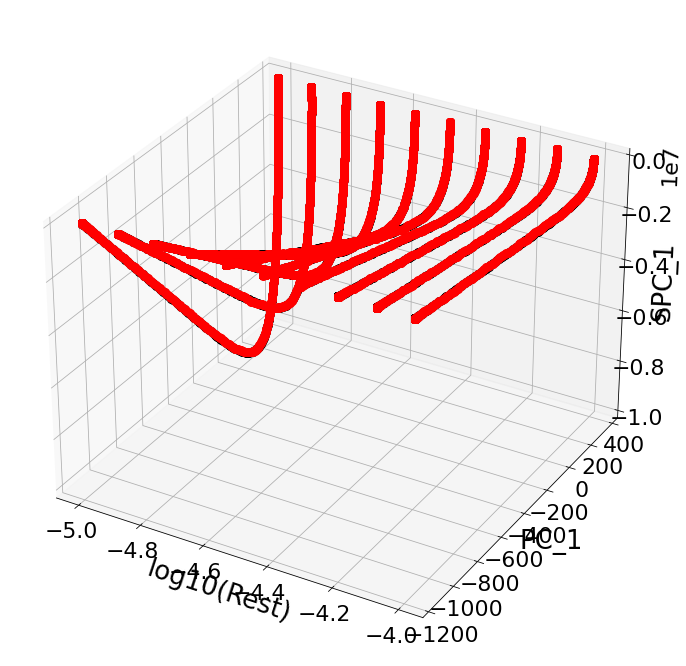

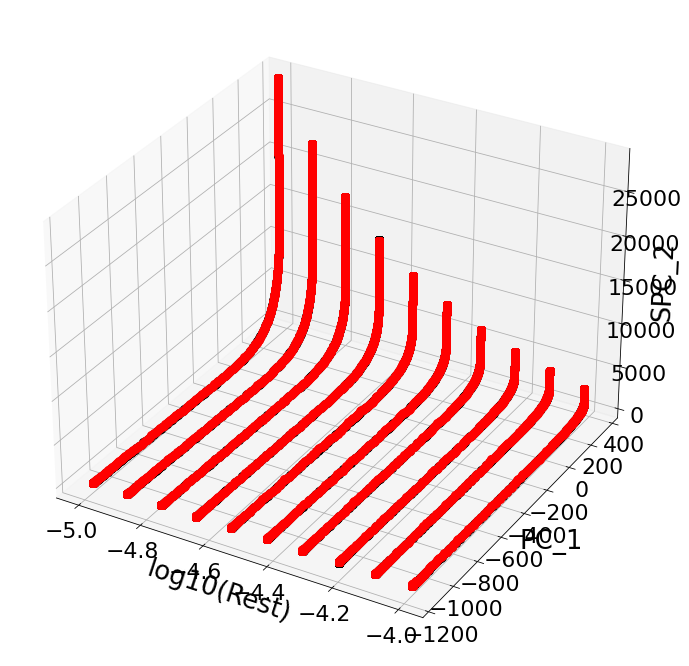

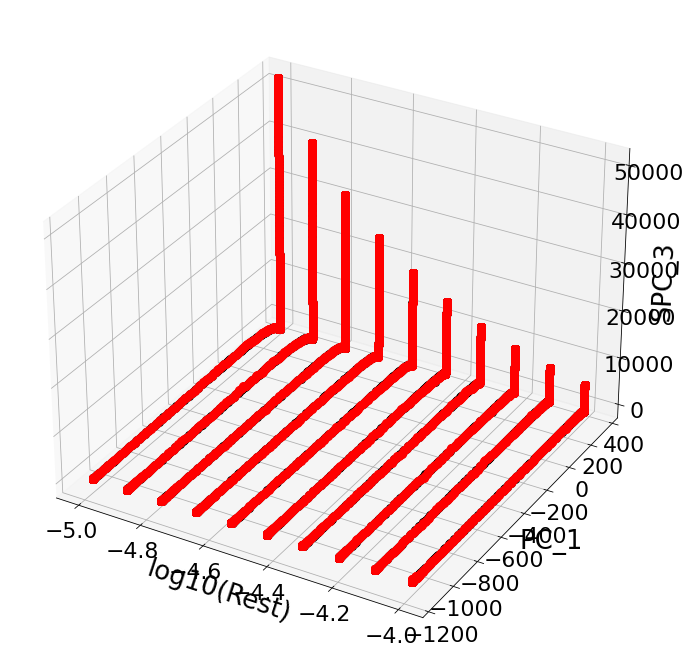

In [11]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax1  = plt.axes(projection='3d')
fig  = plt.figure(figsize=(16,12))
ax2   = plt.axes(projection='3d')
fig  = plt.figure(figsize=(16,12))
ax3   = plt.axes(projection='3d')

ax1.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[TestOutputVars[0]], 'ok',  linewidth=2)
ax2.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[TestOutputVars[1]], 'ok',  linewidth=2)
ax3.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], OutputDF[TestOutputVars[2]], 'ok',  linewidth=2)

for iSample in range(NSamples):
    yMat = PredictFun(InputDF[InputData.InputVars], MinVals, MaxVals)
    
    ax1.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,0], 'or',  linewidth=2)
    ax2.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,1], 'or',  linewidth=2)
    ax3.plot3D(InputDF[InputData.InputVars[0]], InputDF[InputData.InputVars[1]], yMat[:,2], 'or',  linewidth=2)

ax1.set_xlabel(InputData.InputVars[0])
ax1.set_ylabel(InputData.InputVars[1])
ax1.set_zlabel(TestOutputVars[0])

ax2.set_xlabel(InputData.InputVars[0])
ax2.set_ylabel(InputData.InputVars[1])
ax2.set_zlabel(TestOutputVars[1])

ax3.set_xlabel(InputData.InputVars[0])
ax3.set_ylabel(InputData.InputVars[1])
ax3.set_zlabel(TestOutputVars[2])

In [12]:
### Defining Surrogate ODE

def f_NN(t, y):
    print(t)
    yy   = np.concatenate((RestVal, y), axis=0)[np.newaxis,...]
    dydt = PredictFun(yy, MinVals, MaxVals)
    return dydt[0,:]

# def f_NN(t, y):
#     print(t)
#     yy   = y[np.newaxis,...]
#     dydt = PredictFun(yy, MinVals, MaxVals)
#     return dydt[0,:]

RestVal =  [-4.66666667] ; y0_pca =  [ 3.42441839e+02 -1.78877349e-02  2.89325323e-03]
0.0
3.855557023713314e-08
0.0
0.0
0.0
0.0
0.0
0.0
8.80962198655845e-09
8.80962198655845e-09
1.76192439731169e-08
1.76192439731169e-08
1.057154638387014e-07
1.057154638387014e-07
1.057154638387014e-07
1.057154638387014e-07
1.057154638387014e-07
1.057154638387014e-07
1.057154638387014e-07
1.057154638387014e-07
1.057154638387014e-07
1.057154638387014e-07
6.166735390590915e-08
6.166735390590915e-08
6.166735390590915e-08
1.057154638387014e-07
1.057154638387014e-07
1.057154638387014e-07
1.7328871455964486e-07
1.7328871455964486e-07
2.4086196528058833e-07
2.4086196528058833e-07
2.4086196528058833e-07
3.084352160015318e-07
3.084352160015318e-07
3.084352160015318e-07
3.084352160015318e-07
4.98301610249205e-07
4.98301610249205e-07
4.98301610249205e-07
4.98301610249205e-07
4.98301610249205e-07
4.98301610249205e-07
4.98301610249205e-07
4.98301610249205e-07
4.033684131253684e-07
4.033684131253684e-07
3.5590181456

3.295918421807416e-05
3.665189973479188e-05
3.665189973479188e-05
3.665189973479188e-05
4.0344615251509596e-05
4.0344615251509596e-05
4.0344615251509596e-05
4.0344615251509596e-05
4.0344615251509596e-05
4.0344615251509596e-05
4.0344615251509596e-05
4.0344615251509596e-05
4.0344615251509596e-05
3.849825749315074e-05
3.849825749315074e-05
3.757507861397131e-05
3.757507861397131e-05
3.711348917438159e-05
3.711348917438159e-05
3.757507861397131e-05
3.757507861397131e-05
3.8036668053561024e-05
3.8036668053561024e-05
4.265256244945818e-05
4.265256244945818e-05
4.265256244945818e-05
4.265256244945818e-05
4.265256244945818e-05
4.265256244945818e-05
4.265256244945818e-05
4.265256244945818e-05
4.03446152515096e-05
4.03446152515096e-05
3.919064165253531e-05
3.919064165253531e-05
4.03446152515096e-05
4.03446152515096e-05
4.149858885048389e-05
4.149858885048389e-05
4.149858885048389e-05
4.149858885048389e-05
4.149858885048389e-05
4.149858885048389e-05
4.149858885048389e-05
4.149858885048389e-05
4.9

6.668440333188941e-05
6.668440333188941e-05
6.668440333188941e-05
6.668440333188941e-05
6.668440333188941e-05
6.668440333188941e-05
6.541614295108463e-05
6.541614295108463e-05
6.478201276068223e-05
6.478201276068223e-05
6.446494766548104e-05
6.446494766548104e-05
6.478201276068223e-05
6.478201276068223e-05
6.478201276068223e-05
6.478201276068223e-05
6.478201276068223e-05
6.478201276068223e-05
6.478201276068223e-05
6.478201276068223e-05
6.462348021308163e-05
6.462348021308163e-05
6.454421393928134e-05
6.454421393928134e-05
6.462348021308164e-05
6.462348021308164e-05
6.541614295108466e-05
6.541614295108466e-05
6.541614295108466e-05
6.541614295108466e-05
6.541614295108466e-05
6.541614295108466e-05
6.541614295108466e-05
6.541614295108466e-05
6.541614295108466e-05
6.620880568908767e-05
6.620880568908767e-05
7.066600084453434e-05
7.066600084453434e-05
7.066600084453434e-05
7.066600084453434e-05
7.066600084453434e-05
7.066600084453434e-05
7.066600084453434e-05
7.066600084453434e-05
6.84374032

9.143895801692301e-05
9.143895801692301e-05
9.117691281626288e-05
9.117691281626288e-05
9.104589021593281e-05
9.104589021593281e-05
9.117691281626287e-05
9.117691281626287e-05
9.130793541659292e-05
9.130793541659292e-05
9.26181614198935e-05
9.26181614198935e-05
9.26181614198935e-05
9.26181614198935e-05
9.26181614198935e-05
9.26181614198935e-05
9.26181614198935e-05
9.26181614198935e-05
9.26181614198935e-05
9.196304841824321e-05
9.196304841824321e-05
9.26181614198935e-05
9.26181614198935e-05
9.810823328950949e-05
9.810823328950949e-05
9.810823328950949e-05
9.810823328950949e-05
9.810823328950949e-05
9.810823328950949e-05
9.810823328950949e-05
9.810823328950949e-05
9.536319735470148e-05
9.536319735470148e-05
9.399067938729749e-05
9.399067938729749e-05
9.536319735470148e-05
9.536319735470148e-05
9.673571532210548e-05
9.673571532210548e-05
0.00010097961090718834
0.00010097961090718834
0.00010097961090718834
0.00010097961090718834
0.00010097961090718834
0.00010097961090718834
0.0001009796109

0.00013052172647354382
0.00013052172647354382
0.00013084937156449656
0.00013084937156449656
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013248759701926026
0.00013248759701926026
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.00013412582247402397
0.0001417702268123103
0.0001417702268123103
0.0001417702268123103
0.0001417702268123103
0.0001417702268123103
0.0001417702268123103
0.0001417702268123103
0.0001417702268123103
0.00013794802464316713
0.00013794802464316713
0.00013603692355859556
0.00013603692355859556
0.00013794802464316716
0.00013794802464316716
0.00013794802464316716
0.00014695291969291

0.00017427796287277855
0.00017372650512172282
0.00017372650512172282
0.00017345077624619494
0.00017345077624619494
0.0001737265051217228
0.0001737265051217228
0.00017400223399725064
0.00017400223399725064
0.00017675952275252916
0.00017675952275252916
0.00017675952275252916
0.00017675952275252916
0.00017675952275252916
0.00017675952275252916
0.00017675952275252916
0.00017675952275252916
0.00017951681150780768
0.00017951681150780768
0.00018813990363868743
0.00018813990363868743
0.00018813990363868743
0.00018813990363868743
0.00018813990363868743
0.00018813990363868743
0.00018813990363868743
0.00018813990363868743
0.00018813990363868743
0.00018382835757324757
0.00018382835757324757
0.00018167258454052763
0.00018167258454052763
0.00018059469802416767
0.00018059469802416767
0.00018005575476598768
0.00018005575476598768
0.0001797862831368977
0.0001797862831368977
0.0001796515473223527
0.0001796515473223527
0.00017958417941508017
0.00017958417941508017
0.00017965154732235266
0.000179651547322

0.0001979712686518186
0.0001979712686518186
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020040944930998383
0.00020040944930998383
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020284762996814905
0.00020162853963906643
0.00020162853963906643
0.00020284762996814902
0.00020284762996814902
0.0002074595346692409
0.0002074595346692409
0.0002074595346692409
0.0002074595346692409
0.0002074595346692409
0.0002074595346692409
0.0002074595346692409
0.0002074595346692409
0.00020515358231869497
0.00020515358231869497
0.000204000606143422
0.000204000606143422
0.000204000606143422
0.0002034241180557855
0.0002034241180557855
0.0002034241180557855
0.00020

0.00021790816870276286
0.00021790816870276286
0.00021790816870276286
0.00021790816870276286
0.00021790816870276286
0.00021734771956262113
0.00021734771956262113
0.00021706749499255027
0.00021706749499255027
0.00021692738270751483
0.00021692738270751483
0.00021685732656499712
0.00021685732656499712
0.00021682229849373828
0.00021682229849373828
0.00021680478445810884
0.00021680478445810884
0.00021682229849373828
0.00021682229849373828
0.00021699743885003262
0.00021699743885003262
0.00021699743885003262
0.00021699743885003262
0.00021699743885003262
0.00021699743885003262
0.00021699743885003262
0.00021699743885003262
0.00021690986867188545
0.00021690986867188545
0.00021699743885003262
0.00021699743885003262
0.00021699743885003262
0.00021699743885003262
0.00021699743885003262
0.00021699743885003262
0.00021699743885003262
0.00021699743885003262
0.00021695365376095903
0.00021695365376095903
0.00021693176121642224
0.00021693176121642224
0.00021695365376095903
0.00021695365376095903
0.000217172

0.0002687166480501458
0.0002687166480501458
0.0002687249766863992
0.0002687249766863992
0.0002688082630489335
0.0002688082630489335
0.0002688082630489335
0.0002688082630489335
0.0002688082630489335
0.0002688082630489335
0.0002688082630489335
0.0002688082630489335
0.00026889154941146776
0.00026889154941146776
0.00026972441303681053
0.00026972441303681053
0.00026972441303681053
0.00026972441303681053
0.00026972441303681053
0.00026972441303681053
0.00026972441303681053
0.00026972441303681053
0.0002705572766621533
0.0002705572766621533
0.0002747760502045347
0.0002747760502045347
0.0002747760502045347
0.0002747760502045347
0.0002747760502045347
0.0002747760502045347
0.0002747760502045347
0.0002747760502045347
0.00027266666343334404
0.00027266666343334404
0.00027161197004774867
0.00027161197004774867
0.000271084623354951
0.000271084623354951
0.000271084623354951
0.00027082095000855214
0.00027082095000855214
0.0002706891133353527
0.0002706891133353527
0.00027062319499875304
0.0002706231949987

0.0003696118464197066
0.0003696118464197066
0.0003695429553237802
0.0003695429553237802
0.00036961184641970656
0.00036961184641970656
0.0003703007573789702
0.0003703007573789702
0.0003703007573789702
0.0003703007573789702
0.0003703007573789702
0.0003703007573789702
0.0003703007573789702
0.0003703007573789702
0.0003699563018993384
0.0003699563018993384
0.00036978407415952244
0.00036978407415952244
0.00036969796028961453
0.00036969796028961453
0.0003697840741595225
0.0003697840741595225
0.0003706452128586022
0.0003706452128586022
0.0003706452128586022
0.0003706452128586022
0.0003706452128586022
0.0003706452128586022
0.0003706452128586022
0.0003706452128586022
0.0003706452128586022
0.00037021464350906234
0.00037021464350906234
0.00036999935883429245
0.00036999935883429245
0.00036999935883429245
0.0003702146435090624
0.0003702146435090624
0.00037236749025676186
0.00037236749025676186
0.00037236749025676186
0.00037236749025676186
0.00037236749025676186
0.00037236749025676186
0.0003723674902

0.0004015421701779306
0.0003990815893241752
0.0003990815893241752
0.0003978512988972975
0.0003978512988972975
0.00039723615368385864
0.00039723615368385864
0.0003969285810771392
0.0003969285810771392
0.00039677479477377947
0.00039677479477377947
0.00039692858107713916
0.00039692858107713916
0.000398466444110736
0.000398466444110736
0.000398466444110736
0.000398466444110736
0.000398466444110736
0.000398466444110736
0.000398466444110736
0.000398466444110736
0.000398466444110736
0.0004000043071443329
0.0004000043071443329
0.0004000043071443329
0.0004000043071443329
0.0004000043071443329
0.0004000043071443329
0.0004000043071443329
0.0004000043071443329
0.00041538293748030156
0.00041538293748030156
0.00041538293748030156
0.00041538293748030156
0.00041538293748030156
0.00041538293748030156
0.00041538293748030156
0.00041538293748030156
0.0004076936223123172
0.0004076936223123172
0.00040384896472832506
0.00040384896472832506
0.00040384896472832506
0.0004076936223123172
0.0004076936223123172
0.

0.0004883967063147386
0.0004883967063147386
0.0004883967063147386
0.0004883967063147386
0.0004883967063147386
0.0004762667577885791
0.0004762667577885791
0.00047020178352549937
0.00047020178352549937
0.00046716929639395953
0.00046716929639395953
0.0004656530528281896
0.0004656530528281896
0.00046489493104530464
0.00046489493104530464
0.00046451587015386214
0.00046451587015386214
0.0004643263397081409
0.0004643263397081409
0.00046423157448528026
0.00046423157448528026
0.00046418419187384995
0.00046418419187384995
0.00046418419187384995
0.00046423157448528026
0.00046423157448528026
0.00046423157448528026
0.00046423157448528026
0.00046423157448528026
0.00046423157448528026
0.00046423157448528026
0.00046423157448528026
0.0004647054005995834
0.0004647054005995834
0.0004647054005995834
0.0004647054005995834
0.0004647054005995834
0.0004647054005995834
0.0004647054005995834
0.0004647054005995834
0.0004651792267138865
0.0004651792267138865
0.00046991748785691777
0.00046991748785691777
0.0004699

0.0005041776191095805
0.0005083788676460446
0.0005083788676460446
0.0005083788676460446
0.0005083788676460446
0.0005083788676460446
0.0005083788676460446
0.0005083788676460446
0.0005083788676460446
0.0005083788676460446
0.0005062782433778126
0.0005062782433778126
0.0005052279312436965
0.0005052279312436965
0.0005052279312436965
0.0005052279312436965
0.0005047027751766385
0.0005047027751766385
0.0005052279312436964
0.0005052279312436964
0.000510479491914276
0.000510479491914276
0.0005157310525848556
0.0005157310525848556
0.0005157310525848556
0.0005157310525848556
0.0005157310525848556
0.0005157310525848556
0.0005157310525848556
0.0005157310525848556
0.0005440422952384359
0.0005440422952384359
0.0005440422952384359
0.0005440422952384359
0.0005440422952384359
0.0005440422952384359
0.0005440422952384359
0.0005440422952384359
0.0005298866739116457
0.0005298866739116457
0.0005228088632482507
0.0005228088632482507
0.0005192699579165531
0.0005192699579165531
0.0005175005052507043
0.0005175005

0.0005578562039106851
0.0005578562039106851
0.0005578562039106851
0.0005574648755398504
0.0005574648755398504
0.0005572692113544331
0.0005572692113544331
0.0005574648755398505
0.0005574648755398505
0.0005594215173940247
0.0005594215173940247
0.0005594215173940247
0.0005594215173940247
0.0005594215173940247
0.0005594215173940247
0.0005594215173940247
0.0005594215173940247
0.0005584431964669376
0.0005584431964669376
0.0005579540360033941
0.0005579540360033941
0.0005577094557716222
0.0005577094557716222
0.0005577094557716222
0.0005575871656557363
0.0005575871656557363
0.0005575260205977935
0.0005575260205977935
0.0005574954480688219
0.0005574954480688219
0.0005575260205977934
0.0005575260205977934
0.0005578317458875076
0.0005578317458875076
0.0005581374711772219
0.0005581374711772219
0.0005581374711772219
0.0005581374711772219
0.0005581374711772219
0.0005581374711772219
0.0005581374711772219
0.0005581374711772219
0.0005579846085323648
0.0005579846085323648
0.0005579081772099361
0.00055790

0.0007996764616311024
0.0007972646738289813
0.0007972646738289813
0.0007960587799279207
0.0007960587799279207
0.0007954558329773904
0.0007954558329773904
0.0007951543595021253
0.0007951543595021253
0.0007950036227644927
0.0007950036227644927
0.0007950036227644927
0.0007951543595021253
0.0007951543595021253
0.0007953050962397579
0.0007953050962397579
0.0007962153673197665
0.0007962153673197665
0.0007962153673197665
0.0007962153673197665
0.0007962153673197665
0.0007962153673197665
0.0007962153673197665
0.0007962153673197665
0.0007971256383997751
0.0007971256383997751
0.0007971256383997751
0.0007971256383997751
0.0007971256383997751
0.0007971256383997751
0.0007971256383997751
0.0007971256383997751
0.0007971256383997751
0.0007966705028597707
0.0007966705028597707
0.0007964429350897686
0.0007964429350897686
0.0007963291512047676
0.0007963291512047676
0.0007964429350897687
0.0007964429350897687
0.0007975807739397799
0.0007975807739397799
0.0007975807739397799
0.0007975807739397799
0.00079758

0.0008129323986340231
0.0008123752557136739
0.0008123752557136739
0.0008120966842534993
0.0008120966842534993
0.0008119573985234121
0.0008119573985234121
0.0008118877556583684
0.0008118877556583684
0.0008119573985234121
0.0008119573985234121
0.0008126538271738485
0.0008126538271738485
0.0008126538271738485
0.0008126538271738485
0.0008126538271738485
0.0008126538271738485
0.0008126538271738485
0.0008126538271738485
0.0008123056128486303
0.0008123056128486303
0.0008121315056860212
0.0008121315056860212
0.0008120444521047166
0.0008120444521047166
0.0008121315056860211
0.0008121315056860211
0.0008130020414990661
0.0008130020414990661
0.0008130020414990661
0.0008130020414990661
0.0008130020414990661
0.0008130020414990661
0.0008130020414990661
0.0008130020414990661
0.0008138725773121111
0.0008138725773121111
0.0008225779354425612
0.0008225779354425612
0.0008312832935730113
0.0008312832935730113
0.0008710028498033404
0.0008710028498033404
0.0008710028498033404
0.0008710028498033404
0.00087100

0.000861946092306881
0.000861946092306881
0.000861946092306881
0.000861946092306881
0.0008606514820677638
0.0008606514820677638
0.0008600041769482052
0.0008600041769482052
0.0008606514820677638
0.0008606514820677638
0.0008671245332633501
0.0008671245332633501
0.0008671245332633501
0.0008671245332633501
0.0008671245332633501
0.0008671245332633501
0.0008671245332633501
0.0008671245332633501
0.0008671245332633501
0.0008671245332633501
0.0008638880076655569
0.0008638880076655569
0.0008622697448666604
0.0008622697448666604
0.000861460613467212
0.000861460613467212
0.0008610560477674879
0.0008610560477674879
0.0008608537649176258
0.0008608537649176258
0.0008610560477674879
0.0008610560477674879
0.0008630788762661085
0.0008630788762661085
0.0008630788762661085
0.0008630788762661085
0.0008630788762661085
0.0008630788762661085
0.0008630788762661085
0.0008630788762661085
0.0008620674620167982
0.0008620674620167982
0.000861561754892143
0.000861561754892143
0.0008613089013298154
0.0008613089013298

0.0009601403068149745
0.0009612078072871969
0.0009612078072871969
0.0009612078072871969
0.0009612078072871969
0.0009612078072871969
0.0009612078072871969
0.0009612078072871969
0.0009612078072871969
0.0009612078072871969
0.0009612078072871969
0.0009612078072871969
0.0009606740570510858
0.0009606740570510858
0.0009606740570510858
0.000961207807287197
0.000961207807287197
0.0009665453096483093
0.0009665453096483093
0.0009718828120094217
0.0009718828120094217
0.0010035826590955082
0.0010035826590955082
0.0010035826590955082
0.0010035826590955082
0.0010035826590955082
0.0010035826590955082
0.0010035826590955082
0.0010035826590955082
0.0010035826590955082
0.0010035826590955082
0.000987732735552465
0.000987732735552465
0.0009798077737809433
0.0009798077737809433
0.0009758452928951824
0.0009758452928951824
0.0009738640524523021
0.0009738640524523021
0.000972873432230862
0.000972873432230862
0.0009723781221201418
0.0009723781221201418
0.0009721304670647817
0.0009721304670647817
0.00097237812212

0.0010597136910248392
0.0010597136910248392
0.0010597136910248392
0.0010597136910248392
0.0010597136910248392
0.0010597136910248392
0.0010597136910248392
0.0010597136910248392
0.001051264599853958
0.001051264599853958
0.001051264599853958
0.0010470400542685176
0.0010470400542685176
0.0010470400542685176
0.0010449277814757972
0.0010449277814757972
0.001043871645079437
0.001043871645079437
0.001043343576881257
0.001043343576881257
0.001043079542782167
0.001043079542782167
0.001042947525732622
0.001042947525732622
0.0010428815172078493
0.0010428815172078493
0.0010429475257326217
0.0010429475257326217
0.001043607610980346
0.001043607610980346
0.001043607610980346
0.001043607610980346
0.001043607610980346
0.001043607610980346
0.001043607610980346
0.001043607610980346
0.001043607610980346
0.001043607610980346
0.0010432775683564838
0.0010432775683564838
0.0010431125470445528
0.0010431125470445528
0.0010430300363885874
0.0010430300363885874
0.0010429887810606045
0.0010429887810606045
0.0010430

0.0012207617973161106
0.0012207617973161106
0.0012207617973161106
0.0012207617973161106
0.0012207617973161106
0.0012204023646658498
0.0012204023646658498
0.0012202226483407196
0.0012202226483407196
0.00122040236466585
0.00122040236466585
0.00122040236466585
0.00122040236466585
0.00122040236466585
0.00122040236466585
0.00122040236466585
0.00122040236466585
0.00122040236466585
0.00122040236466585
0.00122040236466585
0.001220312506503285
0.001220312506503285
0.0012202675774220023
0.0012202675774220023
0.001220245112881361
0.001220245112881361
0.0012202675774220023
0.0012202675774220023
0.0012204922228284155
0.0012204922228284155
0.0012204922228284155
0.0012204922228284155
0.0012204922228284155
0.0012204922228284155
0.0012204922228284155
0.0012204922228284155
0.0012204922228284155
0.0012204922228284155
0.001220379900125209
0.001220379900125209
0.0012204922228284155
0.0012204922228284155
0.0012204922228284155
0.0012204922228284155
0.0012204922228284155
0.0012204922228284155
0.00122049222282

0.001303655777616539
0.001303655777616539
0.001303655777616539
0.001303655777616539
0.001303655777616539
0.001303655777616539
0.001303655777616539
0.0013036236445556838
0.0013036236445556838
0.001303655777616539
0.001303655777616539
0.0013039771082250906
0.0013039771082250906
0.0013042984388336421
0.0013042984388336421
0.0013075117449191577
0.0013075117449191577
0.0013107250510046734
0.0013107250510046734
0.001321349551686511
0.001321349551686511
0.001321349551686511
0.001321349551686511
0.001321349551686511
0.001321349551686511
0.001321349551686511
0.001321349551686511
0.001321349551686511
0.001321349551686511
0.001321349551686511
0.001316037301345592
0.001316037301345592
0.0013133811761751328
0.0013133811761751328
0.0013120531135899032
0.0013120531135899032
0.0013113890822972884
0.0013113890822972884
0.0013110570666509808
0.0013110570666509808
0.001310891058827827
0.001310891058827827
0.001310891058827827
0.0013110570666509805
0.0013110570666509805
0.0013112230744741341
0.00131122307

0.0013285264427868877
0.0013271862665339622
0.0013271862665339622
0.0013265161784074995
0.0013265161784074995
0.0013261811343442682
0.0013261811343442682
0.0013260136123126524
0.0013260136123126524
0.001326181134344268
0.001326181134344268
0.0013263486563758835
0.0013263486563758835
0.001328023876692039
0.001328023876692039
0.0013296990970081946
0.0013296990970081946
0.00134645130016975
0.00134645130016975
0.0013632035033313054
0.0013632035033313054
0.0013632035033313054
0.0013632035033313054
0.0013632035033313054
0.0013632035033313054
0.0013632035033313054
0.0013632035033313054
0.0013632035033313054
0.0013632035033313054
0.0013548274017505277
0.0013548274017505277
0.0013506393509601388
0.0013506393509601388
0.0013485453255649444
0.0013485453255649444
0.0013474983128673472
0.0013474983128673472
0.0013469748065185485
0.0013469748065185485
0.0013467130533441492
0.0013467130533441492
0.0013465821767569496
0.0013465821767569496
0.0013465167384633498
0.0013465167384633498
0.0013465821767569

0.0014204874708722724
0.0014204874708722724
0.0014204874708722724
0.0014204874708722724
0.001417865800610493
0.001417865800610493
0.0014165549654796034
0.0014165549654796034
0.0014158995479141585
0.0014158995479141585
0.001415571839131436
0.001415571839131436
0.0014154079847400747
0.0014154079847400747
0.0014153260575443941
0.0014153260575443941
0.0014152850939465537
0.0014152850939465537
0.001415326057544394
0.001415326057544394
0.0014157356935227956
0.0014157356935227956
0.0014157356935227956
0.0014157356935227956
0.0014157356935227956
0.0014157356935227956
0.0014157356935227956
0.0014157356935227956
0.0014157356935227956
0.0014157356935227956
0.0014161453295011973
0.0014161453295011973
0.0014202416892852144
0.0014202416892852144
0.0014202416892852144
0.0014202416892852144
0.0014202416892852144
0.0014202416892852144
0.0014202416892852144
0.0014202416892852144
0.0014202416892852144
0.0014181935093932059
0.0014181935093932059
0.0014171694194472016
0.0014171694194472016
0.00141665737447

0.0014942808227095834
0.0014942808227095834
0.0014942808227095834
0.0014942808227095834
0.0014942808227095834
0.0014942808227095834
0.0014942808227095834
0.0014942808227095834
0.0014942808227095834
0.0014921243235738093
0.0014921243235738093
0.0014921243235738093
0.0014942808227095834
0.0014942808227095834
0.001515845814067324
0.001515845814067324
0.001515845814067324
0.001515845814067324
0.001515845814067324
0.001515845814067324
0.001515845814067324
0.001515845814067324
0.001515845814067324
0.001515845814067324
0.0015050633183884537
0.0015050633183884537
0.0014996720705490185
0.0014996720705490185
0.001496976446629301
0.001496976446629301
0.0014956286346694421
0.0014956286346694421
0.0014949547286895128
0.0014949547286895128
0.0014946177756995482
0.0014946177756995482
0.0014946177756995482
0.001494954728689513
0.001494954728689513
0.001494954728689513
0.001494954728689513
0.001494954728689513
0.001494954728689513
0.001494954728689513
0.001494954728689513
0.001494954728689513
0.0014947

0.0016196772650639989
0.0016196772650639989
0.0016196772650639989
0.0016192576881051864
0.0016192576881051864
0.00161904789962578
0.00161904789962578
0.0016189430053860769
0.0016189430053860769
0.0016190478996257799
0.0016190478996257799
0.00162009684202281
0.00162009684202281
0.00162009684202281
0.00162009684202281
0.00162009684202281
0.00162009684202281
0.00162009684202281
0.00162009684202281
0.00162009684202281
0.001619572370824295
0.001619572370824295
0.0016193101352250374
0.0016193101352250374
0.0016191790174254087
0.0016191790174254087
0.0016191134585255944
0.0016191134585255944
0.0016190806790756871
0.0016190806790756871
0.0016191134585255944
0.0016191134585255944
0.0016194412530246669
0.0016194412530246669
0.0016194412530246669
0.0016194412530246669
0.0016194412530246669
0.0016194412530246669
0.0016194412530246669
0.0016194412530246669
0.0016194412530246669
0.0016192773557751306
0.0016192773557751306
0.0016191954071503624
0.0016191954071503624
0.0016192773557751304
0.0016192773

0.0016585365882119782
0.0016585365882119782
0.0016585365882119782
0.0016585365882119782
0.0016585365882119782
0.0016585365882119782
0.0016582654104970898
0.0016582654104970898
0.0016581298216396456
0.0016581298216396456
0.0016582654104970898
0.0016582654104970898
0.0016596212990715319
0.0016596212990715319
0.0016596212990715319
0.0016596212990715319
0.0016596212990715319
0.0016596212990715319
0.0016596212990715319
0.0016596212990715319
0.0016589433547843108
0.0016589433547843108
0.0016586043826407003
0.0016586043826407003
0.001658434896568895
0.001658434896568895
0.0016583501535329924
0.0016583501535329924
0.0016583077820150412
0.0016583077820150412
0.0016583501535329926
0.0016583501535329926
0.0016587738687125065
0.0016587738687125065
0.0016587738687125065
0.0016587738687125065
0.0016587738687125065
0.0016587738687125065
0.0016587738687125065
0.0016587738687125065
0.0016587738687125065
0.0016587738687125065
0.0016587738687125065
0.0016585620111227496
0.0016585620111227496
0.0016587738

0.0017065219594976976
0.0017065219594976976
0.0017070462370718969
0.0017070462370718969
0.0017070462370718969
0.0017070462370718969
0.0017070462370718969
0.0017070462370718969
0.0017070462370718969
0.0017070462370718969
0.0017070462370718969
0.0017067840982847972
0.0017067840982847972
0.0017066530288912473
0.0017066530288912473
0.0017065874941944725
0.0017065874941944725
0.001706554726846085
0.001706554726846085
0.0017065874941944723
0.0017065874941944723
0.001706915167678346
0.001706915167678346
0.001706915167678346
0.001706915167678346
0.001706915167678346
0.001706915167678346
0.001706915167678346
0.001706915167678346
0.0017072428411622198
0.0017072428411622198
0.0017102574929425594
0.0017102574929425594
0.0017102574929425594
0.0017102574929425594
0.0017102574929425594
0.0017102574929425594
0.0017102574929425594
0.0017102574929425594
0.0017087501670523895
0.0017087501670523895
0.0017102574929425591
0.0017102574929425591
0.0017102574929425591
0.0017102574929425591
0.001710257492942559

0.00173129605580535
0.00173129605580535
0.0017309886942716117
0.0017309886942716117
0.0017308350135047425
0.0017308350135047425
0.0017307581731213079
0.0017307581731213079
0.0017307197529295906
0.0017307197529295906
0.001730700542833732
0.001730700542833732
0.0017307197529295906
0.0017307197529295906
0.001730911853888177
0.001730911853888177
0.001730911853888177
0.001730911853888177
0.001730911853888177
0.001730911853888177
0.001730911853888177
0.001730911853888177
0.0017311039548467636
0.0017311039548467636
0.001733024964432629
0.001733024964432629
0.0017349459740184942
0.0017349459740184942
0.0017541560698771472
0.0017541560698771472
0.0017541560698771472
0.0017541560698771472
0.0017541560698771472
0.0017541560698771472
0.0017541560698771472
0.0017541560698771472
0.0017541560698771472
0.0017541560698771472
0.0017445510219478207
0.0017445510219478207
0.0017397484979831575
0.0017397484979831575
0.0017373472360008258
0.0017373472360008258
0.0017397484979831575
0.0017397484979831575
0.00

0.0018990544396754404
0.0018990544396754404
0.001899014167579937
0.001899014167579937
0.0018989940315321855
0.0018989940315321855
0.0018990141675799372
0.0018990141675799372
0.0018992155280574544
0.0018992155280574544
0.0018992155280574544
0.0018992155280574544
0.0018992155280574544
0.0018992155280574544
0.0018992155280574544
0.0018992155280574544
0.0018991148478186958
0.0018991148478186958
0.0018990645076993164
0.0018990645076993164
0.0018991148478186956
0.0018991148478186956
0.0018996182490124875
0.0018996182490124875
0.0018996182490124875
0.0018996182490124875
0.0018996182490124875
0.0018996182490124875
0.0018996182490124875
0.0018996182490124875
0.0018993665484155916
0.0018993665484155916
0.0018992406981171435
0.0018992406981171435
0.0018991777729679194
0.0018991777729679194
0.0018992406981171433
0.0018992406981171433
0.0018998699496093816
0.0018998699496093816
0.0018998699496093816
0.0018998699496093816
0.0018998699496093816
0.0018998699496093816
0.0018998699496093816
0.0018998699

0.0019465177815757013
0.0019465177815757013
0.0019465177815757013
0.0019473261113615117
0.0019473261113615117
0.001955409409219615
0.001955409409219615
0.001955409409219615
0.001955409409219615
0.001955409409219615
0.001955409409219615
0.001955409409219615
0.001955409409219615
0.0019634927070777187
0.0019634927070777187
0.0019634927070777187
0.0019634927070777187
0.0019634927070777187
0.0019634927070777187
0.0019634927070777187
0.0019634927070777187
0.0019634927070777187
0.0019634927070777187
0.001959451058148667
0.001959451058148667
0.001957430233684141
0.001957430233684141
0.001956419821451878
0.001956419821451878
0.0019559146153357463
0.0019559146153357463
0.001955662012277681
0.001955662012277681
0.001955535710748648
0.001955535710748648
0.0019554725599841317
0.0019554725599841317
0.0019555357107486483
0.0019555357107486483
0.001956167218393814
0.001956167218393814
0.001956167218393814
0.001956167218393814
0.001956167218393814
0.001956167218393814
0.001956167218393814
0.00195616721

0.002204177778040883
0.002204177778040883
0.002204177778040883
0.002204177778040883
0.0022035935130077467
0.0022035935130077467
0.002203301380491179
0.002203301380491179
0.002203155314232895
0.002203155314232895
0.0022030822811037526
0.0022030822811037526
0.0022031553142328945
0.0022031553142328945
0.002203885645524314
0.002203885645524314
0.002203885645524314
0.002203885645524314
0.002203885645524314
0.002203885645524314
0.002203885645524314
0.002203885645524314
0.002203885645524314
0.002203885645524314
0.002203885645524314
0.0022035204798786043
0.0022035204798786043
0.002203885645524314
0.002203885645524314
0.0022075373019814124
0.0022075373019814124
0.0022075373019814124
0.0022075373019814124
0.0022075373019814124
0.0022075373019814124
0.0022075373019814124
0.0022075373019814124
0.0022075373019814124
0.0022075373019814124
0.0022075373019814124
0.0022057114737528633
0.0022057114737528633
0.002204798559638589
0.002204798559638589
0.0022043421025814518
0.0022043421025814518
0.002204113

0.0022315383933708215
0.0022313712206587233
0.0022313712206587233
0.002231538393370821
0.002231538393370821
0.002233210120491799
0.002233210120491799
0.002233210120491799
0.002233210120491799
0.002233210120491799
0.002233210120491799
0.002233210120491799
0.002233210120491799
0.002233210120491799
0.00223237425693131
0.00223237425693131
0.0022319563251510656
0.0022319563251510656
0.002231747359260943
0.002231747359260943
0.002231642876315882
0.002231642876315882
0.002231747359260943
0.002231747359260943
0.0022327921887115533
0.0022327921887115533
0.0022327921887115533
0.0022327921887115533
0.0022327921887115533
0.0022327921887115533
0.0022327921887115533
0.0022327921887115533
0.0022327921887115533
0.0022327921887115533
0.0022338370181621634
0.0022338370181621634
0.002244285312668265
0.002244285312668265
0.0022547336071743664
0.0022547336071743664
0.0022547336071743664
0.0022547336071743664
0.0022547336071743664
0.0022547336071743664
0.0022547336071743664
0.0022547336071743664
0.002254733

0.0024923705587394603
0.0024923705587394603
0.0024923705587394603
0.0024923705587394603
0.0025061689301693257
0.0025061689301693257
0.0026441526444679793
0.0026441526444679793
0.002782136358766633
0.002782136358766633
0.002937219779791678
0.002937219779791678
0.003092303200816723
0.003092303200816723
0.003092303200816723
0.003092303200816723
0.003092303200816723
0.003092303200816723
0.003092303200816723
0.003092303200816723
0.003092303200816723
0.003092303200816723
0.0030147614903042004
0.0030147614903042004
0.002975990635047939
0.002975990635047939
0.0029566052074198085
0.0029566052074198085
0.0029469124936057434
0.0029469124936057434
0.0029420661366987106
0.0029420661366987106
0.0029396429582451943
0.0029396429582451943
0.002938431369018436
0.002938431369018436
0.002938431369018436
0.002938431369018436
0.0029396429582451943
0.0029396429582451943
0.0029396429582451943
0.0029396429582451943
0.0029408545474719524
0.0029408545474719524
0.0029408545474719524
0.0029408545474719524
0.002942

0.002965790522951627
0.002965790522951627
0.0029656317818559106
0.0029656317818559106
0.0029655524113080525
0.0029655524113080525
0.0029655127260341235
0.0029655127260341235
0.0029655524113080525
0.0029655524113080525
0.002965949264047343
0.002965949264047343
0.002965949264047343
0.002965949264047343
0.002965949264047343
0.002965949264047343
0.002965949264047343
0.002965949264047343
0.002965949264047343
0.0029657508376776977
0.0029657508376776977
0.002965651624492875
0.002965651624492875
0.0029656020179004636
0.0029656020179004636
0.0029656516244928747
0.0029656516244928747
0.0029661476904169854
0.0029661476904169854
0.0029661476904169854
0.0029661476904169854
0.0029661476904169854
0.0029661476904169854
0.0029661476904169854
0.0029661476904169854
0.0029661476904169854
0.0029666437563410962
0.0029666437563410962
0.0029666437563410962
0.0029666437563410962
0.0029666437563410962
0.0029666437563410962
0.0029666437563410962
0.0029666437563410962
0.0029666437563410962
0.002966395723379041
0.

0.0030279679985036794
0.0030279679985036794
0.0030299983990706705
0.0030299983990706705
0.0030299983990706705
0.0030467985100562384
0.0030467985100562384
0.0030467985100562384
0.0030467985100562384
0.0030467985100562384
0.0030467985100562384
0.0030467985100562384
0.0030467985100562384
0.0030467985100562384
0.0030383984545634545
0.0030383984545634545
0.0030341984268170627
0.0030341984268170627
0.0030320984129438666
0.0030320984129438666
0.0030310484060072683
0.0030310484060072683
0.0030310484060072683
0.0030305234025389694
0.0030305234025389694
0.00303026090080482
0.00303026090080482
0.0030301296499377454
0.0030301296499377454
0.003030064024504208
0.003030064024504208
0.0030301296499377454
0.0030301296499377454
0.00303078590427312
0.00303078590427312
0.00303078590427312
0.00303078590427312
0.00303078590427312
0.00303078590427312
0.00303078590427312
0.00303078590427312
0.00303078590427312
0.003031442158608495
0.003031442158608495
0.003038004701962242
0.003038004701962242
0.00303800470196

0.0031260863615959877
0.0031260863615959877
0.0031260863615959877
0.0031260863615959877
0.0031260863615959877
0.0031260863615959877
0.0031260863615959877
0.003128573068627684
0.003128573068627684
0.0031310597756593807
0.0031310597756593807
0.003155926845976346
0.003155926845976346
0.0031807939162933115
0.0031807939162933115
0.0031807939162933115
0.0031807939162933115
0.0031807939162933115
0.0031807939162933115
0.0031807939162933115
0.0031807939162933115
0.0031807939162933115
0.0031807939162933115
0.0031807939162933115
0.003168360381134829
0.003168360381134829
0.0031621436135555875
0.0031621436135555875
0.003159035229765967
0.003159035229765967
0.0031574810378711565
0.0031574810378711565
0.003156703941923751
0.003156703941923751
0.0031563153939500486
0.0031563153939500486
0.0031561211199631974
0.0031561211199631974
0.0031561211199631974
0.0031563153939500486
0.0031563153939500486
0.003158258133818561
0.003158258133818561
0.003158258133818561
0.003158258133818561
0.003158258133818561
0.0

0.0032193868297893374
0.0032193868297893374
0.0032191998930812945
0.0032191998930812945
0.0032191064247272727
0.0032191064247272727
0.0032190596905502617
0.0032190596905502617
0.0032191064247272722
0.0032191064247272722
0.003219573766497377
0.003219573766497377
0.003219573766497377
0.003219573766497377
0.003219573766497377
0.003219573766497377
0.003219573766497377
0.003219573766497377
0.003219573766497377
0.003220041108267482
0.003220041108267482
0.0032247145259685314
0.0032247145259685314
0.0032247145259685314
0.0032247145259685314
0.0032247145259685314
0.0032247145259685314
0.0032247145259685314
0.0032247145259685314
0.0032247145259685314
0.0032223778171180067
0.0032223778171180067
0.0032212094626927444
0.0032212094626927444
0.003220625285480113
0.003220625285480113
0.0032203331968737973
0.0032203331968737973
0.0032206252854801126
0.0032206252854801126
0.0032206252854801126
0.0032206252854801126
0.0032206252854801126
0.0032206252854801126
0.0032206252854801126
0.0032206252854801126
0

0.0033982997882268063
0.0033982997882268063
0.0033982997882268063
0.0033982997882268063
0.0033982997882268063
0.0033982997882268063
0.003396216671901202
0.003396216671901202
0.0033951751137384
0.0033951751137384
0.0033946543346569987
0.0033946543346569987
0.0033946543346569987
0.0033943939451162985
0.0033943939451162985
0.003394654334656999
0.003394654334656999
0.003394654334656999
0.003394654334656999
0.003394654334656999
0.003394654334656999
0.003394654334656999
0.003394654334656999
0.003397258230064006
0.003397258230064006
0.003397258230064006
0.003397258230064006
0.003397258230064006
0.003397258230064006
0.003397258230064006
0.003397258230064006
0.003397258230064006
0.0033959562823605025
0.0033959562823605025
0.003395305308508751
0.003395305308508751
0.003394979821582875
0.003394979821582875
0.0033948170781199372
0.0033948170781199372
0.003394735706388468
0.003394735706388468
0.0033946950205227333
0.0033946950205227333
0.0033946746775898665
0.0033946746775898665
0.00339466450612343

0.003412970204865007
0.003412970204865007
0.00341240435333973
0.00341240435333973
0.0034129702048650064
0.0034129702048650064
0.0034186287201177726
0.0034186287201177726
0.0034186287201177726
0.0034186287201177726
0.0034186287201177726
0.0034186287201177726
0.0034186287201177726
0.0034186287201177726
0.0034186287201177726
0.003424287235370539
0.003424287235370539
0.003424287235370539
0.003424287235370539
0.003424287235370539
0.003424287235370539
0.003424287235370539
0.003424287235370539
0.0034214579777441557
0.0034214579777441557
0.003420043348930964
0.003420043348930964
0.0034193360345243684
0.0034193360345243684
0.0034189823773210703
0.0034189823773210703
0.003419336034524368
0.003419336034524368
0.003419336034524368
0.003419336034524368
0.003419336034524368
0.003419336034524368
0.003419336034524368
0.003419336034524368
0.003419336034524368
0.003419336034524368
0.003419159205922719
0.003419159205922719
0.0034190707916218945
0.0034190707916218945
0.0034190265844714824
0.00341902658447

0.0038119660481999765
0.0038119660481999765
0.0038118154953948463
0.0038118154953948463
0.003811740218992281
0.003811740218992281
0.0038118154953948463
0.0038118154953948463
0.0038125682594204995
0.0038125682594204995
0.0038125682594204995
0.0038125682594204995
0.0038125682594204995
0.0038125682594204995
0.0038125682594204995
0.0038125682594204995
0.0038125682594204995
0.0038125682594204995
0.0038125682594204995
0.0038125682594204995
0.003812191877407673
0.003812191877407673
0.0038120036864012596
0.0038120036864012596
0.003811909590898053
0.003811909590898053
0.00381200368640126
0.00381200368640126
0.0038129446414333287
0.0038129446414333287
0.0038138855964653974
0.0038138855964653974
0.0038138855964653974
0.0038138855964653974
0.0038138855964653974
0.0038138855964653974
0.0038138855964653974
0.0038138855964653974
0.0038138855964653974
0.0038138855964653974
0.003813415118949363
0.003813415118949363
0.003813179880191346
0.003813179880191346
0.003813415118949363
0.003813415118949363
0.00

0.0039632026107033844
0.0039632026107033844
0.0039632026107033844
0.0039632026107033844
0.0039632026107033844
0.0039632026107033844
0.003955301812400503
0.003955301812400503
0.003951351413249062
0.003951351413249062
0.003949376213673342
0.003949376213673342
0.003948388613885482
0.003948388613885482
0.003947894813991552
0.003947894813991552
0.003947647914044587
0.003947647914044587
0.0039475244640711045
0.0039475244640711045
0.003947462739084364
0.003947462739084364
0.003947524464071105
0.003947524464071105
0.003948141713938522
0.003948141713938522
0.003948141713938522
0.003948141713938522
0.003948141713938522
0.003948141713938522
0.003948141713938522
0.003948141713938522
0.003948141713938522
0.003948141713938522
0.003948141713938522
0.003948758963805938
0.003948758963805938
0.003954931462480101
0.003954931462480101
0.003961103961154264
0.003961103961154264
0.003961103961154264
0.003961103961154264
0.003961103961154264
0.003961103961154264
0.003961103961154264
0.003961103961154264
0.003

0.004006254630762618
0.004006254630762618
0.004006254630762618
0.004006254630762618
0.004006254630762618
0.004006254630762618
0.004006254630762618
0.004004614148663561
0.004004614148663561
0.004003793907614031
0.004003793907614031
0.004003383787089266
0.004003383787089266
0.004003178726826885
0.004003178726826885
0.004003076196695694
0.004003076196695694
0.004003024931630099
0.004003024931630099
0.004003024931630099
0.004003024931630099
0.004003076196695695
0.004003076196695695
0.004003588847351657
0.004003588847351657
0.004003588847351657
0.004003588847351657
0.004003588847351657
0.004003588847351657
0.004003588847351657
0.004003588847351657
0.004003588847351657
0.004003588847351657
0.004003332522023676
0.004003332522023676
0.004003204359359686
0.004003204359359686
0.00400314027802769
0.00400314027802769
0.004003204359359685
0.004003204359359685
0.004003845172679636
0.004003845172679636
0.004003845172679636
0.004003845172679636
0.004003845172679636
0.004003845172679636
0.0040038451726

0.004073426841611447
0.004073426841611447
0.004073426841611447
0.004073426841611447
0.004073426841611447
0.004073426841611447
0.004073426841611447
0.004073426841611447
0.004074834172316249
0.004074834172316249
0.004085571842495617
0.004085571842495617
0.004085571842495617
0.004085571842495617
0.004085571842495617
0.004085571842495617
0.004085571842495617
0.004085571842495617
0.004085571842495617
0.004085571842495617
0.004080203007405933
0.004080203007405933
0.004085571842495616
0.004085571842495616
0.004085571842495616
0.004085571842495616
0.004085571842495616
0.004085571842495616
0.004085571842495616
0.004085571842495616
0.004085571842495616
0.004085571842495616
0.004085571842495616
0.0040828874249507745
0.0040828874249507745
0.004081545216178354
0.004081545216178354
0.004080874111792143
0.004080874111792143
0.004080538559599038
0.004080538559599038
0.004080370783502485
0.004080370783502485
0.004080286895454209
0.004080286895454209
0.00408024495143007
0.00408024495143007
0.00408028689

0.004320566662231028
0.0043204839504162925
0.0043204839504162925
0.004320442594508924
0.004320442594508924
0.004320483950416292
0.004320483950416292
0.0043205253063236596
0.0043205253063236596
0.004320938865397339
0.004320938865397339
0.004320938865397339
0.004320938865397339
0.004320938865397339
0.004320938865397339
0.004320938865397339
0.004320938865397339
0.004320938865397339
0.004320938865397339
0.004321352424471018
0.004321352424471018
0.00432548801520781
0.00432548801520781
0.004329623605944601
0.004329623605944601
0.004365444181258813
0.004365444181258813
0.004365444181258813
0.004365444181258813
0.004365444181258813
0.004365444181258813
0.004365444181258813
0.004365444181258813
0.004365444181258813
0.004365444181258813
0.004347533893601707
0.004347533893601707
0.004338578749773154
0.004338578749773154
0.004334101177858878
0.004334101177858878
0.004331862391901739
0.004331862391901739
0.00433074299892317
0.00433074299892317
0.004331862391901739
0.004331862391901739
0.00434305632

0.0045578025999452225
0.0045578025999452225
0.0045578025999452225
0.0045578025999452225
0.0045578025999452225
0.0045578025999452225
0.0045578025999452225
0.0045578025999452225
0.0045578025999452225
0.0045578025999452225
0.0045578025999452225
0.004557090325016137
0.004557090325016137
0.004556734187551594
0.004556734187551594
0.004557090325016136
0.004557090325016136
0.004560651699661559
0.004560651699661559
0.004560651699661559
0.004560651699661559
0.004560651699661559
0.004560651699661559
0.004560651699661559
0.004560651699661559
0.004560651699661559
0.004560651699661559
0.004560651699661559
0.0045642130743069826
0.0045642130743069826
0.004573539976142892
0.004573539976142892
0.004582866877978801
0.004582866877978801
0.004582866877978801
0.004582866877978801
0.004582866877978801
0.004582866877978801
0.004582866877978801
0.004582866877978801
0.004582866877978801
0.004582866877978801
0.004582866877978801
0.004578203427060846
0.004578203427060846
0.004575871701601869
0.004575871701601869


0.004691145559776835
0.004691145559776835
0.004691145559776835
0.004691145559776835
0.004691145559776835
0.004691145559776835
0.004691145559776835
0.004691145559776835
0.004691145559776835
0.0046875784850592215
0.0046875784850592215
0.004685794947700415
0.004685794947700415
0.004684903179021011
0.004684903179021011
0.00468445729468131
0.00468445729468131
0.004684234352511459
0.004684234352511459
0.004684122881426533
0.004684122881426533
0.0046840671458840705
0.0046840671458840705
0.004684039278112839
0.004684039278112839
0.0046840671458840705
0.0046840671458840705
0.004684345823596383
0.004684345823596383
0.004684345823596383
0.004684345823596383
0.004684345823596383
0.004684345823596383
0.004684345823596383
0.004684345823596383
0.004684206484740227
0.004684206484740227
0.004684136815312149
0.004684136815312149
0.004684101980598109
0.004684101980598109
0.004684136815312148
0.004684136815312148
0.0046844851624525344
0.0046844851624525344
0.0046844851624525344
0.0046844851624525344
0.004

0.004787293504067268
0.004787293504067268
0.004787293504067268
0.004787293504067268
0.004787293504067268
0.004787293504067268
0.004787293504067268
0.004787293504067268
0.004787293504067268
0.004787293504067268
0.004787293504067268
0.004783639414339964
0.004783639414339964
0.004781812369476312
0.004781812369476312
0.004780898847044486
0.004780898847044486
0.004780442085828573
0.004780442085828573
0.0047802137052206164
0.0047802137052206164
0.004780099514916638
0.004780099514916638
0.0047802137052206164
0.0047802137052206164
0.004780327895524595
0.004780327895524595
0.004781469798564376
0.004781469798564376
0.004781469798564376
0.004781469798564376
0.004781469798564376
0.004781469798564376
0.004781469798564376
0.004781469798564376
0.004781469798564376
0.004780898847044485
0.004780898847044485
0.004781469798564376
0.004781469798564376
0.0047871793137632835
0.0047871793137632835
0.0047871793137632835
0.0047871793137632835
0.0047871793137632835
0.0047871793137632835
0.0047871793137632835
0.

0.004792172364540947
0.004792133295844441
0.004792133295844441
0.004792172364540947
0.004792172364540947
0.004792563051506009
0.004792563051506009
0.004792563051506009
0.004792563051506009
0.004792563051506009
0.004792563051506009
0.004792563051506009
0.004792563051506009
0.004792563051506009
0.004792563051506009
0.004792563051506009
0.004792367708023478
0.004792367708023478
0.004792270036282213
0.004792270036282213
0.004792367708023479
0.004792367708023479
0.004793344425436139
0.004793344425436139
0.004793344425436139
0.004793344425436139
0.004793344425436139
0.004793344425436139
0.004793344425436139
0.004793344425436139
0.004793344425436139
0.004793344425436139
0.004793344425436139
0.004792856066729809
0.004792856066729809
0.004792611887376644
0.004792611887376644
0.004792489797700061
0.004792489797700061
0.00479242875286177
0.00479242875286177
0.004792398230442625
0.004792398230442625
0.004792428752861771
0.004792428752861771
0.00479273397705323
0.00479273397705323
0.004792733977053

0.004858238157235578
0.004857499745774863
0.004857499745774863
0.004857130540044505
0.004857130540044505
0.004856945937179327
0.004856945937179327
0.004856853635746738
0.004856853635746738
0.004856807485030442
0.004856807485030442
0.004856853635746737
0.004856853635746737
0.004857315142909682
0.004857315142909682
0.004857315142909682
0.004857315142909682
0.004857315142909682
0.004857315142909682
0.004857315142909682
0.004857315142909682
0.004857776650072628
0.004857776650072628
0.004857776650072628
0.004857776650072628
0.004857776650072628
0.004857776650072628
0.004857776650072628
0.004857776650072628
0.004857776650072628
0.004862391721702083
0.004862391721702083
0.004867006793331539
0.004867006793331539
0.004867006793331539
0.004867006793331539
0.004867006793331539
0.004867006793331539
0.004867006793331539
0.004867006793331539
0.004867006793331539
0.004867006793331539
0.004864699257516811
0.004864699257516811
0.004863545489609447
0.004863545489609447
0.004862968605655766
0.00486296860

0.004931903602019115
0.004931903602019115
0.004931903602019115
0.004931903602019115
0.004931903602019115
0.004931903602019115
0.004931903602019115
0.004931903602019115
0.004929753575852658
0.004929753575852658
0.004928678562769431
0.004928678562769431
0.004928141056227816
0.004928141056227816
0.004928678562769431
0.004928678562769431
0.004934053628185574
0.004934053628185574
0.004934053628185574
0.004934053628185574
0.004934053628185574
0.004934053628185574
0.004934053628185574
0.004934053628185574
0.004934053628185574
0.004931366095477502
0.004931366095477502
0.004934053628185574
0.004934053628185574
0.004959765637286831
0.004959765637286831
0.004959765637286831
0.004959765637286831
0.004959765637286831
0.004959765637286831
0.004959765637286831
0.004959765637286831
0.004959765637286831
0.004959765637286831
0.004959765637286831
0.004946909632736202
0.004946909632736202
0.004940481630460888
0.004940481630460888
0.004946909632736203
0.004946909632736203
0.0050111896554893495
0.0050111896

0.005052572183641772
0.00505279519977079
0.00505279519977079
0.00505279519977079
0.00505279519977079
0.00505279519977079
0.00505279519977079
0.00505279519977079
0.00505279519977079
0.00505279519977079
0.005052683691706281
0.005052683691706281
0.005052795199770791
0.005052795199770791
0.005053910280415885
0.005053910280415885
0.005053910280415885
0.005053910280415885
0.005053910280415885
0.005053910280415885
0.005053910280415885
0.005053910280415885
0.005053910280415885
0.005053352740093338
0.005053352740093338
0.005053352740093338
0.005053073969932064
0.005053073969932064
0.005053352740093338
0.005053352740093338
0.005056140441706073
0.005056140441706073
0.005056140441706073
0.005056140441706073
0.005056140441706073
0.005056140441706073
0.005056140441706073
0.005056140441706073
0.005056140441706073
0.005054746590899706
0.005054746590899706
0.005054049665496522
0.005054049665496522
0.00505370120279493
0.00505370120279493
0.005053526971444134
0.005053526971444134
0.005053439855768736
0.0

0.005089815153946735
0.005087058858235208
0.005087058858235208
0.005087058858235208
0.005087058858235208
0.005089815153946735
0.005089815153946735
0.005117378111062004
0.005117378111062004
0.005117378111062004
0.005117378111062004
0.005117378111062004
0.005117378111062004
0.005117378111062004
0.005117378111062004
0.005117378111062004
0.005117378111062004
0.005103596632504369
0.005103596632504369
0.0050967058932255525
0.0050967058932255525
0.005093260523586144
0.005093260523586144
0.005091537838766439
0.005091537838766439
0.005090676496356587
0.005090676496356587
0.005090245825151661
0.005090245825151661
0.005090030489549198
0.005090030489549198
0.005090245825151661
0.005090245825151661
0.00509239918117629
0.00509239918117629
0.00509239918117629
0.00509239918117629
0.00509239918117629
0.00509239918117629
0.00509239918117629
0.00509239918117629
0.00509239918117629
0.00509239918117629
0.00509455253720092
0.00509455253720092
0.00509455253720092
0.00509455253720092
0.00509455253720092
0.005

0.005279624625465312
0.005279861851505304
0.005279861851505304
0.005279861851505304
0.005279861851505304
0.005279861851505304
0.005279861851505304
0.005279861851505304
0.005279861851505304
0.005279861851505304
0.005279861851505304
0.005279861851505304
0.0052800990775452965
0.0052800990775452965
0.005282471337945221
0.005282471337945221
0.005284843598345145
0.005284843598345145
0.005284843598345145
0.005284843598345145
0.005284843598345145
0.005284843598345145
0.005284843598345145
0.005284843598345145
0.005284843598345145
0.005284843598345145
0.005284843598345145
0.005284843598345145
0.005284843598345145
0.0053021233295435085
0.0053021233295435085
0.0053021233295435085
0.0053021233295435085
0.0053021233295435085
0.0053021233295435085
0.0053021233295435085
0.0053021233295435085
0.0053021233295435085
0.0053021233295435085
0.0053021233295435085
0.005293483463944327
0.005293483463944327
0.005293483463944327
0.005289163531144736
0.005289163531144736
0.00528700356474494
0.00528700356474494
0.

0.005326381717773937
0.005326381717773937
0.005326381717773937
0.005326381717773937
0.005326381717773937
0.005326381717773937
0.005326381717773937
0.005326381717773937
0.005326381717773937
0.005326381717773937
0.005326381717773937
0.005325661281110898
0.005325661281110898
0.005325301062779378
0.005325301062779378
0.005325120953613619
0.005325120953613619
0.0053250308990307384
0.0053250308990307384
0.005324985871739299
0.005324985871739299
0.0053250308990307384
0.0053250308990307384
0.005325481171945135
0.005325481171945135
0.005325481171945135
0.005325481171945135
0.005325481171945135
0.005325481171945135
0.005325481171945135
0.005325481171945135
0.005325481171945135
0.005325481171945135
0.005325256035487937
0.005325256035487937
0.005325143467259338
0.005325143467259338
0.005325256035487938
0.005325256035487938
0.005326381717773934
0.005326381717773934
0.005326381717773934
0.005326381717773934
0.005326381717773934
0.005326381717773934
0.005326381717773934
0.005326381717773934
0.0053263

0.005472204895487655
0.005472204895487655
0.005472204895487655
0.005472204895487655
0.005472204895487655
0.005472204895487655
0.005472204895487655
0.00548632880818612
0.00548632880818612
0.00548632880818612
0.00548632880818612
0.00548632880818612
0.00548632880818612
0.00548632880818612
0.00548632880818612
0.00548632880818612
0.00548632880818612
0.00548632880818612
0.00548632880818612
0.0054792668518368875
0.0054792668518368875
0.005475735873662272
0.005475735873662272
0.005473970384574964
0.005473970384574964
0.005473087640031309
0.005473087640031309
0.005472646267759482
0.005472646267759482
0.00547308764003131
0.00547308764003131
0.00547308764003131
0.00547308764003131
0.00547308764003131
0.00547308764003131
0.00547308764003131
0.00547308764003131
0.00547308764003131
0.00547308764003131
0.0054728669538953965
0.0054728669538953965
0.0054727566108274395
0.0054727566108274395
0.005472701439293461
0.005472701439293461
0.0054727566108274395
0.0054727566108274395
0.0054727566108274395
0.005

0.005818761439010709
0.005819068890929343
0.005819068890929343
0.005822143410115676
0.005822143410115676
0.005822143410115676
0.005822143410115676
0.005822143410115676
0.005822143410115676
0.005822143410115676
0.005822143410115676
0.005822143410115676
0.005822143410115676
0.005820606150522509
0.005820606150522509
0.0058198375207259255
0.0058198375207259255
0.005819453205827634
0.005819453205827634
0.005819261048378488
0.005819261048378488
0.005819164969653915
0.005819164969653915
0.005819116930291629
0.005819116930291629
0.005819092910610486
0.005819092910610486
0.005819116930291629
0.005819116930291629
0.005819357127103063
0.005819357127103063
0.005819357127103063
0.005819357127103063
0.005819357127103063
0.005819357127103063
0.005819357127103063
0.005819357127103063
0.005819237028697346
0.005819237028697346
0.005819176979494488
0.005819176979494488
0.005819146954893059
0.005819146954893059
0.005819176979494488
0.005819176979494488
0.00581947722550878
0.00581947722550878
0.00581947722

0.005891409213583687
0.005891409213583687
0.005891226741591004
0.005891226741591004
0.005891135505594662
0.005891135505594662
0.005891226741591003
0.005891226741591003
0.005892139101554415
0.005892139101554415
0.005892139101554415
0.005892139101554415
0.005892139101554415
0.005892139101554415
0.005892139101554415
0.005892139101554415
0.005892139101554415
0.005892139101554415
0.005891682921572709
0.005891682921572709
0.005891454831581856
0.005891454831581856
0.005891682921572709
0.005891682921572709
0.005893963821481239
0.005893963821481239
0.005893963821481239
0.005893963821481239
0.005893963821481239
0.005893963821481239
0.005893963821481239
0.005893963821481239
0.005893963821481239
0.005893963821481239
0.005892823371526974
0.005892823371526974
0.005892253146549842
0.005892253146549842
0.0058919680340612755
0.0058919680340612755
0.005892253146549842
0.005892253146549842
0.005892253146549842
0.005892253146549842
0.005892253146549842
0.005892253146549842
0.005892253146549842
0.005892253

0.006137058068434076
0.006137058068434076
0.006137058068434076
0.006137058068434076
0.006137058068434076
0.006137058068434076
0.006136538447982082
0.006136538447982082
0.006136278637756085
0.006136278637756085
0.006136148732643086
0.006136148732643086
0.006136083780086587
0.006136083780086587
0.006136051303808338
0.006136051303808338
0.006136083780086588
0.006136083780086588
0.006136408542869088
0.006136408542869088
0.006136408542869088
0.006136408542869088
0.006136408542869088
0.006136408542869088
0.006136408542869088
0.006136408542869088
0.006136408542869088
0.006136408542869088
0.006136408542869088
0.0061367333056515875
0.0061367333056515875
0.006139980933476586
0.006139980933476586
0.006139980933476586
0.006139980933476586
0.006139980933476586
0.006139980933476586
0.006139980933476586
0.006139980933476586
0.006139980933476586
0.006139980933476586
0.006139980933476586
0.006143228561301584
0.006143228561301584
0.006143228561301584
0.006143228561301584
0.006143228561301584
0.006143228

0.006276541738006345
0.006276541738006345
0.006276541738006345
0.006276541738006345
0.00627627167347428
0.00627627167347428
0.006276136641208247
0.006276136641208247
0.00627627167347428
0.00627627167347428
0.006277621996134608
0.006277621996134608
0.006277621996134608
0.006277621996134608
0.006277621996134608
0.006277621996134608
0.006277621996134608
0.006277621996134608
0.006277621996134608
0.006277621996134608
0.006278972318794936
0.006278972318794936
0.006284023290636992
0.006284023290636992
0.006284023290636992
0.006284023290636992
0.006284023290636992
0.006284023290636992
0.006284023290636992
0.006284023290636992
0.006284023290636992
0.006284023290636992
0.006284023290636992
0.006281497804715964
0.006281497804715964
0.00628023506175545
0.00628023506175545
0.006279603690275193
0.006279603690275193
0.006279288004535064
0.006279288004535064
0.006279130161665
0.006279130161665
0.006279051240229968
0.006279051240229968
0.006279130161665
0.006279130161665
0.006279209083100032
0.00627920

0.0063201584669151005
0.0063201584669151005
0.0063201584669151005
0.006319832799113315
0.006319832799113315
0.006319669965212422
0.006319669965212422
0.006319832799113315
0.006319832799113315
0.006319832799113315
0.006319832799113315
0.006319832799113315
0.006319832799113315
0.006319832799113315
0.006319832799113315
0.006319832799113315
0.006319832799113315
0.006319832799113315
0.00632146113812224
0.00632146113812224
0.006323089477131165
0.006323089477131165
0.006339372867220416
0.006339372867220416
0.006339372867220416
0.006339372867220416
0.006339372867220416
0.006339372867220416
0.006339372867220416
0.006339372867220416
0.006339372867220416
0.006339372867220416
0.006355656257309668
0.006355656257309668
0.006518490158202182
0.006518490158202182
0.006518490158202182
0.006518490158202182
0.006518490158202182
0.006518490158202182
0.006518490158202182
0.006518490158202182
0.006518490158202182
0.006518490158202182
0.006518490158202182
0.006437073207755925
0.006437073207755925
0.0063963647

0.006411997942717753
0.006411997942717753
0.006411997942717753
0.006411136036778585
0.006411136036778585
0.006410705083809001
0.006410705083809001
0.006410489607324208
0.006410489607324208
0.006410381869081813
0.006410381869081813
0.006410327999960615
0.006410327999960615
0.0064103010654000155
0.0064103010654000155
0.006410287598119716
0.006410287598119716
0.006410301065400015
0.006410301065400015
0.006410435738203002
0.006410435738203002
0.006410435738203002
0.006410435738203002
0.006410435738203002
0.006410435738203002
0.006410435738203002
0.006410435738203002
0.006410435738203002
0.006410435738203002
0.006410435738203002
0.00641057041100599
0.00641057041100599
0.006411917139035865
0.006411917139035865
0.00641326386706574
0.00641326386706574
0.006426731147364493
0.006426731147364493
0.006426731147364493
0.006426731147364493
0.006426731147364493
0.006426731147364493
0.006426731147364493
0.006426731147364493
0.006426731147364493
0.006426731147364493
0.006440198427663245
0.0064401984276

0.006667604513592787
0.006667604513592787
0.006667604513592787
0.006667604513592787
0.006667604513592787
0.006667604513592787
0.006667604513592787
0.006603959777237487
0.006603959777237487
0.006572137409059837
0.006572137409059837
0.0065562262249710115
0.0065562262249710115
0.006548270632926598
0.006548270632926598
0.006544292836904392
0.006544292836904392
0.006542303938893289
0.006542303938893289
0.0065413094898877375
0.0065413094898877375
0.006542303938893289
0.006542303938893289
0.006542303938893289
0.006542303938893289
0.006542303938893289
0.006542303938893289
0.006542303938893289
0.006542303938893289
0.006542303938893289
0.006542303938893289
0.006542303938893289
0.00654329838789884
0.00654329838789884
0.006553242877954353
0.006553242877954353
0.006553242877954353
0.006553242877954353
0.006553242877954353
0.006553242877954353
0.006553242877954353
0.006553242877954353
0.006553242877954353
0.006553242877954353
0.006548270632926597
0.006548270632926597
0.006553242877954353
0.006553242

0.00664748750744501
0.00664748750744501
0.00664748750744501
0.00664748750744501
0.00664748750744501
0.00664748750744501
0.00664748750744501
0.00664748750744501
0.00664748750744501
0.006681436646697944
0.006681436646697944
0.0068545914007451594
0.0068545914007451594
0.0068545914007451594
0.0068545914007451594
0.0068545914007451594
0.0068545914007451594
0.0068545914007451594
0.0068545914007451594
0.0068545914007451594
0.0068545914007451594
0.006768014023721552
0.006768014023721552
0.006724725335209748
0.006724725335209748
0.006703080990953846
0.006703080990953846
0.0066922588188258955
0.0066922588188258955
0.0066922588188258955
0.00668684773276192
0.00668684773276192
0.006684142189729932
0.006684142189729932
0.006682789418213938
0.006682789418213938
0.006682113032455941
0.006682113032455941
0.006681774839576942
0.006681774839576942
0.006682113032455941
0.006682113032455941
0.006685494961245923
0.006685494961245923
0.006685494961245923
0.006685494961245923
0.006685494961245923
0.006685494

0.006739593032996679
0.00673954630662951
0.00673954630662951
0.006739593032996679
0.006739593032996679
0.006739639759363847
0.006739639759363847
0.006740107023035535
0.006740107023035535
0.006740107023035535
0.006740107023035535
0.006740107023035535
0.006740107023035535
0.006740107023035535
0.006740107023035535
0.006740107023035535
0.006740107023035535
0.006740107023035535
0.006739873391199691
0.006739873391199691
0.006740107023035535
0.006740107023035535
0.006742443341393972
0.006742443341393972
0.006742443341393972
0.006742443341393972
0.006742443341393972
0.006742443341393972
0.006742443341393972
0.006742443341393972
0.006742443341393972
0.006742443341393972
0.006742443341393972
0.006741275182214753
0.006741275182214753
0.0067406911026251445
0.0067406911026251445
0.006740399062830339
0.006740399062830339
0.006740253042932937
0.006740253042932937
0.006740399062830338
0.006740399062830338
0.006741859261804356
0.006741859261804356
0.006741859261804356
0.006741859261804356
0.00674185926

0.00692575478855252
0.00692575478855252
0.00692575478855252
0.00692575478855252
0.00692575478855252
0.00692575478855252
0.00692575478855252
0.00692575478855252
0.00692575478855252
0.006926897577547751
0.006926897577547751
0.006926897577547751
0.006926897577547751
0.006926897577547751
0.006926897577547751
0.006926897577547751
0.006926897577547751
0.006926897577547751
0.006926897577547751
0.006926326183050136
0.006926326183050136
0.006926040485801328
0.006926040485801328
0.006925897637176924
0.006925897637176924
0.006925826212864722
0.006925826212864722
0.0069258976371769235
0.0069258976371769235
0.00692661188029894
0.00692661188029894
0.00692661188029894
0.00692661188029894
0.00692661188029894
0.00692661188029894
0.00692661188029894
0.00692661188029894
0.00692661188029894
0.00692661188029894
0.00692661188029894
0.006926254758737932
0.006926254758737932
0.006926076197957428
0.006926076197957428
0.0069262547587379325
0.0069262547587379325
0.006928040366542977
0.006928040366542977
0.006928

0.007775997011219191
0.007775997011219191
0.007775997011219191
0.007775997011219191
0.007775997011219191
0.007775997011219191
0.007775997011219191
0.007775997011219191
0.007775997011219191
0.00748824236684501
0.00748824236684501
0.00734436504465792
0.00734436504465792
0.007272426383564375
0.007272426383564375
0.007236457053017602
0.007236457053017602
0.007218472387744215
0.007218472387744215
0.007209480055107522
0.007209480055107522
0.007204983888789176
0.007204983888789176
0.007202735805630002
0.007202735805630002
0.007201611764050415
0.007201611764050415
0.0072010497432606225
0.0072010497432606225
0.007200768732865726
0.007200768732865726
0.007201049743260623
0.007201049743260623
0.0072013307536555205
0.0072013307536555205
0.007204140857604492
0.007204140857604492
0.007204140857604492
0.007204140857604492
0.007204140857604492
0.007204140857604492
0.007204140857604492
0.007204140857604492
0.007204140857604492
0.007204140857604492
0.007202735805630006
0.007202735805630006
0.00720203327

0.007246058524862438
0.007246058524862438
0.007246058524862438
0.007246947541224067
0.007246947541224067
0.007246947541224067
0.007249993087291268
0.007249993087291268
0.007249993087291268
0.007249993087291268
0.007249993087291268
0.007249993087291268
0.007249993087291268
0.007249993087291268
0.007249993087291268
0.007249993087291268
0.0072484703142576675
0.0072484703142576675
0.007247708927740867
0.007247708927740867
0.007248470314257667
0.007248470314257667
0.007248470314257667
0.007248470314257667
0.007248470314257667
0.007248470314257667
0.007248470314257667
0.007248470314257667
0.007248470314257667
0.007248470314257667
0.007248470314257667
0.007251452534473181
0.007251452534473181
0.007254434754688696
0.007254434754688696
0.007254434754688696
0.007254434754688696
0.007254434754688696
0.007254434754688696
0.007254434754688696
0.007254434754688696
0.007254434754688696
0.007254434754688696
0.007254434754688696
0.0072529436445809385
0.0072529436445809385
0.00725219808952706
0.00725219

0.007298441277350589
0.007298920164190173
0.007298920164190173
0.007298920164190173
0.007298920164190173
0.007298920164190173
0.007298920164190173
0.007298920164190173
0.007298920164190173
0.007298920164190173
0.007298680720770381
0.007298680720770381
0.0072985609990604845
0.0072985609990604845
0.007298501138205536
0.007298501138205536
0.007298471207778063
0.007298471207778063
0.007298456242564326
0.007298456242564326
0.007298448759957457
0.007298448759957457
0.0072984562425643254
0.0072984562425643254
0.007298531068633009
0.007298531068633009
0.007298531068633009
0.007298531068633009
0.007298531068633009
0.007298531068633009
0.007298531068633009
0.007298531068633009
0.007298531068633009
0.007298531068633009
0.007298531068633009
0.007298605894701692
0.007298605894701692
0.007299354155388523
0.007299354155388523
0.007300102416075355
0.007300102416075355
0.007300102416075355
0.007300102416075355
0.007300102416075355
0.007300102416075355
0.007300102416075355
0.007300102416075355
0.0073001

0.007340679728664775
0.007341019788183779
0.007341019788183779
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.0073427200857787995
0.0073427200857787995
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.00734442038337382
0.007351107070907168
0.007351107070907168
0.007351107070907168
0.007351107070907168
0.007351107070907168
0.007351107070907168
0.007351107070907168
0.007351107070907168
0.007351107070907168
0.007351107070907168
0.007357793758440517
0.007357793758440517
0.007357793758440517
0.007357793758440517
0.007357793758440517
0.007357793758440517
0.007357793758440517
0.007357793758440517
0.007357793758440517
0.007357793758440517
0.007357793758440517
0.0073577937

0.0074896521184846495
0.007489434295038389
0.007489434295038389
0.0074893253833152595
0.0074893253833152595
0.007489270927453695
0.007489270927453695
0.0074893253833152595
0.0074893253833152595
0.007489869941930908
0.007489869941930908
0.007489869941930908
0.007489869941930908
0.007489869941930908
0.007489869941930908
0.007489869941930908
0.007489869941930908
0.007489869941930908
0.007489869941930908
0.007489597662623084
0.007489597662623084
0.007489869941930908
0.007489869941930908
0.00749259273500915
0.00749259273500915
0.00749259273500915
0.00749259273500915
0.00749259273500915
0.00749259273500915
0.00749259273500915
0.00749259273500915
0.00749259273500915
0.00749259273500915
0.007495315528087392
0.007495315528087392
0.007495315528087392
0.007495315528087392
0.007495315528087392
0.007495315528087392
0.007495315528087392
0.007495315528087392
0.007495315528087392
0.007495315528087392
0.007495315528087392
0.007495315528087392
0.007493954131548271
0.007493954131548271
0.0074932734332787

0.007651802538509465
0.007651802538509465
0.007651802538509465
0.007651422648911632
0.007651422648911632
0.007651232704112715
0.007651232704112715
0.0076511377317132565
0.0076511377317132565
0.007651232704112715
0.007651232704112715
0.007652182428107302
0.007652182428107302
0.007652182428107302
0.007652182428107302
0.007652182428107302
0.007652182428107302
0.007652182428107302
0.007652182428107302
0.007652182428107302
0.007652182428107302
0.007652182428107302
0.0076517075661100085
0.0076517075661100085
0.007651470135111362
0.007651470135111362
0.0076513514196120385
0.0076513514196120385
0.007651292061862377
0.007651292061862377
0.0076513514196120385
0.0076513514196120385
0.007651944997108655
0.007651944997108655
0.007652538574605272
0.007652538574605272
0.007652538574605272
0.007652538574605272
0.007652538574605272
0.007652538574605272
0.007652538574605272
0.007652538574605272
0.007652538574605272
0.007652538574605272
0.007652538574605272
0.0076522417858569634
0.0076522417858569634
0.0

0.007725458851731922
0.007725458851731922
0.007724686171885883
0.007724686171885883
0.007724299831962864
0.007724299831962864
0.007724106662001354
0.007724106662001354
0.007724299831962864
0.007724299831962864
0.007724299831962864
0.007724299831962864
0.007724299831962864
0.007724299831962864
0.007724299831962864
0.007724299831962864
0.007724299831962864
0.007724299831962864
0.007726231531577964
0.007726231531577964
0.007728163231193064
0.007728163231193064
0.007747480227344068
0.007747480227344068
0.007766797223495072
0.007766797223495072
0.00783609409740332
0.00783609409740332
0.00783609409740332
0.00783609409740332
0.00783609409740332
0.00783609409740332
0.00783609409740332
0.00783609409740332
0.00783609409740332
0.00783609409740332
0.00783609409740332
0.007801445660449196
0.007801445660449196
0.007784121441972134
0.007784121441972134
0.007784121441972134
0.007775459332733603
0.007775459332733603
0.007784121441972134
0.007784121441972134
0.007784121441972134
0.007784121441972134
0.0

0.008018671375405457
0.008018671375405457
0.008018671375405457
0.008018671375405457
0.008018671375405457
0.008018671375405457
0.008018671375405457
0.008018671375405457
0.008018671375405457
0.008001750347465413
0.008001750347465413
0.007993289833495391
0.007993289833495391
0.007993289833495391
0.007993289833495391
0.00798905957651038
0.00798905957651038
0.00798905957651038
0.007993289833495393
0.007993289833495393
0.007993289833495393
0.007993289833495393
0.007993289833495393
0.007993289833495393
0.007993289833495393
0.007993289833495393
0.007993289833495393
0.007993289833495393
0.007991174705002886
0.007991174705002886
0.007990117140756633
0.007990117140756633
0.007989588358633507
0.007989588358633507
0.007989588358633507
0.007989323967571944
0.007989323967571944
0.007989191772041163
0.007989191772041163
0.007989125674275772
0.007989125674275772
0.007989191772041163
0.007989191772041163
0.007989852749695076
0.007989852749695076
0.007989852749695076
0.007989852749695076
0.00798985274969

0.008033940985267253
0.008033940985267253
0.008088898499420955
0.008088898499420955
0.008088898499420955
0.008088898499420955
0.008088898499420955
0.008088898499420955
0.008088898499420955
0.008088898499420955
0.008088898499420955
0.008061419742344103
0.008061419742344103
0.008047680363805678
0.008047680363805678
0.008061419742344103
0.008061419742344103
0.008061419742344103
0.008061419742344103
0.008061419742344103
0.008061419742344103
0.008061419742344103
0.008061419742344103
0.008061419742344103
0.00805455005307489
0.00805455005307489
0.008051115208440283
0.008051115208440283
0.00804939778612298
0.00804939778612298
0.00804853907496433
0.00804853907496433
0.008048109719385004
0.008048109719385004
0.00804853907496433
0.00804853907496433
0.00804853907496433
0.00804853907496433
0.00804853907496433
0.00804853907496433
0.00804853907496433
0.00804853907496433
0.00804853907496433
0.008052832630757591
0.008052832630757591
0.008052832630757591
0.008052832630757591
0.008052832630757591
0.00805

0.008229057928427435
0.008228558556164473
0.008228558556164473
0.00822830887003299
0.00822830887003299
0.008228184026967249
0.008228184026967249
0.008228121605434378
0.008228121605434378
0.008228184026967247
0.008228184026967247
0.008228808242295944
0.008228808242295944
0.008228808242295944
0.008228808242295944
0.008228808242295944
0.008228808242295944
0.008228808242295944
0.008228808242295944
0.008228808242295944
0.008229432457624641
0.008229432457624641
0.008235674610911611
0.008235674610911611
0.008235674610911611
0.008235674610911611
0.008235674610911611
0.008235674610911611
0.008235674610911611
0.008235674610911611
0.008235674610911611
0.008232553534268126
0.008232553534268126
0.008235674610911611
0.008235674610911611
0.008254534607162956
0.008254534607162956
0.008254534607162956
0.008254534607162956
0.008254534607162956
0.008254534607162956
0.008254534607162956
0.008254534607162956
0.008254534607162956
0.008245104609037284
0.008245104609037284
0.008245104609037284
0.0082403896099

0.008348555772118769
0.008348555772118769
0.008348555772118769
0.008348555772118769
0.008348555772118769
0.008348555772118769
0.008348555772118769
0.008354299200693308
0.008354299200693308
0.008354299200693308
0.008354299200693308
0.008354299200693308
0.008354299200693308
0.008354299200693308
0.008354299200693308
0.008354299200693308
0.008354299200693308
0.008351427486406039
0.008351427486406039
0.008349991629262404
0.008349991629262404
0.008349273700690586
0.008349273700690586
0.008348914736404678
0.008348914736404678
0.008348735254261722
0.008348735254261722
0.008348645513190246
0.008348645513190246
0.008348600642654507
0.008348600642654507
0.008348578207386638
0.008348578207386638
0.008348600642654507
0.008348600642654507
0.008348824995333199
0.008348824995333199
0.008348824995333199
0.008348824995333199
0.008348824995333199
0.008348824995333199
0.008348824995333199
0.008348824995333199
0.008348824995333199
0.008349049348011891
0.008349049348011891
0.008349049348011891
0.00834904934

0.00843244312090427
0.00843244312090427
0.008432701033914525
0.008432701033914525
0.008435280164017067
0.008435280164017067
0.008435280164017067
0.008435280164017067
0.008435280164017067
0.008435280164017067
0.008435280164017067
0.008435280164017067
0.008435280164017067
0.008433990598965796
0.008433990598965796
0.008435280164017067
0.008435280164017067
0.00844817581452978
0.00844817581452978
0.00844817581452978
0.00844817581452978
0.00844817581452978
0.00844817581452978
0.00844817581452978
0.00844817581452978
0.00844817581452978
0.00844817581452978
0.00844817581452978
0.00844817581452978
0.008441727989273423
0.008441727989273423
0.008438504076645245
0.008438504076645245
0.008436892120331156
0.008436892120331156
0.008436086142174112
0.008436086142174112
0.00843568315309559
0.00843568315309559
0.00843548165855633
0.00843548165855633
0.008435380911286698
0.008435380911286698
0.008435330537651883
0.008435330537651883
0.008435380911286698
0.008435380911286698
0.008435884647634853
0.00843588

0.00853247118191701
0.00853247118191701
0.00853247118191701
0.008536712640637002
0.008536712640637002
0.008551120174560873
0.008551120174560873
0.008551120174560873
0.008551120174560873
0.008551120174560873
0.008551120174560873
0.008551120174560873
0.008551120174560873
0.008551120174560873
0.008551120174560873
0.008543916407598938
0.008543916407598938
0.00854031452411797
0.00854031452411797
0.008543916407598938
0.008543916407598938
0.008569823314406567
0.008569823314406567
0.008569823314406567
0.008569823314406567
0.008569823314406567
0.008569823314406567
0.008569823314406567
0.008569823314406567
0.008569823314406567
0.008569823314406567
0.008556869861002753
0.008556869861002753
0.008550393134300845
0.008550393134300845
0.008547154770949892
0.008547154770949892
0.008545535589274414
0.008545535589274414
0.008544725998436677
0.008544725998436677
0.008544321203017808
0.008544321203017808
0.008544118805308372
0.008544118805308372
0.008544118805308372
0.008544321203017806
0.0085443212030178

0.008603958841440825
0.008603958841440825
0.008603958841440825
0.008603958841440825
0.008603958841440825
0.008603958841440825
0.008609576506369027
0.008609576506369027
0.008609576506369027
0.008609576506369027
0.008609576506369027
0.008609576506369027
0.008609576506369027
0.008609576506369027
0.008609576506369027
0.008609576506369027
0.008606767673904926
0.008606767673904926
0.008605363257672876
0.008605363257672876
0.008604661049556851
0.008604661049556851
0.008604309945498838
0.008604309945498838
0.008604134393469832
0.008604134393469832
0.008604046617455329
0.008604046617455329
0.008604002729448078
0.008604002729448078
0.00860404661745533
0.00860404661745533
0.008604485497527858
0.008604485497527858
0.008604485497527858
0.008604485497527858
0.008604485497527858
0.008604485497527858
0.008604485497527858
0.008604485497527858
0.008604485497527858
0.008604485497527858
0.008604485497527858
0.008604924377600385
0.008604924377600385
0.008609313178325657
0.008609313178325657
0.0086093131783

0.008955894243330036
0.008955894243330036
0.008955553909894035
0.008955553909894035
0.008955383743176035
0.008955383743176035
0.008955298659817035
0.008955298659817035
0.008955383743176035
0.008955383743176035
0.008956234576766042
0.008956234576766042
0.008956234576766042
0.008956234576766042
0.008956234576766042
0.008956234576766042
0.008956234576766042
0.008956234576766042
0.008956234576766042
0.008955809159971038
0.008955809159971038
0.008955596451573537
0.008955596451573537
0.008955490097374785
0.008955490097374785
0.00895543692027541
0.00895543692027541
0.008955490097374785
0.008955490097374785
0.008956021868368535
0.008956021868368535
0.008956021868368535
0.008956021868368535
0.008956021868368535
0.008956021868368535
0.008956021868368535
0.008956021868368535
0.008956553639362284
0.008956553639362284
0.008956553639362284
0.008956553639362284
0.008956553639362284
0.008956553639362284
0.008956553639362284
0.008956553639362284
0.008956553639362284
0.008956553639362284
0.0089562877538

0.009031273525707687
0.009031273525707687
0.009031273525707687
0.009031273525707687
0.009031273525707687
0.009031273525707687
0.009031273525707687
0.009031273525707687
0.009026514089799714
0.009026514089799714
0.009024134371845727
0.009024134371845727
0.009022944512868735
0.009022944512868735
0.00902413437184573
0.00902413437184573
0.009034234003407535
0.009034234003407535
0.009034234003407535
0.009034234003407535
0.009034234003407535
0.009034234003407535
0.009034234003407535
0.009034234003407535
0.009034234003407535
0.009034234003407535
0.009034234003407535
0.009029184187626632
0.009029184187626632
0.009026659279736182
0.009026659279736182
0.009025396825790954
0.009025396825790954
0.009025396825790954
0.009024765598818343
0.009024765598818343
0.009025396825790956
0.009025396825790956
0.009031709095517091
0.009031709095517091
0.009031709095517091
0.009031709095517091
0.009031709095517091
0.009031709095517091
0.009031709095517091
0.009031709095517091
0.009031709095517091
0.0090317090955

0.009083640847784262
0.00908352043638382
0.00908352043638382
0.009083460230683597
0.009083460230683597
0.009083430127833487
0.009083430127833487
0.009083460230683599
0.009083460230683599
0.009083761259184718
0.009083761259184718
0.009083761259184718
0.009083761259184718
0.009083761259184718
0.009083761259184718
0.009083761259184718
0.009083761259184718
0.009083761259184718
0.009083761259184718
0.009083761259184718
0.009084062287685837
0.009084062287685837
0.00908707257269703
0.00908707257269703
0.009090082857708223
0.009090082857708223
0.009112608850376486
0.009112608850376486
0.009112608850376486
0.009112608850376486
0.009112608850376486
0.009112608850376486
0.009112608850376486
0.009112608850376486
0.009112608850376486
0.009112608850376486
0.009112608850376486
0.009101345854042354
0.009101345854042354
0.009095714355875289
0.009095714355875289
0.009092898606791756
0.009092898606791756
0.009092898606791756
0.009095714355875289
0.009095714355875289
0.009123871846710617
0.009123871846710

0.009294898804353201
0.009294898804353201
0.009294898804353201
0.009294898804353201
0.009294898804353201
0.009294898804353201
0.009294898804353201
0.009297422825418445
0.009297422825418445
0.00932266303607088
0.00932266303607088
0.00932266303607088
0.00932266303607088
0.00932266303607088
0.00932266303607088
0.00932266303607088
0.00932266303607088
0.00932266303607088
0.00932266303607088
0.009310042930744663
0.009310042930744663
0.009303732878081554
0.009303732878081554
0.00930057785175
0.00930057785175
0.009299000338584221
0.009299000338584221
0.009298211582001333
0.009298211582001333
0.009297817203709889
0.009297817203709889
0.009297620014564167
0.009297620014564167
0.009297817203709889
0.009297817203709889
0.00929978909516711
0.00929978909516711
0.00929978909516711
0.00929978909516711
0.00929978909516711
0.00929978909516711
0.00929978909516711
0.00929978909516711
0.00929978909516711
0.00929978909516711
0.00929978909516711
0.00930176098662433
0.00930176098662433
0.009321479901196535
0.

0.009500842186901701
0.009500842186901701
0.009501115841813939
0.009501115841813939
0.009503852390936315
0.009503852390936315
0.009503852390936315
0.009503852390936315
0.009503852390936315
0.009503852390936315
0.009503852390936315
0.009503852390936315
0.009503852390936315
0.009503852390936315
0.009503852390936315
0.009502484116375127
0.009502484116375127
0.009502484116375127
0.009501799979094533
0.009501799979094533
0.009501457910454236
0.009501457910454236
0.009501286876134087
0.009501286876134087
0.009501457910454234
0.009501457910454234
0.00950316825365571
0.00950316825365571
0.00950316825365571
0.00950316825365571
0.00950316825365571
0.00950316825365571
0.00950316825365571
0.00950316825365571
0.00950316825365571
0.00950316825365571
0.00950316825365571
0.009504878596857187
0.009504878596857187
0.009521982028871948
0.009521982028871948
0.00953908546088671
0.00953908546088671
0.00953908546088671
0.00953908546088671
0.00953908546088671
0.00953908546088671
0.00953908546088671
0.00953908

0.009557996282581843
0.009557996282581843
0.009557996282581843
0.009557996282581843
0.009557996282581843
0.009557996282581843
0.009557996282581843
0.009557996282581843
0.009557996282581843
0.009557996282581843
0.009558931366875485
0.009558931366875485
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.00956314090505513
0.00956314090505513
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009567350443234774
0.009565245674144952
0.009565245674144952
0.00956419328960004
0.00956419328960004
0.009563667097327585
0.009563667097327585
0.009563404001191357
0.009563404001191357
0.009563272453123243
0.009563272453123243
0.009563272453123

0.009611112487161724
0.009609856009187692
0.009609856009187692
0.009609227770200677
0.009609227770200677
0.009608913650707169
0.009608913650707169
0.009608756590960416
0.009608756590960416
0.009608678061087039
0.009608678061087039
0.00960863879615035
0.00960863879615035
0.009608678061087037
0.009608678061087037
0.009609070710453912
0.009609070710453912
0.009609070710453912
0.009609070710453912
0.009609070710453912
0.009609070710453912
0.009609070710453912
0.009609070710453912
0.009609070710453912
0.009609070710453912
0.009609070710453912
0.009609463359820786
0.009609463359820786
0.009609463359820786
0.009609463359820786
0.009609463359820786
0.009609463359820786
0.009609463359820786
0.009609463359820786
0.009609463359820786
0.009613389853489532
0.009613389853489532
0.009613389853489532
0.009613389853489532
0.009613389853489532
0.009613389853489532
0.009613389853489532
0.009613389853489532
0.009613389853489532
0.009613389853489532
0.009613389853489532
0.009613389853489532
0.0096173163471

0.009683548487479434
0.009683548487479434
0.009683548487479434
0.009683548487479434
0.009683548487479434
0.009683548487479434
0.009683413902625088
0.009683413902625088
0.009683548487479434
0.009683548487479434
0.009684894336022895
0.009684894336022895
0.009684894336022895
0.009684894336022895
0.009684894336022895
0.009684894336022895
0.009684894336022895
0.009684894336022895
0.009684894336022895
0.009684894336022895
0.009686240184566356
0.009686240184566356
0.009699698670000966
0.009699698670000966
0.009699698670000966
0.009699698670000966
0.009699698670000966
0.009699698670000966
0.009699698670000966
0.009699698670000966
0.009699698670000966
0.009699698670000966
0.009699698670000966
0.00969296942728366
0.00969296942728366
0.009689604805925008
0.009689604805925008
0.009687922495245683
0.009687922495245683
0.00968708133990602
0.00968708133990602
0.009686660762236187
0.009686660762236187
0.009687081339906018
0.009687081339906018
0.009687081339906018
0.009687081339906018
0.009687081339906

0.009784105775673652
0.009784105775673652
0.009784105775673652
0.009784105775673652
0.009784105775673652
0.009796699481316215
0.009796699481316215
0.00991068740114991
0.00991068740114991
0.00991068740114991
0.00991068740114991
0.00991068740114991
0.00991068740114991
0.00991068740114991
0.00991068740114991
0.00991068740114991
0.009853693441233062
0.009853693441233062
0.009825196461274638
0.009825196461274638
0.009810947971295426
0.009810947971295426
0.00980382372630582
0.00980382372630582
0.009800261603811018
0.009800261603811018
0.009798480542563617
0.009798480542563617
0.009797590011939916
0.009797590011939916
0.009797144746628066
0.009797144746628066
0.00979692211397214
0.00979692211397214
0.009796810797644178
0.009796810797644178
0.009796755139480195
0.009796755139480195
0.009796727310398205
0.009796727310398205
0.009796727310398205
0.009796755139480195
0.009796755139480195
0.009797033430300098
0.009797033430300098
0.00979731172112
0.00979731172112
0.009800045293015902
0.00980004529

0.009937377948944635
0.009937377948944635
0.009937377948944635
0.009937377948944635
0.009937377948944635
0.009937377948944635
0.009937377948944635
0.009937377948944635
0.009937377948944635
0.009934461873302665
0.009934461873302665
0.009934461873302665
0.00993300383548168
0.00993300383548168
0.009932274816571187
0.009932274816571187
0.00993191030711594
0.00993191030711594
0.009931728052388317
0.009931728052388317
0.009931636925024506
0.009931636925024506
0.009931728052388317
0.009931728052388317
0.009932639326026428
0.009932639326026428
0.009932639326026428
0.009932639326026428
0.009932639326026428
0.009932639326026428
0.009932639326026428
0.009932639326026428
0.009932639326026428
0.009932639326026428
0.009932639326026428
0.009932183689207372
0.009932183689207372
0.009931955870797845
0.009931955870797845
0.00993184196159308
0.00993184196159308
0.009931785006990698
0.009931785006990698
0.009931756529689507
0.009931756529689507
0.009931785006990698
0.009931785006990698
0.00993206978000260

0.010237965151611598
0.010237965151611598
0.010237965151611598
0.010237965151611598
0.010237965151611598
0.010237965151611598
0.010237965151611598
0.010237965151611598
0.01023564795621485
0.01023564795621485
0.01023564795621485
0.010234489358516476
0.010234489358516476
0.010234489358516476
0.010233910059667289
0.010233910059667289
0.010234489358516476
0.010234489358516476
0.010234489358516476
0.010234489358516476
0.010234489358516476
0.010234489358516476
0.010234489358516476
0.010234489358516476
0.010234489358516476
0.010234489358516476
0.010234199709091882
0.010234199709091882
0.010234489358516475
0.010234489358516475
0.010237385852762402
0.010237385852762402
0.010237385852762402
0.010237385852762402
0.010237385852762402
0.010237385852762402
0.010237385852762402
0.010237385852762402
0.010237385852762402
0.010237385852762402
0.010237385852762402
0.010235937605639438
0.010235937605639438
0.010235937605639438
0.010235213482077957
0.010235213482077957
0.010234851420297217
0.01023485142029

0.01027578599936619
0.010275922941353908
0.010275922941353908
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.0102766076512925
0.0102766076512925
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.01027729236123109
0.010276950006261795
0.010276950006261795
0.010276778828777148
0.010276778828777148
0.010276693240034824
0.010276693240034824
0.010276778828777148
0.010276778828777148
0.010276778828777148
0.010276778828777148
0.010276778828777148
0.010276778828777148
0.010276778828777148
0.010276778828777148
0.010276778828777148
0.010276778828777148
0.010277634716200391
0.010277634716200391
0.010278490603623635
0.010278490603623635
0.010286326646904721
0.010286326646904721
0.0102863266469047

0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.010329465026011597
0.010329465026011597
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.01033778511718404
0.010333625071597819
0.010333625071597819
0.010331545048804708
0.010331545048804708
0.010330505037408153
0.010330505037408153
0.010329985031709874
0.010329985031709874
0.010329725028860735
0.010329725028860735
0.010329595027436165
0.010329595027436165
0.01032953002672388
0.01032953002672388
0.010329497526367738
0.010329497526367738
0.010329530026723878
0.010329530026723878
0.010329855030285285
0.010329855030285285
0.010329855030285285
0.010329855030285285
0.010329855030285285
0.010329855030285285
0.01032985503028

0.010414235467356418
0.010414235467356418
0.01041320150510612
0.01041320150510612
0.010412684523980972
0.010412684523980972
0.010412426033418399
0.010412426033418399
0.010412296788137113
0.010412296788137113
0.010412232165496468
0.010412232165496468
0.01041229678813711
0.01041229678813711
0.01041229678813711
0.01041229678813711
0.01041229678813711
0.01041229678813711
0.01041229678813711
0.01041229678813711
0.01041229678813711
0.01041229678813711
0.01041229678813711
0.010412264476816788
0.010412264476816788
0.010412248321156628
0.010412248321156628
0.010412264476816788
0.010412264476816788
0.010412426033418392
0.010412426033418392
0.010412587590019996
0.010412587590019996
0.010414203156036032
0.010414203156036032
0.010414203156036032
0.010414203156036032
0.010414203156036032
0.010414203156036032
0.010414203156036032
0.010414203156036032
0.010414203156036032
0.010414203156036032
0.010414203156036032
0.010415818722052068
0.010415818722052068
0.010431974382212428
0.010431974382212428
0.010

0.010514786879158883
0.010514786879158883
0.010514786879158883
0.010514786879158883
0.010514786879158883
0.010514817915711759
0.010514817915711759
0.010515128281240523
0.010515128281240523
0.010515438646769286
0.010515438646769286
0.01051854230205692
0.01051854230205692
0.01051854230205692
0.01051854230205692
0.01051854230205692
0.01051854230205692
0.01051854230205692
0.01051854230205692
0.01051854230205692
0.01051854230205692
0.010516990474413103
0.010516990474413103
0.010516214560591194
0.010516214560591194
0.01051582660368024
0.01051582660368024
0.010515632625224763
0.010515632625224763
0.010515535635997025
0.010515535635997025
0.010515487141383156
0.010515487141383156
0.01051546289407622
0.01051546289407622
0.010515487141383156
0.010515487141383156
0.010515729614452504
0.010515729614452504
0.010515729614452504
0.010515729614452504
0.010515729614452504
0.010515729614452504
0.010515729614452504
0.010515729614452504
0.010515729614452504
0.010515729614452504
0.010515729614452504
0.0105

0.010573681177365055
0.010574108766096196
0.010574108766096196
0.010574108766096196
0.010574108766096196
0.010574108766096196
0.010574108766096196
0.010574108766096196
0.010574108766096196
0.010574108766096196
0.010574108766096196
0.010574108766096196
0.010573894971730625
0.010573894971730625
0.01057378807454784
0.01057378807454784
0.010573734625956448
0.010573734625956448
0.01057378807454784
0.01057378807454784
0.010574322560461771
0.010574322560461771
0.010574322560461771
0.010574322560461771
0.010574322560461771
0.010574322560461771
0.010574322560461771
0.010574322560461771
0.010574322560461771
0.010574322560461771
0.010574322560461771
0.010574857046375702
0.010574857046375702
0.010574857046375702
0.010574857046375702
0.010574857046375702
0.010574857046375702
0.010574857046375702
0.010574857046375702
0.010574857046375702
0.010574857046375702
0.010574857046375702
0.010574589803418737
0.010574589803418737
0.010574456181940254
0.010574456181940254
0.010574389371201013
0.010574389371201

0.010630675657256939
0.010630675657256939
0.010630675657256939
0.010630675657256939
0.010630675657256939
0.010630087333930277
0.010630087333930277
0.010629793172266946
0.010629793172266946
0.01062964609143528
0.01062964609143528
0.01062957255101945
0.01062957255101945
0.010629646091435282
0.010629646091435282
0.010629646091435282
0.010629646091435282
0.010629646091435282
0.010629646091435282
0.010629646091435282
0.010629646091435282
0.010629646091435282
0.010629646091435282
0.010629646091435282
0.010630381495593616
0.010630381495593616
0.010630381495593616
0.010630381495593616
0.010630381495593616
0.010630381495593616
0.010630381495593616
0.010630381495593616
0.010630381495593616
0.010630381495593616
0.010630381495593616
0.01063001379351445
0.01063001379351445
0.010629829942474866
0.010629829942474866
0.01063001379351445
0.01063001379351445
0.01063001379351445
0.01063001379351445
0.01063001379351445
0.01063001379351445
0.01063001379351445
0.01063001379351445
0.01063001379351445
0.01063

0.010772299545766919
0.010772299545766919
0.010772299545766919
0.010772299545766919
0.010772299545766919
0.010772299545766919
0.010772299545766919
0.010772299545766919
0.010772299545766919
0.010772299545766919
0.010772299545766919
0.010815474059941656
0.010815474059941656
0.010815474059941656
0.010815474059941656
0.010815474059941656
0.010815474059941656
0.010815474059941656
0.010815474059941656
0.010815474059941656
0.010815474059941656
0.010793886802854287
0.010793886802854287
0.010783093174310603
0.010783093174310603
0.01077769636003876
0.01077769636003876
0.010783093174310603
0.010783093174310603
0.010831073744816483
0.010831073744816483
0.010831073744816483
0.010831073744816483
0.010831073744816483
0.010831073744816483
0.010831073744816483
0.010831073744816483
0.010831073744816483
0.010807083459563542
0.010807083459563542
0.010795088316937072
0.010795088316937072
0.010789090745623838
0.010789090745623838
0.010795088316937073
0.010795088316937073
0.010795088316937073
0.0107950883169

0.010882034148669695
0.010882034148669695
0.010882211660784485
0.010882211660784485
0.010883986781932389
0.010883986781932389
0.010883986781932389
0.010883986781932389
0.010883986781932389
0.010883986781932389
0.010883986781932389
0.010883986781932389
0.010883986781932389
0.010883986781932389
0.010883986781932389
0.010883099221358437
0.010883099221358437
0.010882655441071462
0.010882655441071462
0.010882433550927974
0.010882433550927974
0.01088232260585623
0.01088232260585623
0.010882433550927974
0.010882433550927974
0.010882544495999718
0.010882544495999718
0.01088365394671716
0.01088365394671716
0.01088365394671716
0.01088365394671716
0.01088365394671716
0.01088365394671716
0.01088365394671716
0.01088365394671716
0.01088365394671716
0.01088365394671716
0.01088365394671716
0.010883099221358439
0.010883099221358439
0.010882821858679078
0.010882821858679078
0.010882683177339397
0.010882683177339397
0.010882821858679077
0.010882821858679077
0.010882960540018756
0.010882960540018756
0.010

0.01089080234816709
0.01089080234816709
0.010890666402622122
0.010890666402622122
0.010890598429849636
0.010890598429849636
0.010890564443463395
0.010890564443463395
0.010890598429849636
0.010890598429849636
0.010890938293712054
0.010890938293712054
0.010890938293712054
0.010890938293712054
0.010890938293712054
0.010890938293712054
0.010890938293712054
0.010890938293712054
0.010890938293712054
0.010890938293712054
0.010890938293712054
0.010891278157574472
0.010891278157574472
0.010891278157574472
0.010891278157574472
0.010891278157574472
0.010891278157574472
0.010891278157574472
0.010891278157574472
0.010891278157574472
0.010891278157574472
0.010891278157574472
0.010894676796198648
0.010894676796198648
0.010894676796198648
0.010894676796198648
0.010894676796198648
0.010894676796198648
0.010894676796198648
0.010894676796198648
0.010894676796198648
0.010894676796198648
0.01089297747688656
0.01089297747688656
0.010892127817230516
0.010892127817230516
0.010891702987402493
0.010891702987402

0.010903272621920897
0.010903272621920897
0.010903272621920897
0.010904193824765858
0.010904193824765858
0.010913405853215463
0.010913405853215463
0.010913405853215463
0.010913405853215463
0.010913405853215463
0.010913405853215463
0.010913405853215463
0.010913405853215463
0.010913405853215463
0.01090879983899066
0.01090879983899066
0.010906496831878259
0.010906496831878259
0.010905345328322057
0.010905345328322057
0.010904769576543957
0.010904769576543957
0.010904481700654906
0.010904481700654906
0.010904337762710381
0.010904337762710381
0.01090426579373812
0.01090426579373812
0.01090422980925199
0.01090422980925199
0.010904211817008923
0.010904211817008923
0.010904202820887391
0.010904202820887391
0.010904211817008925
0.010904211817008925
0.01090430177822426
0.01090430177822426
0.01090430177822426
0.01090430177822426
0.01090430177822426
0.01090430177822426
0.01090430177822426
0.01090430177822426
0.01090430177822426
0.010904391739439594
0.010904391739439594
0.010905291351592942
0.01090

0.010940270646440584
0.010940270646440584
0.010940270646440584
0.010940270646440584
0.010940270646440584
0.010940270646440584
0.010940270646440584
0.010941150128479758
0.010941150128479758
0.010941150128479758
0.010941150128479758
0.010941150128479758
0.010941150128479758
0.010941150128479758
0.010941150128479758
0.010941150128479758
0.010940710387460171
0.010940710387460171
0.010940490516950377
0.010940490516950377
0.01094038058169548
0.01094038058169548
0.010940490516950375
0.010940490516950375
0.010941589869499335
0.010941589869499335
0.010941589869499335
0.010941589869499335
0.010941589869499335
0.010941589869499335
0.010941589869499335
0.010941589869499335
0.010941589869499335
0.010942689222048295
0.010942689222048295
0.010953682747537892
0.010953682747537892
0.010953682747537892
0.010953682747537892
0.010953682747537892
0.010953682747537892
0.010953682747537892
0.010953682747537892
0.010964676273027489
0.010964676273027489
0.010964676273027489
0.010964676273027489
0.0109646762730

0.010986196916577224
0.01098560095636629
0.01098560095636629
0.010985302976260825
0.010985302976260825
0.010985302976260825
0.010985153986208092
0.010985153986208092
0.010985153986208092
0.010985302976260826
0.010985302976260826
0.01098679287678817
0.01098679287678817
0.01098679287678817
0.01098679287678817
0.01098679287678817
0.01098679287678817
0.01098679287678817
0.01098679287678817
0.01098679287678817
0.010986047926524498
0.010986047926524498
0.010985675451392663
0.010985675451392663
0.010985489213826746
0.010985489213826746
0.010985675451392665
0.010985675451392665
0.010987537827051858
0.010987537827051858
0.010987537827051858
0.010987537827051858
0.010987537827051858
0.010987537827051858
0.010987537827051858
0.010987537827051858
0.010987537827051858
0.010987537827051858
0.010986606639222261
0.010986606639222261
0.010986141045307464
0.010986141045307464
0.010985908248350065
0.010985908248350065
0.010985791849871366
0.010985791849871366
0.010985733650632015
0.010985733650632015
0.0

0.011176150904091867
0.011176150904091867
0.011180817188019873
0.011180817188019873
0.011217062895703015
0.011217062895703015
0.011253308603386157
0.011253308603386157
0.011346336129007328
0.011346336129007328
0.011346336129007328
0.011346336129007328
0.011346336129007328
0.011346336129007328
0.011346336129007328
0.011346336129007328
0.011346336129007328
0.011346336129007328
0.011299822366196742
0.011299822366196742
0.011276565484791449
0.011276565484791449
0.011264937044088803
0.011264937044088803
0.011259122823737481
0.011259122823737481
0.011256215713561819
0.011256215713561819
0.011254762158473989
0.011254762158473989
0.011254035380930073
0.011254035380930073
0.011253671992158116
0.011253671992158116
0.011253490297772136
0.011253490297772136
0.011253490297772136
0.011253399450579148
0.011253399450579148
0.011253354026982652
0.011253354026982652
0.011253331315184405
0.011253331315184405
0.011253319959285281
0.011253319959285281
0.011253319959285281
0.011253331315184405
0.01125333131

0.011270659627436992
0.011270659627436992
0.011271407879268268
0.011271407879268268
0.011271407879268268
0.011271407879268268
0.011271407879268268
0.011271407879268268
0.011271407879268268
0.011271407879268268
0.011271407879268268
0.011271407879268268
0.011271407879268268
0.01127103375335263
0.01127103375335263
0.011270846690394812
0.011270846690394812
0.011270753158915903
0.011270753158915903
0.011270846690394814
0.011270846690394814
0.011271782005183922
0.011271782005183922
0.011271782005183922
0.011271782005183922
0.011271782005183922
0.011271782005183922
0.011271782005183922
0.011271782005183922
0.011271782005183922
0.011271782005183922
0.01127271731997303
0.01127271731997303
0.011282070467864115
0.011282070467864115
0.011282070467864115
0.011282070467864115
0.011282070467864115
0.011282070467864115
0.011282070467864115
0.011282070467864115
0.011282070467864115
0.011282070467864115
0.011277393893918573
0.011277393893918573
0.011275055606945802
0.011275055606945802
0.011273886463459

0.01133947708404456
0.01133947708404456
0.01133949782211046
0.01133949782211046
0.01133970520276946
0.01133970520276946
0.01133970520276946
0.01133970520276946
0.01133970520276946
0.01133970520276946
0.01133970520276946
0.01133970520276946
0.01133970520276946
0.01133970520276946
0.01133970520276946
0.01133960151243996
0.01133960151243996
0.01133970520276946
0.01133970520276946
0.011340742106064457
0.011340742106064457
0.011341779009359454
0.011341779009359454
0.011341779009359454
0.011341779009359454
0.011341779009359454
0.011341779009359454
0.011341779009359454
0.011341779009359454
0.011341779009359454
0.011341260557711955
0.011341260557711955
0.011341001331888206
0.011341001331888206
0.011340871718976332
0.011340871718976332
0.011341001331888208
0.011341001331888208
0.011342297461006963
0.011342297461006963
0.011342297461006963
0.011342297461006963
0.011342297461006963
0.011342297461006963
0.011342297461006963
0.011342297461006963
0.011342297461006963
0.011341649396447585
0.011341649

0.011406366971681355
0.011406366971681355
0.011406366971681355
0.011404729982726049
0.011404729982726049
0.011403911488248396
0.011403911488248396
0.01140350224100957
0.01140350224100957
0.011403297617390156
0.011403297617390156
0.011403195305580451
0.011403195305580451
0.011403144149675599
0.011403144149675599
0.011403195305580453
0.011403195305580453
0.011403706864628995
0.011403706864628995
0.011403706864628995
0.011403706864628995
0.011403706864628995
0.011403706864628995
0.011403706864628995
0.011403706864628995
0.011403706864628995
0.011403706864628995
0.011403451085104724
0.011403451085104724
0.01140332319534259
0.01140332319534259
0.011403259250461522
0.011403259250461522
0.011403227278020987
0.011403227278020987
0.01140325925046152
0.01140325925046152
0.011403578974866857
0.011403578974866857
0.011403578974866857
0.011403578974866857
0.011403578974866857
0.011403578974866857
0.011403578974866857
0.011403578974866857
0.011403578974866857
0.011403578974866857
0.01140357897486685

0.011608006394042593
0.011608006394042593
0.011608006394042593
0.011607800990297117
0.011607800990297117
0.01160769828842438
0.01160769828842438
0.01160764693748801
0.01160764693748801
0.011607621262019826
0.011607621262019826
0.01160764693748801
0.01160764693748801
0.011607903692169848
0.011607903692169848
0.011607903692169848
0.011607903692169848
0.011607903692169848
0.011607903692169848
0.011607903692169848
0.011607903692169848
0.011607903692169848
0.01160777531482893
0.01160777531482893
0.011607903692169848
0.011607903692169848
0.01160918746557904
0.01160918746557904
0.01160918746557904
0.01160918746557904
0.01160918746557904
0.01160918746557904
0.01160918746557904
0.01160918746557904
0.01160918746557904
0.01160918746557904
0.011610471238988233
0.011610471238988233
0.011623308973080154
0.011623308973080154
0.011623308973080154
0.011623308973080154
0.011623308973080154
0.011623308973080154
0.011623308973080154
0.011623308973080154
0.011623308973080154
0.011623308973080154
0.01162330

0.012284050156749993
0.012283853319582157
0.012283853319582157
0.012283754900998239
0.012283754900998239
0.012283853319582157
0.012283853319582157
0.012284837505421337
0.012284837505421337
0.012284837505421337
0.012284837505421337
0.012284837505421337
0.012284837505421337
0.012284837505421337
0.012284837505421337
0.012285821691260516
0.012285821691260516
0.012286805877099696
0.012286805877099696
0.012291655279032775
0.012291655279032775
0.012291655279032775
0.012291655279032775
0.012291655279032775
0.012291655279032775
0.012291655279032775
0.012291655279032775
0.012291655279032775
0.012289230578066235
0.012289230578066235
0.012288018227582966
0.012288018227582966
0.01228741205234133
0.01228741205234133
0.012287108964720513
0.012287108964720513
0.012286957420910105
0.012286957420910105
0.012286957420910105
0.012286957420910105
0.012287108964720513
0.012287108964720513
0.012287260508530922
0.012287260508530922
0.012288775946635007
0.012288775946635007
0.012288775946635007
0.0122887759466

0.012387911375042677
0.012387911375042677
0.012387911375042677
0.012387911375042677
0.012387911375042677
0.012387911375042677
0.012387911375042677
0.012387911375042677
0.012387911375042677
0.012376820398776127
0.012376820398776127
0.012371274910642851
0.012371274910642851
0.012368502166576215
0.012368502166576215
0.012367115794542895
0.012367115794542895
0.012366422608526235
0.012366422608526235
0.012366076015517907
0.012366076015517907
0.012366076015517907
0.012366422608526237
0.012366422608526237
0.012369888538609536
0.012369888538609536
0.012369888538609536
0.012373354468692836
0.012373354468692836
0.012408013769525833
0.012408013769525833
0.012408013769525833
0.012408013769525833
0.012408013769525833
0.012408013769525833
0.012408013769525833
0.012408013769525833
0.012408013769525833
0.012408013769525833
0.012408013769525833
0.012390684119109334
0.012390684119109334
0.012382019293901085
0.012382019293901085
0.012377686881296961
0.012377686881296961
0.012375520674994898
0.01237552067

0.013011246479578202
0.013011246479578202
0.013011657360076109
0.013011657360076109
0.013011657360076109
0.013011657360076109
0.013011657360076109
0.013011657360076109
0.013011657360076109
0.013011657360076109
0.013011657360076109
0.013011451919827156
0.013011451919827156
0.01301134919970268
0.01301134919970268
0.013011451919827157
0.013011451919827157
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013011965520449545
0.013011965520449545
0.013011965520449545
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012479121071932
0.013012222320760738
0.013012222320760738
0.01301247912107193
0.01301247912107193
0.013012735921383

0.013020064413452099
0.013020830481113887
0.013020830481113887
0.013020830481113887
0.013020830481113887
0.013020830481113887
0.013020830481113887
0.013020830481113887
0.013020830481113887
0.013021596548775676
0.013021596548775676
0.013027072078834979
0.013027072078834979
0.013027072078834979
0.013027072078834979
0.013027072078834979
0.013027072078834979
0.013027072078834979
0.013027072078834979
0.013027072078834979
0.013027072078834979
0.013024334313805327
0.013024334313805327
0.0130229654312905
0.0130229654312905
0.013022280990033087
0.013022280990033087
0.01302193876940438
0.01302193876940438
0.01302193876940438
0.01302176765909003
0.01302176765909003
0.013021682103932852
0.013021682103932852
0.013021639326354265
0.013021639326354265
0.01302161793756497
0.01302161793756497
0.013021639326354263
0.013021639326354263
0.013021853214247198
0.013021853214247198
0.013022067102140133
0.013022067102140133
0.013022067102140133
0.013022067102140133
0.013022067102140133
0.013022067102140133
0.0

0.013501367038629948
0.013501367038629948
0.013501367038629948
0.013501367038629948
0.013501367038629948
0.013501367038629948
0.013501367038629948
0.013501367038629948
0.013501367038629948
0.013501367038629948
0.013425559179258889
0.013425559179258889
0.013387655249573359
0.013387655249573359
0.013368703284730592
0.013368703284730592
0.01335922730230921
0.01335922730230921
0.013354489311098519
0.013354489311098519
0.013352120315493174
0.013352120315493174
0.0133509358176905
0.0133509358176905
0.0133509358176905
0.0133509358176905
0.013352120315493172
0.013352120315493172
0.013363965293519891
0.013363965293519891
0.013363965293519891
0.013363965293519891
0.013363965293519891
0.013363965293519891
0.013363965293519891
0.013363965293519891
0.013363965293519891
0.013363965293519891
0.013363965293519891
0.013363965293519891
0.013358042804506531
0.013358042804506531
0.013355081559999852
0.013355081559999852
0.013353600937746513
0.013353600937746513
0.013352860626619842
0.013352860626619842
0.

0.013398564327226057
0.013398564327226057
0.013398564327226057
0.013398564327226057
0.013398564327226057
0.013398564327226057
0.013398564327226057
0.013398564327226057
0.013398564327226057
0.013398564327226057
0.013398564327226057
0.013394096011481303
0.013394096011481303
0.013391861853608926
0.013391861853608926
0.013390744774672739
0.013390744774672739
0.013390186235204644
0.013390186235204644
0.013389906965470596
0.013389906965470596
0.013389767330603573
0.013389767330603573
0.013389697513170061
0.013389697513170061
0.013389662604453305
0.013389662604453305
0.013389645150094928
0.013389645150094928
0.013389662604453307
0.013389662604453307
0.013389837148037095
0.013389837148037095
0.013390011691620882
0.013390011691620882
0.01339175712745876
0.01339175712745876
0.01339175712745876
0.01339175712745876
0.01339175712745876
0.01339175712745876
0.01339175712745876
0.01339175712745876
0.01339175712745876
0.013393502563296637
0.013393502563296637
0.013410956921675408
0.013410956921675408
0

0.013490178116030465
0.013490178116030465
0.013490178116030465
0.013490178116030465
0.013490178116030465
0.013490828913360398
0.013490828913360398
0.01349147971069033
0.01349147971069033
0.013497987683989656
0.013497987683989656
0.013497987683989656
0.013497987683989656
0.013497987683989656
0.013497987683989656
0.013497987683989656
0.013497987683989656
0.013497987683989656
0.013497987683989656
0.013497987683989656
0.013494733697339993
0.013494733697339993
0.013493106704015162
0.013493106704015162
0.013493106704015162
0.013492293207352745
0.013492293207352745
0.013491886459021538
0.013491886459021538
0.013491683084855934
0.013491683084855934
0.013491886459021538
0.013491886459021538
0.013491886459021538
0.013491886459021538
0.013491886459021538
0.013491886459021538
0.013491886459021538
0.013491886459021538
0.013491886459021538
0.013491886459021538
0.013491784771938735
0.013491784771938735
0.013491733928397334
0.013491733928397334
0.013491784771938733
0.013491784771938733
0.0134917847719

0.013649502909709675
0.013649502909709675
0.013649502909709675
0.013649502909709675
0.013649502909709675
0.013649502909709675
0.013649502909709675
0.013641651273413116
0.013641651273413116
0.013641651273413116
0.013637725455264838
0.013637725455264838
0.0136357625461907
0.0136357625461907
0.01363478109165363
0.01363478109165363
0.013634290364385095
0.013634290364385095
0.013634045000750827
0.013634045000750827
0.013633922318933693
0.013633922318933693
0.013634045000750827
0.013634045000750827
0.013635271818922167
0.013635271818922167
0.013635271818922167
0.013635271818922167
0.013635271818922167
0.013635271818922167
0.013635271818922167
0.013635271818922167
0.013635271818922167
0.013635271818922167
0.013635271818922167
0.013636498637093507
0.013636498637093507
0.013636498637093507
0.013636498637093507
0.013636498637093507
0.013636498637093507
0.013636498637093507
0.013636498637093507
0.013636498637093507
0.013636498637093507
0.013636498637093507
0.013635885228007837
0.01363588522800783

0.013669365198502523
0.013669365198502523
0.013669365198502523
0.013669365198502523
0.013669365198502523
0.013669365198502523
0.013669365198502523
0.013668848736057022
0.013668848736057022
0.013668590504834271
0.013668590504834271
0.013668461389222897
0.013668461389222897
0.013668396831417209
0.013668396831417209
0.013668364552514365
0.013668364552514365
0.013668396831417209
0.013668396831417209
0.013668719620445649
0.013668719620445649
0.013668719620445649
0.013668719620445649
0.013668719620445649
0.013668719620445649
0.013668719620445649
0.013668719620445649
0.013668719620445649
0.013668719620445649
0.013668719620445649
0.013668558225931429
0.013668558225931429
0.013668477528674318
0.013668477528674318
0.013668437180045763
0.013668437180045763
0.013668477528674318
0.013668477528674318
0.013668881014959864
0.013668881014959864
0.01366928450124541
0.01366928450124541
0.01366928450124541
0.01366928450124541
0.01366928450124541
0.01366928450124541
0.01366928450124541
0.01366928450124541


0.013752718247497981
0.013752718247497981
0.013752718247497981
0.013752718247497981
0.013752718247497981
0.013752718247497981
0.013752718247497981
0.013752718247497981
0.013752718247497981
0.013752718247497981
0.013752718247497981
0.0137483260618597
0.0137483260618597
0.013746129969040559
0.013746129969040559
0.013745031922630989
0.013745031922630989
0.013744482899426202
0.013744482899426202
0.013745031922630987
0.013745031922630987
0.01375052215467883
0.01375052215467883
0.01375052215467883
0.01375052215467883
0.01375052215467883
0.01375052215467883
0.01375052215467883
0.01375052215467883
0.01375052215467883
0.01375052215467883
0.01375052215467883
0.013747777038654908
0.013747777038654908
0.013746404480642948
0.013746404480642948
0.013745718201636968
0.013745718201636968
0.013745375062133977
0.013745375062133977
0.013745203492382483
0.013745203492382483
0.01374537506213398
0.01374537506213398
0.013747090759648941
0.013747090759648941
0.013747090759648941
0.013747090759648941
0.0137470

0.013843206648102875
0.013843931869286763
0.013843931869286763
0.013843931869286763
0.013843931869286763
0.013843931869286763
0.013843931869286763
0.013843931869286763
0.013843931869286763
0.013843931869286763
0.013843931869286763
0.013843931869286763
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.013844294479878706
0.013844294479878706
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.01384465709047065
0.013844475785174677
0.013844475785174677
0.013844385132526692
0.013844385132526692
0.013844339806202699
0.013844339806202699
0.013844385132526692
0.013844385132526692
0.013844838395766619
0.013844838395766619
0.013844838395766619
0.013844838395766619
0.013844838395

0.013909649622751874
0.013909649622751874
0.013909649622751874
0.013909649622751874
0.013909649622751874
0.013909649622751874
0.013909649622751874
0.013909649622751874
0.013900634158499185
0.013900634158499185
0.01389612642637284
0.01389612642637284
0.013893872560309668
0.013893872560309668
0.013892745627278082
0.013892745627278082
0.013892182160762288
0.013892182160762288
0.013891900427504392
0.013891900427504392
0.013891759560875443
0.013891759560875443
0.01389168912756097
0.01389168912756097
0.013891759560875443
0.013891759560875443
0.013892463894020185
0.013892463894020185
0.013892463894020185
0.013892463894020185
0.013892463894020185
0.013892463894020185
0.013892463894020185
0.013892463894020185
0.013892463894020185
0.013892463894020185
0.013892463894020185
0.013893168227164927
0.013893168227164927
0.013900211558612343
0.013900211558612343
0.013900211558612343
0.013900211558612343
0.013900211558612343
0.013900211558612343
0.013900211558612343
0.013900211558612343
0.013900211558612

0.013952078117532681
0.013952078117532681
0.013952146942385871
0.013952146942385871
0.01395283519091777
0.01395283519091777
0.01395283519091777
0.01395283519091777
0.01395283519091777
0.01395283519091777
0.01395283519091777
0.01395283519091777
0.01395283519091777
0.01395283519091777
0.01395249106665182
0.01395249106665182
0.013952319004518845
0.013952319004518845
0.013952491066651819
0.013952491066651819
0.013952491066651819
0.013952491066651819
0.013952491066651819
0.013952491066651819
0.013952491066651819
0.013952491066651819
0.013952491066651819
0.013952491066651819
0.013952491066651819
0.013954211687981556
0.013954211687981556
0.013955932309311294
0.013955932309311294
0.013968272711740434
0.013968272711740434
0.013968272711740434
0.013968272711740434
0.013968272711740434
0.013968272711740434
0.013968272711740434
0.013968272711740434
0.013968272711740434
0.013968272711740434
0.013968272711740434
0.013968272711740434
0.013962102510525865
0.013962102510525865
0.013962102510525865
0.01

0.013994539583251208
0.013994539583251208
0.013994218103860877
0.013994218103860877
0.013994218103860877
0.01399453958325121
0.01399453958325121
0.01399453958325121
0.01399453958325121
0.01399453958325121
0.01399453958325121
0.01399453958325121
0.01399453958325121
0.01399453958325121
0.013994378843556043
0.013994378843556043
0.01399429847370846
0.01399429847370846
0.013994258288784669
0.013994258288784669
0.013994238196322773
0.013994238196322773
0.013994258288784669
0.013994258288784669
0.013994459213403625
0.013994459213403625
0.013994660138022582
0.013994660138022582
0.013994660138022582
0.013994660138022582
0.013994660138022582
0.013994660138022582
0.013994660138022582
0.013994660138022582
0.013994660138022582
0.013994660138022582
0.013994660138022582
0.013996669384212148
0.013996669384212148
0.013996669384212148
0.013996669384212148
0.013996669384212148
0.013996669384212148
0.013996669384212148
0.013996669384212148
0.013996669384212148
0.013996669384212148
0.013996669384212148
0.0

0.014258569089917192
0.014258569089917192
0.014258569089917192
0.014258569089917192
0.014258569089917192
0.014192466016591732
0.014192466016591732
0.014159414479929001
0.014159414479929001
0.014142888711597636
0.014142888711597636
0.014134625827431954
0.014134625827431954
0.014130494385349112
0.014130494385349112
0.014130494385349112
0.014130494385349112
0.014134625827431954
0.014134625827431954
0.014134625827431954
0.014134625827431954
0.014134625827431954
0.014134625827431954
0.014134625827431954
0.014134625827431954
0.014134625827431954
0.014134625827431954
0.014134625827431954
0.014132560106390534
0.014132560106390534
0.014131527245869822
0.014131527245869822
0.014132560106390532
0.014132560106390532
0.014142888711597633
0.014142888711597633
0.014142888711597633
0.014142888711597633
0.014142888711597633
0.014142888711597633
0.014142888711597633
0.014142888711597633
0.014142888711597633
0.014142888711597633
0.014137724408994082
0.014137724408994082
0.014135142257692308
0.01413514225

0.014175032934968152
0.01417357443239952
0.01417357443239952
0.014172845181115204
0.014172845181115204
0.014172480555473047
0.014172480555473047
0.014172298242651968
0.014172298242651968
0.014172207086241428
0.014172207086241428
0.014172298242651968
0.014172298242651968
0.014173209806757365
0.014173209806757365
0.014173209806757365
0.014173209806757365
0.014173209806757365
0.014173209806757365
0.014173209806757365
0.014173209806757365
0.014173209806757365
0.014173209806757365
0.014173209806757365
0.014172754024704666
0.014172754024704666
0.014172526133678316
0.014172526133678316
0.014172412188165142
0.014172412188165142
0.014172355215408555
0.014172355215408555
0.014172412188165142
0.014172412188165142
0.014172981915731013
0.014172981915731013
0.014172981915731013
0.014172981915731013
0.014172981915731013
0.014172981915731013
0.014172981915731013
0.014172981915731013
0.014172981915731013
0.014172697051948078
0.014172697051948078
0.014172981915731013
0.014172981915731013
0.0141758305535

0.014224813856403111
0.014224813856403111
0.014224813856403111
0.014224813856403111
0.014224813856403111
0.014224813856403111
0.014224813856403111
0.014222787967797714
0.014222787967797714
0.014221775023495016
0.014221775023495016
0.014221268551343667
0.014221268551343667
0.014221015315267992
0.014221015315267992
0.014220888697230155
0.014220888697230155
0.014220825388211237
0.014220825388211237
0.014220825388211237
0.014220888697230157
0.014220888697230157
0.014221521787419353
0.014221521787419353
0.014222154877608549
0.014222154877608549
0.014228485779500512
0.014228485779500512
0.014228485779500512
0.014228485779500512
0.014228485779500512
0.014228485779500512
0.014228485779500512
0.014228485779500512
0.014228485779500512
0.014228485779500512
0.014228485779500512
0.014228485779500512
0.014228485779500512
0.01422532032855453
0.01422532032855453
0.014228485779500512
0.014228485779500512
0.014231651230446493
0.014231651230446493
0.014231651230446493
0.014231651230446493
0.0142316512304

0.014335795152886875
0.014335795152886875
0.01433876551223858
0.01433876551223858
0.01433876551223858
0.01433876551223858
0.01433876551223858
0.01433876551223858
0.01433876551223858
0.01433876551223858
0.01433876551223858
0.01433876551223858
0.014337280332562728
0.014337280332562728
0.014336537742724802
0.014336537742724802
0.014336166447805838
0.014336166447805838
0.014336166447805838
0.014335980800346357
0.014335980800346357
0.014335887976616616
0.014335887976616616
0.014335980800346357
0.014335980800346357
0.014336909037643765
0.014336909037643765
0.014336909037643765
0.014336909037643765
0.014336909037643765
0.014336909037643765
0.014336909037643765
0.014336909037643765
0.014336909037643765
0.014336909037643765
0.014336444918995061
0.014336444918995061
0.014336212859670709
0.014336212859670709
0.014336096830008534
0.014336096830008534
0.014336038815177445
0.014336038815177445
0.014336009807761901
0.014336009807761901
0.01433599530405413
0.01433599530405413
0.014335988052200243
0.01

0.014366451772016535
0.014366451772016535
0.014366451772016535
0.014366451772016535
0.014366451772016535
0.014366451772016535
0.014366451772016535
0.014366451772016535
0.014366451772016535
0.014366451772016535
0.014360472948132206
0.014360472948132206
0.014357483536190041
0.014357483536190041
0.01435598883021896
0.01435598883021896
0.014355241477233417
0.014355241477233417
0.014354867800740648
0.014354867800740648
0.014354680962494263
0.014354680962494263
0.014354587543371069
0.014354587543371069
0.014354540833809472
0.014354540833809472
0.014354517479028675
0.014354517479028675
0.014354540833809474
0.014354540833809474
0.014354774381617459
0.014354774381617459
0.014354774381617459
0.014354774381617459
0.014354774381617459
0.014354774381617459
0.014354774381617459
0.014354774381617459
0.014354774381617459
0.014354774381617459
0.014354774381617459
0.014355007929425444
0.014355007929425444
0.014357343407505297
0.014357343407505297
0.01435967888558515
0.01435967888558515
0.014369485740797

0.014391037385349857
0.014391037385349857
0.014391037385349857
0.014391037385349857
0.014391037385349857
0.014391037385349857
0.014390772006884881
0.014390772006884881
0.014390639317652394
0.014390639317652394
0.014390572973036149
0.014390572973036149
0.014390539800728026
0.014390539800728026
0.014390572973036147
0.014390572973036147
0.014390904696117356
0.014390904696117356
0.014390904696117356
0.014390904696117356
0.014390904696117356
0.014390904696117356
0.014390904696117356
0.014390904696117356
0.014390904696117356
0.014390904696117356
0.014390904696117356
0.014390738834576752
0.014390738834576752
0.014390655903806449
0.014390655903806449
0.01439073883457675
0.01439073883457675
0.014391568142279763
0.014391568142279763
0.014391568142279763
0.014391568142279763
0.014391568142279763
0.014391568142279763
0.014391568142279763
0.014391568142279763
0.014391153488428256
0.014391153488428256
0.014390946161502504
0.014390946161502504
0.014390842498039628
0.014390842498039628
0.0143907906663

0.014484441727721948
0.014484441727721948
0.014484441727721948
0.014484441727721948
0.014484441727721948
0.014484441727721948
0.014484441727721948
0.014484441727721948
0.014481771565746506
0.014481771565746506
0.014480436484758786
0.014480436484758786
0.014479768944264927
0.014479768944264927
0.014479435174017997
0.014479435174017997
0.014479268288894532
0.014479268288894532
0.014479184846332798
0.014479184846332798
0.014479143125051932
0.014479143125051932
0.014479184846332798
0.014479184846332798
0.014479602059141457
0.014479602059141457
0.014479602059141457
0.014479602059141457
0.014479602059141457
0.014479602059141457
0.014479602059141457
0.014479602059141457
0.014479602059141457
0.014479602059141457
0.014480019271950115
0.014480019271950115
0.014484191400036702
0.014484191400036702
0.014484191400036702
0.014484191400036702
0.014484191400036702
0.014484191400036702
0.014484191400036702
0.014484191400036702
0.014484191400036702
0.014484191400036702
0.014484191400036702
0.01448836352

0.014700111464055891
0.014700111464055891
0.014638046393735882
0.014638046393735882
0.014607013858575879
0.014607013858575879
0.014607013858575879
0.014591497590995877
0.014591497590995877
0.014591497590995877
0.014583739457205876
0.014583739457205876
0.014579860390310876
0.014579860390310876
0.014577920856863377
0.014577920856863377
0.014576951090139626
0.014576951090139626
0.014576466206777751
0.014576466206777751
0.014576223765096813
0.014576223765096813
0.014576102544256345
0.014576102544256345
0.01457604193383611
0.01457604193383611
0.014576102544256345
0.014576102544256345
0.014576708648458694
0.014576708648458694
0.014576708648458694
0.014576708648458694
0.014576708648458694
0.014576708648458694
0.014576708648458694
0.014576708648458694
0.014576708648458694
0.014577314752661042
0.014577314752661042
0.014583375794684526
0.014583375794684526
0.014583375794684526
0.014583375794684526
0.014583375794684526
0.014583375794684526
0.014583375794684526
0.014583375794684526
0.0145833757946

0.014743242206263215
0.014743242206263215
0.014743242206263215
0.014743242206263215
0.014743242206263215
0.014743242206263215
0.014743242206263215
0.014743242206263215
0.014743242206263215
0.014743242206263215
0.014743242206263215
0.014743115129655732
0.014743115129655732
0.014743242206263215
0.014743242206263215
0.014744512972338048
0.014744512972338048
0.014744512972338048
0.014744512972338048
0.014744512972338048
0.014744512972338048
0.014744512972338048
0.014744512972338048
0.014744512972338048
0.014743877589300632
0.014743877589300632
0.014743559897781923
0.014743559897781923
0.01474340105202257
0.01474340105202257
0.01474340105202257
0.014743559897781925
0.014743559897781925
0.014743559897781925
0.014743559897781925
0.014743559897781925
0.014743559897781925
0.014743559897781925
0.014743559897781925
0.014743559897781925
0.014743559897781925
0.014743559897781925
0.014745148355375475
0.014745148355375475
0.014746736812969025
0.014746736812969025
0.014746736812969025
0.01474673681296

0.014796614754456705
0.014798632321587688
0.014798632321587688
0.014817815099220059
0.014817815099220059
0.014817815099220059
0.014817815099220059
0.014817815099220059
0.014817815099220059
0.014817815099220059
0.014817815099220059
0.014817815099220059
0.014817815099220059
0.014817815099220059
0.014808223710403873
0.014808223710403873
0.014803428015995782
0.014803428015995782
0.014801030168791734
0.014801030168791734
0.014799831245189712
0.014799831245189712
0.014801030168791736
0.014801030168791736
0.014801030168791736
0.014801030168791736
0.014801030168791736
0.014801030168791736
0.014801030168791736
0.014801030168791736
0.014800430706990723
0.014800430706990723
0.014800130976090217
0.014800130976090217
0.014799981110639964
0.014799981110639964
0.014799906177914837
0.014799906177914837
0.014799981110639963
0.014799981110639963
0.014800730437891218
0.014800730437891218
0.014800730437891218
0.014800730437891218
0.014800730437891218
0.014800730437891218
0.014800730437891218
0.01480073043

0.014887378190557543
0.014887378190557543
0.014887378190557543
0.014887378190557543
0.014887378190557543
0.014887378190557543
0.014887378190557543
0.014887213671324749
0.014887213671324749
0.014887131411708353
0.014887131411708353
0.01488721367132475
0.01488721367132475
0.014888036267488731
0.014888036267488731
0.014888036267488731
0.014888036267488731
0.014888036267488731
0.014888036267488731
0.014888036267488731
0.014888036267488731
0.014888036267488731
0.014888036267488731
0.014888858863652711
0.014888858863652711
0.014897084825292515
0.014897084825292515
0.014897084825292515
0.014897084825292515
0.014897084825292515
0.014897084825292515
0.014897084825292515
0.014897084825292515
0.014897084825292515
0.014892971844472613
0.014892971844472613
0.014890915354062662
0.014890915354062662
0.014892971844472613
0.014892971844472613
0.014892971844472613
0.014892971844472613
0.014892971844472613
0.014892971844472613
0.014892971844472613
0.014892971844472613
0.014892971844472613
0.0148929718444

0.014921478049515978
0.014921478049515978
0.014921250662512264
0.014921250662512264
0.014921136969010408
0.014921136969010408
0.01492108012225948
0.01492108012225948
0.014921051698884014
0.014921051698884014
0.014921080122259478
0.014921080122259478
0.014921364356014119
0.014921364356014119
0.014921364356014119
0.014921364356014119
0.014921364356014119
0.014921364356014119
0.014921364356014119
0.014921364356014119
0.014921364356014119
0.014921364356014119
0.014921648589768759
0.014921648589768759
0.014921648589768759
0.014921648589768759
0.014921648589768759
0.014921648589768759
0.014921648589768759
0.014921648589768759
0.014921648589768759
0.014921648589768759
0.014921648589768759
0.014921506472891439
0.014921506472891439
0.014921435414452778
0.014921435414452778
0.014921506472891437
0.014921506472891437
0.01492221705727803
0.01492221705727803
0.014922927641664622
0.014922927641664622
0.014930033485530543
0.014930033485530543
0.014930033485530543
0.014930033485530543
0.014930033485530

0.015010848974582158
0.015010848974582158
0.015008831620310852
0.015008831620310852
0.015007822943175198
0.015007822943175198
0.015007318604607372
0.015007318604607372
0.015007066435323457
0.015007066435323457
0.015006940350681501
0.015006940350681501
0.015006877308360523
0.015006877308360523
0.015006940350681501
0.015006940350681501
0.01500700339300248
0.01500700339300248
0.01500763381621226
0.01500763381621226
0.01500763381621226
0.01500763381621226
0.01500763381621226
0.01500763381621226
0.01500763381621226
0.01500763381621226
0.01500763381621226
0.01500763381621226
0.01500763381621226
0.015008264239422042
0.015008264239422042
0.015014568471519853
0.015014568471519853
0.015014568471519853
0.015014568471519853
0.015014568471519853
0.015014568471519853
0.015014568471519853
0.015014568471519853
0.015014568471519853
0.015014568471519853
0.015020872703617665
0.015020872703617665
0.015020872703617665
0.015020872703617665
0.015020872703617665
0.015020872703617665
0.015020872703617665
0.015

0.015092408982150857
0.015092408982150857
0.015092408982150857
0.015092408982150857
0.015092408982150857
0.015092408982150857
0.015092408982150857
0.015086711232032873
0.015086711232032873
0.015092408982150857
0.015092408982150857
0.015092408982150857
0.015092408982150857
0.015092408982150857
0.015092408982150857
0.015092408982150857
0.015092408982150857
0.015092408982150857
0.015092408982150857
0.015089560107091865
0.015089560107091865
0.01508813566956237
0.01508813566956237
0.01508742345079762
0.01508742345079762
0.015087067341415246
0.015087067341415246
0.01508688928672406
0.01508688928672406
0.015087067341415248
0.015087067341415248
0.015087067341415248
0.015087067341415248
0.015087067341415248
0.015087067341415248
0.015087067341415248
0.015087067341415248
0.015087067341415248
0.015086978314069653
0.015086978314069653
0.015086933800396857
0.015086933800396857
0.015086978314069653
0.015086978314069653
0.015087423450797617
0.015087423450797617
0.015087423450797617
0.01508742345079761

0.015401941664584987
0.015401752163078555
0.015401752163078555
0.015401941664584987
0.015401941664584987
0.0154038366796493
0.0154038366796493
0.0154038366796493
0.0154038366796493
0.0154038366796493
0.0154038366796493
0.0154038366796493
0.0154038366796493
0.0154038366796493
0.0154038366796493
0.0154038366796493
0.015402889172117143
0.015402889172117143
0.015402415418351065
0.015402415418351065
0.015402178541468026
0.015402178541468026
0.015402060103026506
0.015402060103026506
0.015402000883805746
0.015402000883805746
0.015402060103026506
0.015402060103026506
0.015402652295234104
0.015402652295234104
0.015402652295234104
0.015402652295234104
0.015402652295234104
0.015402652295234104
0.015402652295234104
0.015402652295234104
0.015402652295234104
0.015402652295234104
0.015402652295234104
0.015402356199130305
0.015402356199130305
0.015402208151078406
0.015402208151078406
0.015402134127052457
0.015402134127052457
0.015402208151078407
0.015402208151078407
0.015402948391337913
0.015402948391

0.015538713072900018
0.01553785012453061
0.01553785012453061
0.015537418650345906
0.015537418650345906
0.015537202913253553
0.015537202913253553
0.015537095044707377
0.015537095044707377
0.015537202913253554
0.015537202913253554
0.015538281598715323
0.015538281598715323
0.015538281598715323
0.015538281598715323
0.015538281598715323
0.015538281598715323
0.015538281598715323
0.015538281598715323
0.015538281598715323
0.015537742255984439
0.015537742255984439
0.015537472584618996
0.015537472584618996
0.015537742255984437
0.015537742255984437
0.01554043896963885
0.01554043896963885
0.01554043896963885
0.01554043896963885
0.01554043896963885
0.01554043896963885
0.01554043896963885
0.01554043896963885
0.01554043896963885
0.01554043896963885
0.015539090612811644
0.015539090612811644
0.015538416434398041
0.015538416434398041
0.01553807934519124
0.01553807934519124
0.015537910800587838
0.015537910800587838
0.015538079345191238
0.015538079345191238
0.015539764791225244
0.015539764791225244
0.0155

0.015695846412496814
0.015695846412496814
0.015695846412496814
0.015695846412496814
0.015695846412496814
0.015693843774502662
0.015693843774502662
0.015692842455505587
0.015692842455505587
0.01569234179600705
0.01569234179600705
0.01569209146625778
0.01569209146625778
0.015691966301383146
0.015691966301383146
0.015691903718945827
0.015691903718945827
0.015691966301383142
0.015691966301383142
0.0156925921257563
0.0156925921257563
0.0156925921257563
0.0156925921257563
0.0156925921257563
0.0156925921257563
0.0156925921257563
0.0156925921257563
0.0156925921257563
0.0156925921257563
0.0156925921257563
0.015693217950129457
0.015693217950129457
0.01569947619386103
0.01569947619386103
0.01569947619386103
0.01569947619386103
0.01569947619386103
0.01569947619386103
0.01569947619386103
0.01569947619386103
0.01569947619386103
0.01569947619386103
0.015696347071995242
0.015696347071995242
0.01569478251106235
0.01569478251106235
0.015694000230595903
0.015694000230595903
0.01569478251106235
0.01569478

0.0158055751600352
0.0158055751600352
0.015804062540847597
0.015804062540847597
0.015805575160035203
0.015805575160035203
0.015820701351911264
0.015820701351911264
0.015820701351911264
0.015820701351911264
0.015820701351911264
0.015820701351911264
0.015820701351911264
0.015820701351911264
0.015820701351911264
0.015820701351911264
0.015820701351911264
0.015820701351911264
0.015813138255973233
0.015813138255973233
0.015813138255973233
0.015809356708004218
0.015809356708004218
0.01580746593401971
0.01580746593401971
0.015806520547027456
0.015806520547027456
0.01580604785353133
0.01580604785353133
0.015805811506783264
0.015805811506783264
0.015805693333409233
0.015805693333409233
0.015805634246722218
0.015805634246722218
0.015805693333409233
0.015805693333409233
0.015806284200279387
0.015806284200279387
0.015806284200279387
0.015806284200279387
0.015806284200279387
0.015806284200279387
0.015806284200279387
0.015806284200279387
0.015806284200279387
0.015806284200279387
0.015806284200279387


0.015867975891197407
0.015867975891197407
0.015867975891197407
0.015867975891197407
0.015867975891197407
0.015867975891197407
0.015867975891197407
0.015867975891197407
0.015867975891197407
0.015867975891197407
0.015876843418078275
0.015876843418078275
0.015876843418078275
0.015876843418078275
0.015876843418078275
0.015876843418078275
0.015876843418078275
0.015876843418078275
0.015876843418078275
0.015876843418078275
0.015876843418078275
0.015876843418078275
0.01587240965463784
0.01587240965463784
0.015870192772917624
0.015870192772917624
0.015869084332057515
0.015869084332057515
0.015869084332057515
0.015870192772917624
0.015870192772917624
0.015870192772917624
0.015870192772917624
0.015870192772917624
0.015870192772917624
0.015870192772917624
0.015870192772917624
0.015870192772917624
0.015869638552487568
0.015869638552487568
0.015869361442272543
0.015869361442272543
0.01586922288716503
0.01586922288716503
0.015869153609611275
0.015869153609611275
0.015869118970834394
0.015869118970834

0.01593103718605371
0.01593103718605371
0.01593103718605371
0.01593103718605371
0.01593103718605371
0.01593103718605371
0.01593103718605371
0.01593103718605371
0.01594383583329885
0.01594383583329885
0.01595663448054399
0.01595663448054399
0.016045255597967958
0.016045255597967958
0.016045255597967958
0.016045255597967958
0.016045255597967958
0.016045255597967958
0.016045255597967958
0.016045255597967958
0.016045255597967958
0.016045255597967958
0.016000945039255976
0.016000945039255976
0.015978789759899983
0.015978789759899983
0.015967712120221987
0.015967712120221987
0.01596217330038299
0.01596217330038299
0.01595940389046349
0.01595940389046349
0.01595801918550374
0.01595801918550374
0.015957326833023866
0.015957326833023866
0.01595698065678393
0.01595698065678393
0.01595680756866396
0.01595680756866396
0.01595698065678393
0.01595698065678393
0.01595698065678393
0.01595698065678393
0.01595698065678393
0.01595698065678393
0.01595698065678393
0.01595698065678393
0.01595698065678393
0.

0.01601172201744255
0.01601172201744255
0.01601172201744255
0.016031781573257565
0.016031781573257565
0.016031781573257565
0.016031781573257565
0.016031781573257565
0.016031781573257565
0.016031781573257565
0.016031781573257565
0.016031781573257565
0.016031781573257565
0.016031781573257565
0.016021751795350057
0.016021751795350057
0.016021751795350057
0.016016736906396302
0.016016736906396302
0.016014229461919424
0.016014229461919424
0.01601297573968099
0.01601297573968099
0.016012348878561768
0.016012348878561768
0.016012035448002157
0.016012035448002157
0.016011878732722355
0.016011878732722355
0.01601180037508245
0.01601180037508245
0.01601180037508245
0.016011878732722352
0.016011878732722352
0.01601266230912136
0.01601266230912136
0.01601344588552037
0.01601344588552037
0.01601344588552037
0.01601344588552037
0.01601344588552037
0.01601344588552037
0.01601344588552037
0.01601344588552037
0.01601344588552037
0.01601344588552037
0.016013054097320865
0.016013054097320865
0.0160128582

0.016158820939103407
0.016158820939103407
0.016158820939103407
0.016158820939103407
0.016158820939103407
0.016130938646981566
0.016130938646981566
0.016116997500920646
0.016116997500920646
0.016130938646981566
0.016130938646981566
0.016130938646981566
0.016130938646981566
0.016130938646981566
0.016130938646981566
0.016130938646981566
0.016130938646981566
0.016130938646981566
0.016130938646981566
0.016130938646981566
0.016123968073951105
0.016123968073951105
0.016130938646981563
0.016130938646981563
0.016130938646981563
0.016130938646981563
0.016130938646981563
0.016130938646981563
0.016130938646981563
0.016130938646981563
0.016130938646981563
0.016130938646981563
0.016130938646981563
0.016127453360466334
0.016127453360466334
0.016125710717208717
0.016125710717208717
0.01612483939557991
0.01612483939557991
0.016124403734765508
0.016124403734765508
0.016124185904358306
0.016124185904358306
0.016124076989154704
0.016124076989154704
0.016124022531552904
0.016124022531552904
0.0161239953027

0.016470254363513126
0.016470254363513126
0.016469871860066022
0.016469871860066022
0.016469871860066022
0.01646968060834247
0.01646968060834247
0.016469584982480696
0.016469584982480696
0.016469537169549808
0.016469537169549808
0.016469513263084365
0.016469513263084365
0.01646953716954981
0.01646953716954981
0.016469776234204273
0.016469776234204273
0.016469776234204273
0.016469776234204273
0.016469776234204273
0.016469776234204273
0.016469776234204273
0.016469776234204273
0.016469656701877042
0.016469656701877042
0.016469596935713426
0.016469596935713426
0.01646956705263162
0.01646956705263162
0.016469552111090715
0.016469552111090715
0.01646956705263162
0.01646956705263162
0.016469716468040657
0.016469716468040657
0.016469716468040657
0.016469716468040657
0.016469716468040657
0.016469716468040657
0.016469716468040657
0.016469716468040657
0.016469716468040657
0.016469716468040657
0.016469641760336138
0.016469641760336138
0.016469716468040657
0.016469716468040657
0.016469716468040657


0.016531210124327633
0.016531210124327633
0.016532171464222926
0.016532171464222926
0.016541784863175858
0.016541784863175858
0.016541784863175858
0.016541784863175858
0.016541784863175858
0.016541784863175858
0.016541784863175858
0.016541784863175858
0.016541784863175858
0.01653697816369939
0.01653697816369939
0.01653457481396116
0.01653457481396116
0.01653337313909204
0.01653337313909204
0.016532772301657485
0.016532772301657485
0.016532471882940207
0.016532471882940207
0.016532321673581568
0.016532321673581568
0.016532246568902245
0.016532246568902245
0.016532209016562584
0.016532209016562584
0.01653224656890224
0.01653224656890224
0.01653262209229882
0.01653262209229882
0.01653262209229882
0.01653262209229882
0.01653262209229882
0.01653262209229882
0.01653262209229882
0.01653262209229882
0.01653262209229882
0.01653243433060053
0.01653243433060053
0.01653234044975139
0.01653234044975139
0.016532434330600535
0.016532434330600535
0.016533373139092002
0.016533373139092002
0.01653337313

0.01660161095832696
0.01660161095832696
0.01660161095832696
0.016605038809676446
0.016605038809676446
0.01663524554457603
0.01663524554457603
0.01663524554457603
0.01663524554457603
0.01663524554457603
0.01663524554457603
0.01663524554457603
0.01663524554457603
0.01663524554457603
0.016620142177126238
0.016620142177126238
0.016612590493401344
0.016612590493401344
0.016608814651538895
0.016608814651538895
0.016608814651538895
0.016606926730607673
0.016606926730607673
0.0166088146515389
0.0166088146515389
0.0166088146515389
0.0166088146515389
0.0166088146515389
0.0166088146515389
0.0166088146515389
0.0166088146515389
0.0166088146515389
0.0166088146515389
0.0166088146515389
0.0166088146515389
0.016607870691073286
0.016607870691073286
0.01660739871084048
0.01660739871084048
0.016607162720724076
0.016607162720724076
0.016607044725665876
0.016607044725665876
0.016606985728136774
0.016606985728136774
0.01660695622937222
0.01660695622937222
0.01660698572813677
0.01660698572813677
0.01660728071

0.0166928198946429
0.0166928198946429
0.01669291510721547
0.01669291510721547
0.01669386723294116
0.01669386723294116
0.01669386723294116
0.01669386723294116
0.01669386723294116
0.01669386723294116
0.01669386723294116
0.01669386723294116
0.01669386723294116
0.01669386723294116
0.016694819358666853
0.016694819358666853
0.016694819358666853
0.016694819358666853
0.016694819358666853
0.016694819358666853
0.016694819358666853
0.016694819358666853
0.016694819358666853
0.016694819358666853
0.016704340615923775
0.016704340615923775
0.016713861873180698
0.016713861873180698
0.016809074445749923
0.016809074445749923
0.016809074445749923
0.016809074445749923
0.016809074445749923
0.016809074445749923
0.016809074445749923
0.016809074445749923
0.016809074445749923
0.016809074445749923
0.01676146815946531
0.01676146815946531
0.016737665016323004
0.016737665016323004
0.01672576344475185
0.01672576344475185
0.016719812658966274
0.016719812658966274
0.016719812658966274
0.016719812658966274
0.0167257634

0.018139541024506815
0.018139541024506815
0.018139541024506815
0.018139541024506815
0.018139541024506815
0.018139541024506815
0.018139541024506815
0.018139541024506815
0.017697409242953
0.017697409242953
0.017476343352176092
0.017476343352176092
0.017365810406787637
0.017365810406787637
0.01731054393409341
0.01731054393409341
0.017282910697746297
0.017282910697746297
0.01726909407957274
0.01726909407957274
0.01726218577048596
0.01726218577048596
0.01725873161594257
0.01725873161594257
0.017257004538670878
0.017257004538670878
0.01725614100003503
0.01725614100003503
0.01725614100003503
0.017257004538670878
0.017257004538670878
0.017257868077306726
0.017257868077306726
0.017257868077306726
0.017260772011681684
0.017260772011681684
0.017260772011681684
0.017260772011681684
0.017260772011681684
0.017260772011681684
0.017260772011681684
0.017260772011681684
0.017260772011681684
0.017260772011681684
0.017260772011681684
0.017263675946056642
0.017263675946056642
0.017271340087505384
0.0172713

0.017293107039960984
0.017293107039960984
0.01729298432066028
0.01729298432066028
0.01729292296100993
0.01729292296100993
0.01729298432066028
0.01729298432066028
0.017293597917163783
0.017293597917163783
0.017293597917163783
0.017293597917163783
0.017293597917163783
0.017293597917163783
0.017293597917163783
0.017293597917163783
0.017293597917163783
0.017293597917163783
0.017293291118912032
0.017293291118912032
0.017293137719786154
0.017293137719786154
0.017293061020223217
0.017293061020223217
0.01729302267044175
0.01729302267044175
0.017293061020223217
0.017293061020223217
0.017293444518037902
0.017293444518037902
0.017293444518037902
0.017293444518037902
0.017293444518037902
0.017293444518037902
0.017293444518037902
0.017293444518037902
0.017293444518037902
0.01729325276913056
0.01729325276913056
0.017293444518037902
0.017293444518037902
0.017295362007111327
0.017295362007111327
0.017295362007111327
0.017295362007111327
0.017295362007111327
0.017295362007111327
0.017295362007111327
0.

0.017418612954905106
0.017418612954905106
0.017418612954905106
0.017418612954905106
0.017418612954905106
0.017418612954905106
0.017418612954905106
0.017418107610229713
0.017418107610229713
0.017417854937892017
0.017417854937892017
0.017417728601723168
0.017417728601723168
0.017417665433638742
0.017417665433638742
0.01741763384959653
0.01741763384959653
0.017417618057575426
0.017417618057575426
0.017417633849596534
0.017417633849596534
0.01741779176980761
0.01741779176980761
0.01741779176980761
0.01741779176980761
0.01741779176980761
0.01741779176980761
0.01741779176980761
0.01741779176980761
0.01741779176980761
0.01741771280970207
0.01741771280970207
0.01741779176980761
0.01741779176980761
0.01741858137086298
0.01741858137086298
0.01741858137086298
0.01741858137086298
0.01741858137086298
0.01741858137086298
0.01741858137086298
0.01741858137086298
0.01741858137086298
0.01741858137086298
0.017419370971918355
0.017419370971918355
0.017427266982472087
0.017427266982472087
0.017427266982472

0.017472244012990083
0.017476597355090082
0.017476597355090082
0.017476597355090082
0.017476597355090082
0.017476597355090082
0.017476597355090082
0.017476597355090082
0.017476597355090082
0.017474420684040082
0.017474420684040082
0.017473332348515083
0.017473332348515083
0.017472788180752583
0.017472788180752583
0.01747251609687133
0.01747251609687133
0.01747238005493071
0.01747238005493071
0.017472312033960394
0.017472312033960394
0.017472380054930705
0.017472380054930705
0.017472380054930705
0.017472380054930705
0.017472380054930705
0.017472380054930705
0.017472380054930705
0.017472380054930705
0.017472380054930705
0.017472380054930705
0.017473060264633817
0.017473060264633817
0.01747374047433693
0.01747374047433693
0.01748054257136805
0.01748054257136805
0.01748054257136805
0.01748054257136805
0.01748054257136805
0.01748054257136805
0.01748054257136805
0.01748054257136805
0.01748054257136805
0.01748054257136805
0.017487344668399168
0.017487344668399168
0.017543362283964276
0.017543

0.017538390925867516
0.017538390925867516
0.017538390925867516
0.017538390925867516
0.017538390925867516
0.017538390925867516
0.017538390925867516
0.017538390925867516
0.017538390925867516
0.017538390925867516
0.01753834241346018
0.01753834241346018
0.01753839092586752
0.01753839092586752
0.017538876049940897
0.017538876049940897
0.017538876049940897
0.017538876049940897
0.017538876049940897
0.017538876049940897
0.017538876049940897
0.017538876049940897
0.017538876049940897
0.017538633487904208
0.017538633487904208
0.017538512206885862
0.017538512206885862
0.017538451566376692
0.017538451566376692
0.017538512206885865
0.017538512206885865
0.017539118611977596
0.017539118611977596
0.017539118611977596
0.017539118611977596
0.017539118611977596
0.017539118611977596
0.017539118611977596
0.017539118611977596
0.017539118611977596
0.017539118611977596
0.017539118611977596
0.01753881540943173
0.01753881540943173
0.0175386638081588
0.0175386638081588
0.017538815409431734
0.017538815409431734
0.

0.017621109545459097
0.017621109545459097
0.017621109545459097
0.017621109545459097
0.017621109545459097
0.017621109545459097
0.017621109545459097
0.017621416293828858
0.017621416293828858
0.017621416293828858
0.017621416293828858
0.017621416293828858
0.017621416293828858
0.017621416293828858
0.017621416293828858
0.017621416293828858
0.017621416293828858
0.017621416293828858
0.017621262919643978
0.017621262919643978
0.017621186232551538
0.017621186232551538
0.017621147889005317
0.017621147889005317
0.017621186232551538
0.017621186232551538
0.017621569668013738
0.017621569668013738
0.017621569668013738
0.017621569668013738
0.017621569668013738
0.017621569668013738
0.017621569668013738
0.017621569668013738
0.017621569668013738
0.017621377950282638
0.017621377950282638
0.017621569668013738
0.017621569668013738
0.01762348684532474
0.01762348684532474
0.01762348684532474
0.01762348684532474
0.01762348684532474
0.01762348684532474
0.01762348684532474
0.01762348684532474
0.01762348684532474
0

0.017801057757892612
0.017801198024746768
0.017801198024746768
0.017802594352802223
0.017802594352802223
0.017802594352802223
0.017802594352802223
0.017802594352802223
0.017802594352802223
0.017802594352802223
0.017802594352802223
0.017802594352802223
0.017802594352802223
0.017801896188774494
0.017801896188774494
0.01780154710676063
0.01780154710676063
0.017801372565753697
0.017801372565753697
0.017801285295250234
0.017801285295250234
0.017801241659998503
0.017801241659998503
0.017801285295250237
0.017801285295250237
0.017801721647767586
0.017801721647767586
0.017801721647767586
0.017801721647767586
0.017801721647767586
0.017801721647767586
0.017801721647767586
0.017801721647767586
0.017801721647767586
0.017801721647767586
0.017801721647767586
0.01780150347150891
0.01780150347150891
0.017801394383379576
0.017801394383379576
0.01780133983931491
0.01780133983931491
0.01780139438337958
0.01780139438337958
0.01780193982402629
0.01780193982402629
0.01780193982402629
0.01780193982402629
0.01

0.01784750047988274
0.01783898702916274
0.01783898702916274
0.01783473030380274
0.01783473030380274
0.01783260194112274
0.01783260194112274
0.017831537759782738
0.017831537759782738
0.017831005669112738
0.017831005669112738
0.017830739623777736
0.017830739623777736
0.017830606601110237
0.017830606601110237
0.017830540089776487
0.017830540089776487
0.017830606601110237
0.017830606601110237
0.017831271714447733
0.017831271714447733
0.017831271714447733
0.017831271714447733
0.017831271714447733
0.017831271714447733
0.017831271714447733
0.017831271714447733
0.017831271714447733
0.017831271714447733
0.017831271714447733
0.017830939157778985
0.017830939157778985
0.017831271714447733
0.017831271714447733
0.017834597281135213
0.017834597281135213
0.017834597281135213
0.017834597281135213
0.017834597281135213
0.017834597281135213
0.017834597281135213
0.017834597281135213
0.017834597281135213
0.017834597281135213
0.017832934497791473
0.017832934497791473
0.0178321031061196
0.0178321031061196
0.0

0.018008998152452153
0.018008998152452153
0.018008998152452153
0.018008998152452153
0.018008998152452153
0.018008998152452153
0.018008998152452153
0.01798490380629051
0.01798490380629051
0.01798490380629051
0.01797285663320969
0.01797285663320969
0.01797285663320969
0.017966833046669278
0.017966833046669278
0.01796382125339907
0.01796382125339907
0.01796231535676397
0.01796231535676397
0.017961562408446416
0.017961562408446416
0.01796118593428764
0.01796118593428764
0.017960997697208256
0.017960997697208256
0.01796090357866856
0.01796090357866856
0.017960856519398716
0.017960856519398716
0.01796083298976379
0.01796083298976379
0.017960856519398716
0.017960856519398716
0.01796109181574796
0.01796109181574796
0.01796109181574796
0.01796109181574796
0.01796109181574796
0.01796109181574796
0.01796109181574796
0.01796109181574796
0.01796109181574796
0.017961327112097206
0.017961327112097206
0.017961327112097206
0.017961327112097206
0.017961327112097206
0.017961327112097206
0.017961327112097

0.017990810680017434
0.017990810680017434
0.017990810680017434
0.017990810680017434
0.017990810680017434
0.017990810680017434
0.01799100526219919
0.01799100526219919
0.017992951084016752
0.017992951084016752
0.017992951084016752
0.017992951084016752
0.017992951084016752
0.017992951084016752
0.017992951084016752
0.017992951084016752
0.017992951084016752
0.017992951084016752
0.017994896905834314
0.017994896905834314
0.01801435512400993
0.01801435512400993
0.01801435512400993
0.01801435512400993
0.01801435512400993
0.01801435512400993
0.01801435512400993
0.01801435512400993
0.01801435512400993
0.01801435512400993
0.01801435512400993
0.01801435512400993
0.018004626014922122
0.018004626014922122
0.017999761460378218
0.017999761460378218
0.017997329183106266
0.017997329183106266
0.01799611304447029
0.01799611304447029
0.0179955049751523
0.0179955049751523
0.017995200940493308
0.017995200940493308
0.0179955049751523
0.0179955049751523
0.0179955049751523
0.0179955049751523
0.0179955049751523
0

0.018224013211180893
0.018224013211180893
0.018224013211180893
0.018224013211180893
0.018224013211180893
0.018223508670917765
0.018223508670917765
0.018224013211180893
0.018224013211180893
0.018224013211180893
0.018224013211180893
0.018224013211180893
0.018224013211180893
0.018224013211180893
0.018224013211180893
0.018224013211180893
0.018224013211180893
0.018224013211180893
0.018223760941049327
0.018223760941049327
0.018223634805983546
0.018223634805983546
0.018223571738450656
0.018223571738450656
0.018223634805983546
0.018223634805983546
0.01822426548131245
0.01822426548131245
0.018224896156641357
0.018224896156641357
0.01823120290993041
0.01823120290993041
0.01823120290993041
0.01823120290993041
0.01823120290993041
0.01823120290993041
0.01823120290993041
0.01823120290993041
0.01823120290993041
0.01823120290993041
0.01823120290993041
0.018228049533285884
0.018228049533285884
0.01822647284496362
0.01822647284496362
0.01822568450080249
0.01822568450080249
0.018225290328721923
0.0182252

0.01827842334503916
0.01827842334503916
0.01827842334503916
0.01827842334503916
0.01827842334503916
0.018277681408026755
0.018277681408026755
0.01827842334503916
0.01827842334503916
0.01827842334503916
0.01827842334503916
0.01827842334503916
0.01827842334503916
0.01827842334503916
0.01827842334503916
0.01827842334503916
0.01827842334503916
0.01827842334503916
0.018285842715163196
0.018285842715163196
0.018285842715163196
0.018285842715163196
0.018285842715163196
0.018285842715163196
0.018285842715163196
0.018285842715163196
0.018285842715163196
0.018285842715163196
0.018285842715163196
0.018293262085287233
0.018293262085287233
0.01834579127718628
0.01834579127718628
0.01834579127718628
0.01834579127718628
0.01834579127718628
0.01834579127718628
0.01834579127718628
0.01834579127718628
0.01834579127718628
0.01834579127718628
0.01834579127718628
0.01834579127718628
0.01834579127718628
0.018319526681236757
0.018319526681236757
0.018306394383261995
0.018306394383261995
0.018299828234274614


0.0183803204430774
0.0183803204430774
0.018381235444251534
0.018381235444251534
0.018388789501100847
0.018388789501100847
0.018388789501100847
0.018388789501100847
0.018388789501100847
0.018388789501100847
0.018388789501100847
0.018388789501100847
0.018388789501100847
0.018388789501100847
0.018388789501100847
0.01838501247267619
0.01838501247267619
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018386900986888517
0.018386900986888517
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.018388789501100844
0.01838784524399468
0.01838784524399468
0.01838784524399468
0.01838878950110084
0.01838878950110084
0.018389733758207003
0.018389733758207003
0.018389733758207003
0.0

0.01843566673442322
0.01843566673442322
0.01843566673442322
0.01843566673442322
0.01843566673442322
0.01843566673442322
0.018434421342650872
0.018434421342650872
0.0184337986467647
0.0184337986467647
0.01843348729882161
0.01843348729882161
0.018433331624850068
0.018433331624850068
0.01843348729882161
0.01843348729882161
0.018435044038537046
0.018435044038537046
0.018435044038537046
0.018435044038537046
0.018435044038537046
0.018435044038537046
0.018435044038537046
0.018435044038537046
0.018435044038537046
0.018435044038537046
0.01843426566867933
0.01843426566867933
0.018433876483750472
0.018433876483750472
0.018433876483750472
0.018433681891286042
0.018433681891286042
0.01843358459505383
0.01843358459505383
0.018433681891286045
0.018433681891286045
0.018434654853608214
0.018434654853608214
0.018434654853608214
0.018434654853608214
0.018434654853608214
0.018434654853608214
0.018434654853608214
0.018434654853608214
0.018434654853608214
0.018434654853608214
0.018434654853608214
0.01843416

0.018471953967733226
0.018471953967733226
0.018471953967733226
0.018471953967733226
0.018471953967733226
0.018471953967733226
0.018468277493495715
0.018468277493495715
0.01846643925637696
0.01846643925637696
0.018468277493495715
0.018468277493495715
0.018486659864683272
0.018486659864683272
0.018486659864683272
0.018486659864683272
0.018486659864683272
0.018486659864683272
0.018486659864683272
0.018486659864683272
0.018486659864683272
0.018486659864683272
0.018486659864683272
0.018477468679089493
0.018477468679089493
0.018477468679089493
0.018472873086292606
0.018472873086292606
0.018477468679089497
0.018477468679089497
0.018477468679089497
0.018477468679089497
0.018477468679089497
0.018477468679089497
0.018477468679089497
0.018477468679089497
0.018477468679089497
0.018477468679089497
0.018477468679089497
0.01847517088269105
0.01847517088269105
0.01847402198449183
0.01847402198449183
0.018473447535392217
0.018473447535392217
0.01847316031084241
0.01847316031084241
0.018473016698567508


0.018634785813915325
0.018634737981971457
0.018634737981971457
0.018634737981971457
0.018634785813915325
0.018634785813915325
0.018635264133354
0.018635264133354
0.018635264133354
0.018635264133354
0.018635264133354
0.018635264133354
0.018635264133354
0.018635264133354
0.018635264133354
0.018635264133354
0.018635264133354
0.018635742452792675
0.018635742452792675
0.018640525647179426
0.018640525647179426
0.018645308841566177
0.018645308841566177
0.018645308841566177
0.018645308841566177
0.018645308841566177
0.018645308841566177
0.018645308841566177
0.018645308841566177
0.018645308841566177
0.018645308841566177
0.018645308841566177
0.0186429172443728
0.0186429172443728
0.018641721445776114
0.018641721445776114
0.01864112354647777
0.01864112354647777
0.018640824596828597
0.018640824596828597
0.018640675122004013
0.018640675122004013
0.01864060038459172
0.01864060038459172
0.018640675122004013
0.018640675122004013
0.01864142249612695
0.01864142249612695
0.01864142249612695
0.0186414224961

0.018713305374105503
0.018713305374105503
0.018714106769846417
0.018714106769846417
0.018714106769846417
0.018714106769846417
0.018714106769846417
0.018714106769846417
0.018714106769846417
0.018714106769846417
0.018714106769846417
0.018714106769846417
0.01871370607197596
0.01871370607197596
0.01871350572304073
0.01871350572304073
0.018713706071975957
0.018713706071975957
0.018713706071975957
0.018713706071975957
0.018713706071975957
0.018713706071975957
0.018713706071975957
0.018713706071975957
0.018713706071975957
0.018713706071975957
0.018713706071975957
0.018715709561328224
0.018715709561328224
0.01871771305068049
0.01871771305068049
0.018737747944203166
0.018737747944203166
0.018737747944203166
0.018737747944203166
0.018737747944203166
0.018737747944203166
0.018737747944203166
0.018737747944203166
0.018737747944203166
0.018737747944203166
0.018737747944203166
0.01875778283772584
0.01875778283772584
0.01875778283772584
0.01875778283772584
0.01875778283772584
0.01875778283772584
0.01

0.018814553197168647
0.018814646729639867
0.018814646729639867
0.018815582054352062
0.018815582054352062
0.018815582054352062
0.018815582054352062
0.018815582054352062
0.018815582054352062
0.018815582054352062
0.018815582054352062
0.018815582054352062
0.018815582054352062
0.018815582054352062
0.018815114391995964
0.018815114391995964
0.018814880560817916
0.018814880560817916
0.018815114391995964
0.018815114391995964
0.018817452703776452
0.018817452703776452
0.018817452703776452
0.018817452703776452
0.018817452703776452
0.018817452703776452
0.018817452703776452
0.018817452703776452
0.018817452703776452
0.018817452703776452
0.018817452703776452
0.018816283547886208
0.018816283547886208
0.018815698969941085
0.018815698969941085
0.018815698969941085
0.018816283547886205
0.018816283547886205
0.018816283547886205
0.018816283547886205
0.018816283547886205
0.018816283547886205
0.018816283547886205
0.018816283547886205
0.018816283547886205
0.018816283547886205
0.018816283547886205
0.01881628354

0.01891433494767681
0.018914178448765345
0.018914178448765345
0.018914100199309614
0.018914100199309614
0.018914061074581746
0.018914061074581746
0.018914041512217813
0.018914041512217813
0.018914061074581746
0.018914061074581746
0.018914256698221082
0.018914256698221082
0.018914256698221082
0.018914256698221082
0.018914256698221082
0.018914256698221082
0.018914256698221082
0.018914256698221082
0.018914256698221082
0.018914256698221082
0.01891445232186042
0.01891445232186042
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.0189154304400571
0.0189154304400571
0.0189154304400571
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.01891640855825378
0.0

0.018987144318734613
0.018987144318734613
0.018987259776754736
0.018987259776754736
0.018988414356955974
0.018988414356955974
0.018988414356955974
0.018988414356955974
0.018988414356955974
0.018988414356955974
0.018988414356955974
0.018988414356955974
0.018988414356955974
0.018988414356955974
0.018987837066855355
0.018987837066855355
0.018987548421805046
0.018987548421805046
0.018987837066855355
0.018987837066855355
0.018987837066855355
0.018987837066855355
0.018987837066855355
0.018987837066855355
0.018987837066855355
0.018987837066855355
0.018987837066855355
0.018987837066855355
0.018987837066855355
0.01899072351735845
0.01899072351735845
0.018993609967861542
0.018993609967861542
0.019009013147747247
0.019009013147747247
0.019009013147747247
0.019009013147747247
0.019009013147747247
0.019009013147747247
0.019009013147747247
0.019009013147747247
0.019009013147747247
0.019009013147747247
0.01902441632763295
0.01902441632763295
0.019115384812100306
0.019115384812100306
0.019115384812100

0.019061167244354846
0.019061460800244755
0.019061460800244755
0.019061754356134664
0.019061754356134664
0.019061754356134664
0.019061754356134664
0.019061754356134664
0.019061754356134664
0.019061754356134664
0.019061754356134664
0.019061754356134664
0.019061754356134664
0.019061754356134664
0.019064689915033753
0.019064689915033753
0.019067625473932842
0.019067625473932842
0.019067625473932842
0.019067625473932842
0.019067625473932842
0.019067625473932842
0.019067625473932842
0.019067625473932842
0.019067625473932842
0.019067625473932842
0.019066157694483298
0.019066157694483298
0.019065423804758525
0.019065423804758525
0.019065056859896137
0.019065056859896137
0.019064873387464945
0.019064873387464945
0.01906478165124935
0.01906478165124935
0.01906473578314155
0.01906473578314155
0.019064712849087652
0.019064712849087652
0.01906473578314155
0.01906473578314155
0.01906496512368054
0.01906496512368054
0.01906496512368054
0.01906496512368054
0.01906496512368054
0.01906496512368054
0.01

0.019366857201473565
0.019366907358906005
0.019366907358906005
0.019367408933230405
0.019367408933230405
0.019367408933230405
0.019367408933230405
0.019367408933230405
0.019367408933230405
0.019367408933230405
0.019367408933230405
0.019367910507554806
0.019367910507554806
0.019371992310519386
0.019371992310519386
0.019371992310519386
0.019371992310519386
0.019371992310519386
0.019371992310519386
0.019371992310519386
0.019371992310519386
0.019369951409037096
0.019369951409037096
0.01936893095829595
0.01936893095829595
0.019368420732925377
0.019368420732925377
0.01936816562024009
0.01936816562024009
0.019368038063897447
0.019368038063897447
0.019367974285726126
0.019367974285726126
0.019367942396640466
0.019367942396640466
0.019367974285726126
0.019367974285726126
0.01936829317658273
0.01936829317658273
0.01936829317658273
0.01936829317658273
0.01936829317658273
0.01936829317658273
0.01936829317658273
0.01936829317658273
0.019368612067439332
0.019368612067439332
0.01937180097600536
0.019

0.01939959966870847
0.01939959966870847
0.01939959966870847
0.01939959966870847
0.01939959966870847
0.01939959966870847
0.01939959966870847
0.01939959966870847
0.01940170540610171
0.01940170540610171
0.0194227627800341
0.0194227627800341
0.01944382015396649
0.01944382015396649
0.019628608535962287
0.019628608535962287
0.019813396917958085
0.019813396917958085
0.019998185299953883
0.019998185299953883
0.020494207953057543
0.020494207953057543
0.020990230606161203
0.020990230606161203
0.020990230606161203
0.020990230606161203
0.020990230606161203
0.020990230606161203
0.020990230606161203
0.020990230606161203
0.020990230606161203
0.020742219279609373
0.020742219279609373
0.02061821361633346
0.02061821361633346
0.0205562107846955
0.0205562107846955
0.020525209368876522
0.020525209368876522
0.020509708660967033
0.020509708660967033
0.020501958307012288
0.020501958307012288
0.020498083130034914
0.020498083130034914
0.02049614554154623
0.02049614554154623
0.020495176747301884
0.02049517674730

0.020546837849658085
0.020546837849658085
0.020546837849658085
0.020546837849658085
0.020546837849658085
0.020546837849658085
0.020535650896417085
0.020535650896417085
0.020530057419796584
0.020530057419796584
0.020527260681486335
0.020527260681486335
0.02052586231233121
0.02052586231233121
0.020525163127753647
0.020525163127753647
0.02052586231233121
0.02052586231233121
0.020532854158106822
0.020532854158106822
0.020532854158106822
0.020532854158106822
0.020532854158106822
0.020532854158106822
0.020532854158106822
0.020532854158106822
0.020532854158106822
0.020532854158106822
0.020539846003882437
0.020539846003882437
0.020539846003882437
0.020539846003882437
0.020539846003882437
0.020539846003882437
0.020539846003882437
0.020539846003882437
0.020539846003882437
0.020539846003882437
0.020539846003882437
0.02053635008099463
0.02053635008099463
0.020534602119550726
0.020534602119550726
0.020533728138828776
0.020533728138828776
0.0205332911484678
0.0205332911484678
0.020533072653287313
0.

0.020650402235085588
0.020650311098876554
0.020650311098876554
0.020650402235085588
0.020650402235085588
0.02065131359717593
0.02065131359717593
0.02065131359717593
0.02065131359717593
0.02065131359717593
0.02065131359717593
0.02065131359717593
0.02065131359717593
0.020652224959266274
0.020652224959266274
0.020656441374403256
0.020656441374403256
0.020656441374403256
0.020656441374403256
0.020656441374403256
0.020656441374403256
0.020656441374403256
0.020656441374403256
0.020656441374403256
0.020656441374403256
0.020656441374403256
0.020654333166834765
0.020654333166834765
0.02065327906305052
0.02065327906305052
0.020652752011158397
0.020652752011158397
0.020652488485212336
0.020652488485212336
0.020652356722239307
0.020652356722239307
0.02065248848521234
0.02065248848521234
0.02065262024818537
0.02065262024818537
0.020653937877915696
0.020653937877915696
0.020653937877915696
0.020653937877915696
0.020653937877915696
0.020653937877915696
0.020653937877915696
0.020653937877915696
0.0206

0.020758333242568823
0.020758333242568823
0.020758333242568823
0.020758333242568823
0.020758333242568823
0.020758333242568823
0.020759138556450167
0.020759138556450167
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020763165125856888
0.020763165125856888
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020767191695263608
0.020765178410560248
0.020765178410560248
0.020764171768208568
0.020764171768208568
0.020765178410560248
0.020765178410560248
0.020765178410560248
0.020765178410560248
0.020765178410560248
0.020765178410560248
0.020765178410560248
0.020765178410560248
0.020765178410560248
0.020765178410560248
0.020765178410560248
0.020765178410560248
0.02076517841

0.020830299088235193
0.020829159904653526
0.020829159904653526
0.02082859031286269
0.02082859031286269
0.020828305516967273
0.020828305516967273
0.020828163119019565
0.020828163119019565
0.020828091920045713
0.020828091920045713
0.02082816311901957
0.02082816311901957
0.020828234317993424
0.020828234317993424
0.02082894630773198
0.02082894630773198
0.02082894630773198
0.02082894630773198
0.02082894630773198
0.02082894630773198
0.02082894630773198
0.02082894630773198
0.02082894630773198
0.02082894630773198
0.02082894630773198
0.020828590312862702
0.020828590312862702
0.020828412315428063
0.020828412315428063
0.020828323316710744
0.020828323316710744
0.020828412315428063
0.020828412315428063
0.020829302302601257
0.020829302302601257
0.020829302302601257
0.020829302302601257
0.020829302302601257
0.020829302302601257
0.020829302302601257
0.020829302302601257
0.020829302302601257
0.020829302302601257
0.020829302302601257
0.02082885730901466
0.02082885730901466
0.02082863481222136
0.02082863

0.020864436344703217
0.020864436344703217
0.02086597590325348
0.02086597590325348
0.020867515461803744
0.020867515461803744
0.020879817904813438
0.020879817904813438
0.020879817904813438
0.020879817904813438
0.020879817904813438
0.020879817904813438
0.020879817904813438
0.020879817904813438
0.020879817904813438
0.020879817904813438
0.02087366668330859
0.02087366668330859
0.020870591072556167
0.020870591072556167
0.020869053267179957
0.020869053267179957
0.02086828436449185
0.02086828436449185
0.020867899913147796
0.020867899913147796
0.02086770768747577
0.02086770768747577
0.020867899913147796
0.020867899913147796
0.020869822169868053
0.020869822169868053
0.020869822169868053
0.020869822169868053
0.020869822169868053
0.020869822169868053
0.020869822169868053
0.020869822169868053
0.020869822169868053
0.020869822169868053
0.02087174442658831
0.02087174442658831
0.020887775579862804
0.020887775579862804
0.020887775579862804
0.020887775579862804
0.020887775579862804
0.020887775579862804
0.

0.02105210895745523
0.02105210895745523
0.02105210895745523
0.02105210895745523
0.021052324957438653
0.021052324957438653
0.021052324957438653
0.021052324957438653
0.021052540957422077
0.021052540957422077
0.021052540957422077
0.0210527569574055
0.0210527569574055
0.02105335906730502
0.02105335906730502
0.02105335906730502
0.02105335906730502
0.02105335906730502
0.02105335906730502
0.02105335906730502
0.02105335906730502
0.02105335906730502
0.02105335906730502
0.021053058012355262
0.021053058012355262
0.02105290748488038
0.02105290748488038
0.02105283222114294
0.02105283222114294
0.02105290748488038
0.02105290748488038
0.021052982748617822
0.021052982748617822
0.021053735385992225
0.021053735385992225
0.021053735385992225
0.021053735385992225
0.021053735385992225
0.021053735385992225
0.021053735385992225
0.021053735385992225
0.021053359067305023
0.021053359067305023
0.021053170907961424
0.021053170907961424
0.02105307682828962
0.02105307682828962
0.02105317090796142
0.02105317090796142

0.021060034277135237
0.021060034277135237
0.0210600041871881
0.0210600041871881
0.021060034277135237
0.021060034277135237
0.021060335176606618
0.021060335176606618
0.021060335176606618
0.021060335176606618
0.021060335176606618
0.021060335176606618
0.021060335176606618
0.021060335176606618
0.021060335176606618
0.021060636076078
0.021060636076078
0.02106364507079181
0.02106364507079181
0.02106364507079181
0.02106364507079181
0.02106364507079181
0.02106364507079181
0.02106364507079181
0.02106364507079181
0.021062140573434904
0.021062140573434904
0.02106138832475645
0.02106138832475645
0.02106138832475645
0.021062140573434904
0.021062140573434904
0.021062140573434904
0.02106673601536078
0.02106673601536078
0.02106673601536078
0.02106673601536078
0.02106673601536078
0.02106673601536078
0.02106673601536078
0.02106673601536078
0.02106673601536078
0.021064438294397844
0.021064438294397844
0.021064438294397844
0.021064438294397844
0.021066736015360785
0.021066736015360785
0.021066736015360785
0

0.02117082186048909
0.021170324900930862
0.021170324900930862
0.02117082186048909
0.02117082186048909
0.02117082186048909
0.02117082186048909
0.02117082186048909
0.02117082186048909
0.02117082186048909
0.02117082186048909
0.02117082186048909
0.021170573380709976
0.021170573380709976
0.02117044914082042
0.02117044914082042
0.02117038702087564
0.02117038702087564
0.02117044914082042
0.02117044914082042
0.021171070340268203
0.021171070340268203
0.021171070340268203
0.021171070340268203
0.021171070340268203
0.021171070340268203
0.021171070340268203
0.021171070340268203
0.021171070340268203
0.02117075974054431
0.02117075974054431
0.021171070340268203
0.021171070340268203
0.021174176337507122
0.021174176337507122
0.021174176337507122
0.021174176337507122
0.021174176337507122
0.021174176337507122
0.021174176337507122
0.021174176337507122
0.021174176337507122
0.021172623338887663
0.021172623338887663
0.021171846839577933
0.021171846839577933
0.021171458589923066
0.021171458589923066
0.02117126

0.0213104810706969
0.0213104810706969
0.02131052887030466
0.02131052887030466
0.021311006866382275
0.021311006866382275
0.021311006866382275
0.021311006866382275
0.021311006866382275
0.021311006866382275
0.021311006866382275
0.021311006866382275
0.021311006866382275
0.021311006866382275
0.021310767868343468
0.021310767868343468
0.021310648369324066
0.021310648369324066
0.021310588619814365
0.021310588619814365
0.02131064836932407
0.02131064836932407
0.021311245864421114
0.021311245864421114
0.021311245864421114
0.021311245864421114
0.021311245864421114
0.021311245864421114
0.021311245864421114
0.021311245864421114
0.021311245864421114
0.021311245864421114
0.021311245864421114
0.021311245864421114
0.02131184335951816
0.02131184335951816
0.02131184335951816
0.02131184335951816
0.02131184335951816
0.02131184335951816
0.02131184335951816
0.02131184335951816
0.02131184335951816
0.02131184335951816
0.02131184335951816
0.021311544611969636
0.021311544611969636
0.021311395238195377
0.021311395

0.021325162480874366
0.021325162480874366
0.021328492112413774
0.021328492112413774
0.021328492112413774
0.021328492112413774
0.021328492112413774
0.021328492112413774
0.021328492112413774
0.021328492112413774
0.021328492112413774
0.021328492112413774
0.02132682729664407
0.02132682729664407
0.02132682729664407
0.021328492112413774
0.021328492112413774
0.02134514027011081
0.02134514027011081
0.02134514027011081
0.02134514027011081
0.02134514027011081
0.02134514027011081
0.02134514027011081
0.02134514027011081
0.02134514027011081
0.021336816191262292
0.021336816191262292
0.021332654151838035
0.021332654151838035
0.021330573132125906
0.021330573132125906
0.021329532622269838
0.021329532622269838
0.021329012367341804
0.021329012367341804
0.02132875223987779
0.02132875223987779
0.021328622176145784
0.021328622176145784
0.02132855714427978
0.02132855714427978
0.021328622176145787
0.021328622176145787
0.021329272494805856
0.021329272494805856
0.021329272494805856
0.021329272494805856
0.021329

0.02139556577814053
0.02139556577814053
0.02139556577814053
0.02139556577814053
0.02139639133391167
0.02139639133391167
0.02139639133391167
0.02139639133391167
0.02139639133391167
0.02139639133391167
0.02139639133391167
0.02139639133391167
0.0213959785560261
0.0213959785560261
0.021395772167083313
0.021395772167083313
0.02139566897261192
0.02139566897261192
0.021395772167083313
0.021395772167083313
0.021395772167083313
0.021395772167083313
0.021395772167083313
0.021395772167083313
0.021395772167083313
0.021395772167083313
0.021395772167083313
0.021395772167083313
0.02139680411179723
0.02139680411179723
0.021397836056511146
0.021397836056511146
0.021408155503650314
0.021408155503650314
0.021408155503650314
0.021408155503650314
0.021408155503650314
0.021408155503650314
0.021408155503650314
0.021408155503650314
0.02140299578008073
0.02140299578008073
0.02140041591829594
0.02140041591829594
0.02140041591829594
0.021399125987403542
0.021399125987403542
0.02140041591829594
0.0214004159182959

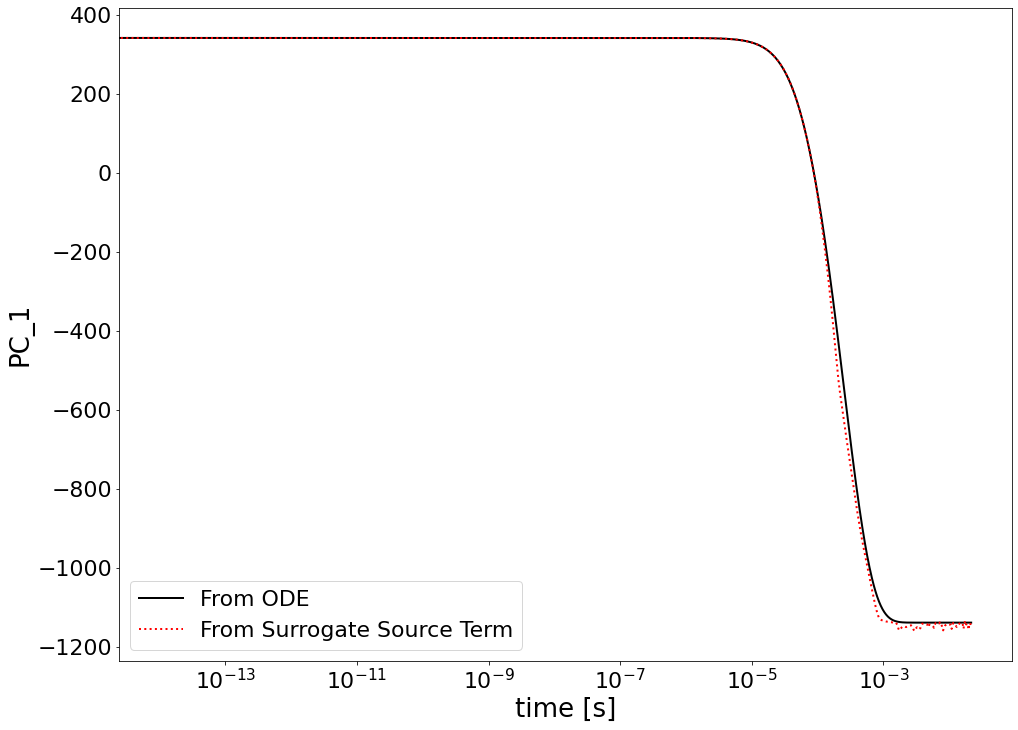

In [13]:
### Evaluating on Test Data

FileName       = DirDir + '/orig_data/ResidenceTimes.csv'
Data           = pd.read_csv(FileName, header=None)
RestValVecTest = np.log10(Data.to_numpy())

iPC = 0

fig = plt.figure(figsize=(16,12))
for iTest in CasesVec:
    RestVal                      = RestValVecTest[iTest]

    FileName                     = DirDir+'/pc_data_'+str(NVarsRed)+'/PC.csv.'+str(iTest+1)
    InputDataTest                = pd.read_csv(FileName, header=0)
    tVec                         = InputDataTest['t'].to_numpy()
    InputDataTest['log10(Rest)'] = RestVal * np.ones(len(tVec))
    yMat_pca                     = InputDataTest[InputData.InputVars].to_numpy()[:,1:]
    y0_pca                       = yMat_pca[0,:]
    print('RestVal = ', RestVal, '; y0_pca = ', y0_pca)
    
    plt.plot(tVec, yMat_pca[:,iPC], '-k', label='From ODE', lw=2)
    
    tNN      = []
    tt       = 0.0
    dt       = 1.e-14
    tStratch = 1.03
    tMax     = tVec[-1]
    while tt < tMax:
        tNN.append(tt)
        tt += dt
        dt *= tStratch
    #tNN          = tVec
    tNN      = np.array(tNN)
    
    output       = solve_ivp( f_NN, tNN[[0,-1]], y0_pca, method=SOLVER, t_eval=tNN, atol=1.e-4 )
    tNN          = output.t
    yMat_pca_    = output.y.T
    
    plt.plot(tNN, yMat_pca_[:,iPC], ':r', label='From Surrogate Source Term', lw=2)

plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel('PC_'+str(iPC+1))
plt.legend()

(-2000.0, 2500.0)

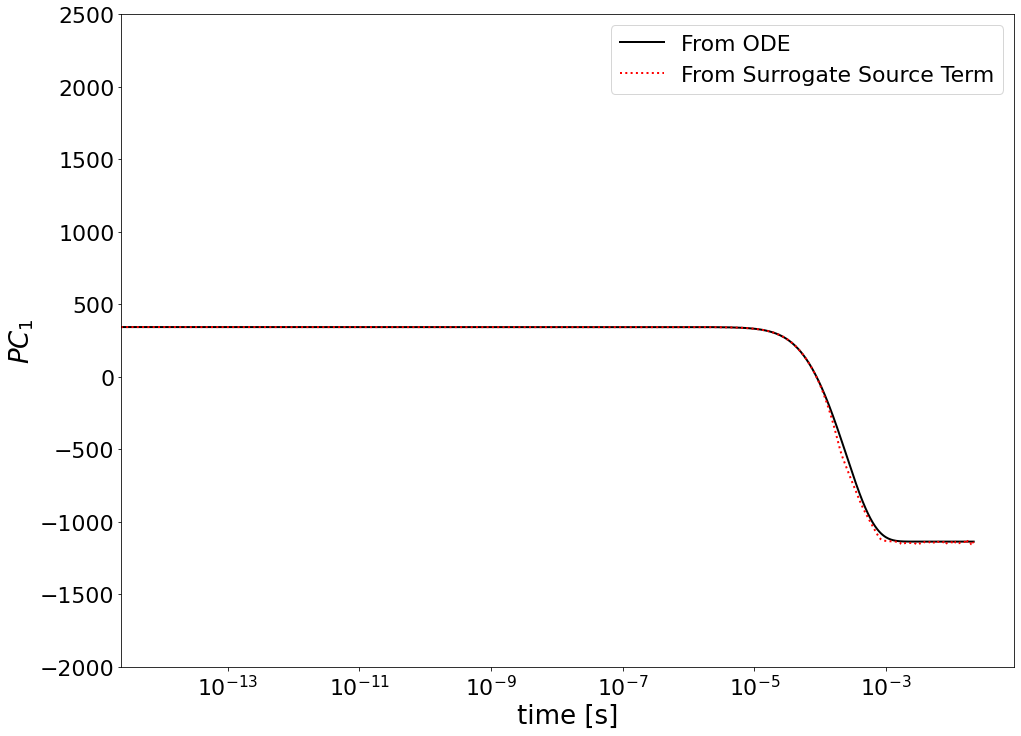

In [14]:
iPC = 0

fig = plt.figure(figsize=(16,12))
plt.plot(tVec, yMat_pca[:,iPC], '-k', label='From ODE',                   lw=2)
plt.plot(tNN, yMat_pca_[:,iPC], ':r', label='From Surrogate Source Term', lw=2)
plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel('$PC_'+str(iPC+1)+'$')
plt.legend()
plt.ylim([-2000.0, 2500.])
#plt.ylim([-5.0, 5.])
#plt.ylim([-0.3, 0.3])

In [15]:
FileName = OutputDir+'/pca_'+str(NVarsRed)+'/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/pca_'+str(NVarsRed)+'/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

In [16]:
yMatt    = (yMat_pca.dot(A)) *D[:,0] + C[:,0]
yMat_    = (yMat_pca_.dot(A))*D[:,0] + C[:,0]

iVar =  1


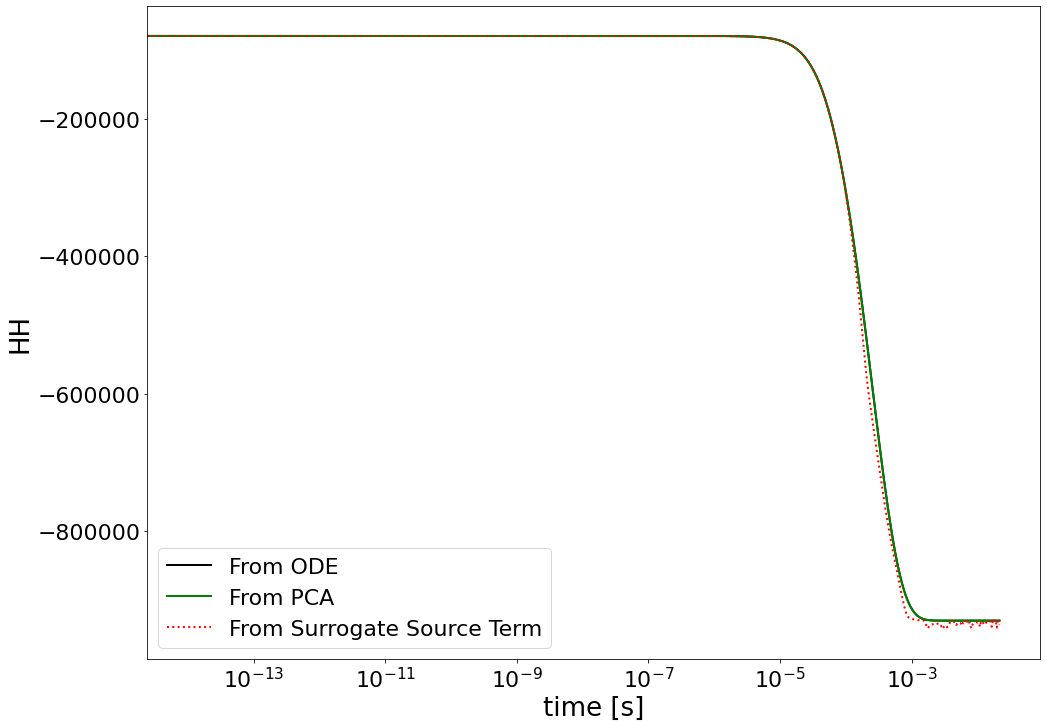

In [18]:
FileName = DirDir + '/orig_data/y.csv.1'
Data     = pd.read_csv(FileName, header=0)
VarNames = list(Data.columns)

VarOI    = 'HH'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
        
fig = plt.figure(figsize=(16,12))
for iTest in CasesVec:

    FileName     = DirDir + '/orig_data/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    yMat         = Data.to_numpy()[:,1:]
        
    plt.plot(tVec, yMat[:,iVar-1],  '-k', label='From ODE',                   lw=2)
    plt.plot(tVec, yMatt[:,iVar-1], '-g', label='From PCA',                   lw=2)
    plt.plot(tNN,  yMat_[:,iVar-1], ':r', label='From Surrogate Source Term', lw=2)

plt.xscale('log')
plt.xlabel('time [s]')
plt.ylabel(VarOI)
plt.legend()

In [25]:
VarOI    = 'HH'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
iVarH = iVar

VarOI    = 'CO'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
iVarCO = iVar

np.savetxt('/Users/sventur/Desktop/H_SST.csv', np.concatenate((tNN[...,np.newaxis], yMat_[:,iVarH-1][...,np.newaxis], yMat_[:,iVarCO-1][...,np.newaxis]), axis=1), header='t_SST,H_SST,CO_SST')

iVar =  1
iVar =  16


In [21]:
tNN[...,np.newaxis]

array([[0.00000000e+00],
       [1.00000000e-14],
       [2.03000000e-14],
       [3.09090000e-14],
       [4.18362700e-14],
       [5.30913581e-14],
       [6.46840988e-14],
       [7.66246218e-14],
       [8.89233605e-14],
       [1.01591061e-13],
       [1.14638793e-13],
       [1.28077957e-13],
       [1.41920296e-13],
       [1.56177904e-13],
       [1.70863242e-13],
       [1.85989139e-13],
       [2.01568813e-13],
       [2.17615877e-13],
       [2.34144354e-13],
       [2.51168684e-13],
       [2.68703745e-13],
       [2.86764857e-13],
       [3.05367803e-13],
       [3.24528837e-13],
       [3.44264702e-13],
       [3.64592643e-13],
       [3.85530423e-13],
       [4.07096335e-13],
       [4.29309225e-13],
       [4.52188502e-13],
       [4.75754157e-13],
       [5.00026782e-13],
       [5.25027585e-13],
       [5.50778413e-13],
       [5.77301765e-13],
       [6.04620818e-13],
       [6.32759443e-13],
       [6.61742226e-13],
       [6.91594493e-13],
       [7.22342328e-13],
